In [259]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier 
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score


In [189]:
df = pd.read_csv('../csvs/short_integration_features.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr']
del df['Rel_Eerr_short']
del df["runstring"]
#Nrows = df.shape[0]
#print Nrows, len(np.where(df['Stable']==0)[0])
print df.shape
df.head()

(14999, 114)


,Stable,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0.0,10000.0,1.000165,0.000329,1.001248,0.999691,0.000329,0.001083,0.000214,0.000456,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0.0,10000.0,0.999952,0.000739,1.002089,0.998309,0.000739,0.002137,0.000202,0.000463,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0.0,10000.0,0.998498,0.001948,1.002043,0.995446,0.001951,0.003550,0.001735,0.002860,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,1.0,10000.0,1.000006,0.000026,1.000126,0.999973,0.000026,0.000120,0.000005,0.000009,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0.0,10000.0,1.067267,0.030186,1.121364,1.000000,0.028284,0.063028,0.004313,0.010716,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


In [190]:
#"['daOverRH1' 'daOverRH2' 'mindaOverRH' 'maxdaOverRH' 'norm_LyapunovTime']"
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['Lyapunov_time']

y = df['Stable']
X = df[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,0.333921,0.077775,0.297364,0.016641,0.339655,0.010871,-9.963524e-11,2.144832e-10,2.681898e-11,9041.175397
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,0.307149,0.075092,0.115674,0.039718,0.251880,0.137917,-4.938423e-11,3.559377e-11,-9.314702e-11,2192.382019
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,0.583040,0.328325,0.038930,0.002380,0.026117,0.007227,6.451005e-11,-3.330088e-11,-4.095504e-11,2191.525922
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,0.048402,0.000124,0.514386,0.003658,0.301072,0.279903,8.676076e-12,7.816527e-13,-7.257099e-12,58599.215966
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,9.321252,0.823132,0.496372,0.248052,1.358604,0.261358,6.816926e-08,3.913858e-08,-2.610208e-08,43524.152375


In [198]:
Nrows = int(X.shape[0] * 0.5)
trainX = X.iloc[:Nrows,:]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]

Don't worry about number of estimators, learning rate, or colsample_by_tree for now, come back to it afterwards

In [199]:
space ={
        'max_depth': hp.randint('x_max_depth',  10),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
}

In [200]:
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])
    #initial method of using cv
    #eval_set  = [( testX, testY)]
    #clf.fit(trainX, trainY,
    #        eval_set=eval_set, eval_metric="auc", 
    #        early_stopping_rounds=10)
    #pred = clf.predict_proba(testX)[:,1]
    #auc = roc_auc_score(testY, pred)
    score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score = score.mean()
    print "SCORE:", score.mean()

    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score  }

In [201]:
trials = Trials()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials)

SCORE: 0.965517873892
SCORE: 0.965602290662
SCORE: 0.965462222454
SCORE: 0.965335250703
SCORE: 0.964487622318
SCORE: 0.965206576792
SCORE: 0.958454504579
SCORE: 0.96609685274
SCORE: 0.697026284189
SCORE: 0.965801555015


In [202]:
#print parameters that give the best values
print best

{'x_min_child': 6.0, 'x_max_depth': 8, 'x_subsample': 0.9205722376589776}


In [205]:
#try testing on the holdout set with these parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best["x_min_child"],
                         max_depth = best["x_max_depth"],
                         subsample = best["x_subsample"])
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score

0.976727850408


In [206]:
#trying optimizing the next two parameters
space2 ={
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1),
}

In [207]:
def objective2(space2):

    clf = XGBClassifier(n_estimators = 100, 
                            min_child_weight=best["x_min_child"],
                            max_depth = best["x_max_depth"],
                            subsample = best["x_subsample"],
                            colsample_bytree =space2['colsample_bytree'],
                            learning_rate = space2['learning_rate'])

    score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score = score.mean()
    print "SCORE:", score.mean()
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score  }

In [208]:
trials2 = Trials()
best2 = fmin(fn=objective2, space = space2, algo = tpe.suggest, max_evals = 20, trials = trials2)

SCORE: 0.966191006574
SCORE: 0.965496735583
SCORE: 0.966666653122
SCORE: 0.965136182586
SCORE: 0.966183870946
SCORE: 0.964480188054
SCORE: 0.96510633213
SCORE: 0.961183954974
SCORE: 0.96628152536
SCORE: 0.966282417224
SCORE: 0.964769894643
SCORE: 0.96446306637
SCORE: 0.963748009246
SCORE: 0.966126045672
SCORE: 0.966334784875
SCORE: 0.96430597207
SCORE: 0.966211649697
SCORE: 0.96549139652
SCORE: 0.965240885808
SCORE: 0.965830186084


In [209]:
#With both optimizations, we can now see the all the selected parameters we are interested in
print best
print best2

{'x_min_child': 6.0, 'x_max_depth': 8, 'x_subsample': 0.9205722376589776}
{'x_tree_colsample': 0.9766575927226975, 'x_learning_rate': 0.05630431364712837}


In [212]:
#try testing on the holdout set with ALL of the selected parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best["x_min_child"],
                         max_depth = best["x_max_depth"],
                         subsample = best["x_subsample"],
                         colsample_bytree = best2["x_tree_colsample"],
                         learning_rate = best2["x_learning_rate"])
#print trainX.shape, trainY.shape, testX.shape, testY.shape
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
#score only increases marginally from before

0.976818242266


In [213]:
test_best.feature_importances_

array([ 0.02237569,  0.0140884 ,  0.01823204,  0.02292818,  0.0140884 ,
        0.01243094,  0.0461326 ,  0.04696133,  0.01933702,  0.01436464,
        0.01961326,  0.01381215,  0.01740332,  0.01187845,  0.04558011,
        0.0198895 ,  0.06657459,  0.03176796,  0.05911602,  0.03950276,
        0.08646408,  0.0301105 ,  0.04751381,  0.02265193,  0.06767956,
        0.02569061,  0.0281768 ,  0.03729282,  0.0301105 ,  0.06823204], dtype=float32)

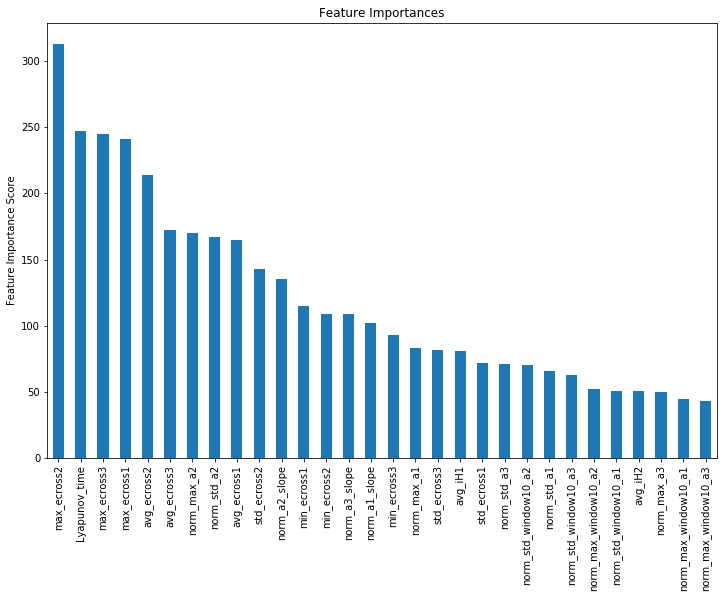

In [215]:
# feature importances
feat_imp = pd.Series(test_best.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()


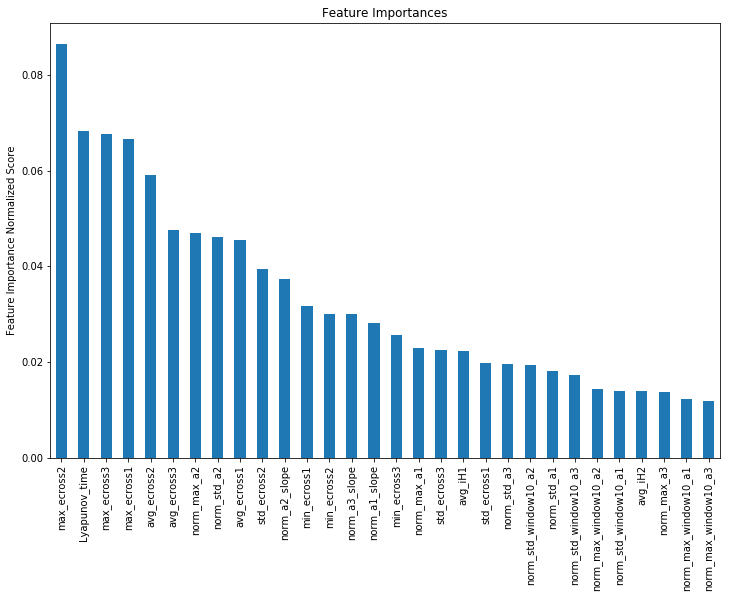

In [216]:
#try drawing a normalized version of the plot
feat_imp_norm = pd.Series(test_best.booster().get_fscore()).sort_values(ascending=False)
feat_imp_norm = feat_imp_norm/np.sum(feat_imp_norm)
#print feat_imp_norm
feat_imp_norm.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Normalized Score')
plt.show()

Try running the parameters together, and see if they change due to partial dependencies between any of them. Also increase number of iterations to ensure it has reached the optimal parameter space

In [219]:
space3 ={
        'max_depth': hp.quniform('x_max_depth', 1, 10,1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1)
}

In [220]:
def objective3(space3):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space3['max_depth'], 
                            min_child_weight =space3['min_child_weight'],
                            subsample = space3['subsample'],
                            colsample_bytree =space3['colsample_bytree'],
                            learning_rate = space3['learning_rate'])

    score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score = score.mean()
    print "SCORE:", score.mean()

    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score  }

In [221]:
trials3 = Trials()
import time
start = time.time()
best3 = fmin(fn=objective3, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials3)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE: 0.965821173051
SCORE: 0.962177380211
SCORE: 0.96013244117
SCORE: 0.966260754133
SCORE: 0.957763767447
SCORE: 0.96628126038
SCORE: 0.965775828571
SCORE: 0.961776336339
SCORE: 0.960834396182
SCORE: 0.965478879385
SCORE: 0.963330428138
SCORE: 0.962426304292
SCORE: 0.966284505667
SCORE: 0.936319023971
SCORE: 0.966019042442
SCORE: 0.955467452278
SCORE: 0.965373778168
SCORE: 0.965432516807
SCORE: 0.962745015726
SCORE: 0.965158233263
('Optimization Time: %f seconds', 1700.054902791977)


In [223]:
scores = [val["result"]['cv_score'] for val in trials3]
losses = [val["result"]['loss'] for val in trials3]

In [224]:
print np.mean(scores), np.std(scores)

0.962042925881 0.00660538789678


In [228]:
print best3

{'x_min_child': 4.0, 'x_tree_colsample': 0.58953601238089, 'x_max_depth': 7.0, 'x_subsample': 0.9656894973700625, 'x_learning_rate': 0.07078850869231385}


In [257]:
#combine the two spaces
best_model2 = XGBClassifier(seed = 0, learning_rate=best3["x_learning_rate"],
                            min_child_weight=best3["x_min_child"],
                            max_depth= int(best3["x_max_depth"]), 
                            subsample = best3["x_subsample"],
                            colsample_bytree = best3["x_tree_colsample"])

best_model2.fit(trainX, trainY)
pred = best_model2.predict_proba(testX)[:,1]
score = roc_auc_score(testY, pred)
print score

0.977047306832


In [264]:
from xgboost import DMatrix

xgb_param = best_model2.get_xgb_params()
xgtrain = DMatrix(X.values, label=df['Stable'].values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=20, nfold=5, metrics='auc', early_stopping_rounds=10)

In [323]:
print type(cvresult)
print cvresult.shape
print cvresult.iloc[-1]["test-auc-mean"]
print  cvresult.iloc[-1]

<class 'pandas.core.frame.DataFrame'>
(20, 4)
0.974803
test-auc-mean     0.974803
test-auc-std      0.001876
train-auc-mean    0.988308
train-auc-std     0.000149
Name: 19, dtype: float64


In [335]:
#implemented with xgb cv
xgtrain = DMatrix(X.values, label=df['Stable'].values)

def objective4(space3):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space3['max_depth'], 
                            min_child_weight =space3['min_child_weight'],
                            subsample = space3['subsample'],
                            colsample_bytree =space3['colsample_bytree'],
                            learning_rate = space3['learning_rate'])
    start = time.time()
    cv_result = xgb.cv(clf.get_xgb_params(),xgtrain, num_boost_round=10, nfold=5, metrics='auc', early_stopping_rounds=5 )
    end = time.time()
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    score =  cv_result.iloc[-1]["test-auc-mean"]
    score_std =  cv_result.iloc[-1]["test-auc-std"]
    print ("SCORE %f, in : %f s:" % (score, (end-start)))

    return{'loss':1-score, 'status': STATUS_OK, "cv_score":score, "test_avg": score_std }

In [332]:
trials4= Trials()
import time
start = time.time()
best4 = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials4)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE %f, in : %f s: (0.96810759999999996, 90.31143617630005)
SCORE %f, in : %f s: (0.96624160000000003, 49.9987998008728)
SCORE %f, in : %f s: (0.94791659999999989, 32.73367691040039)
SCORE %f, in : %f s: (0.97172119999999995, 102.43022513389587)
SCORE %f, in : %f s: (0.94604719999999998, 43.02915382385254)
SCORE %f, in : %f s: (0.94892480000000001, 46.01954698562622)
SCORE %f, in : %f s: (0.9722016, 150.62837290763855)
SCORE %f, in : %f s: (0.97191819999999995, 158.68804907798767)
SCORE %f, in : %f s: (0.97223939999999998, 96.7362151145935)
SCORE %f, in : %f s: (0.95743359999999988, 38.94356393814087)
SCORE %f, in : %f s: (0.96024080000000001, 54.78683590888977)
SCORE %f, in : %f s: (0.95342899999999986, 57.16151714324951)
SCORE %f, in : %f s: (0.95553679999999996, 56.36310601234436)
SCORE %f, in : %f s: (0.96796579999999999, 80.83302307128906)
SCORE %f, in : %f s: (0.96258819999999989, 44.407516956329346)
SCORE %f, in : %f s: (0.96555780000000002, 26.518529176712036)
SCORE %f, in : 

In [333]:
print best4

{'x_min_child': 7.0, 'x_tree_colsample': 0.6514176031386798, 'x_max_depth': 9.0, 'x_subsample': 0.8961238654534123, 'x_learning_rate': 0.09755862056202982}


In [338]:
#implemented with xgb cv
# try now on a slightly smaller set of the data, and have a separate hold out set.
xgtrain = DMatrix(trainX.values, label=trainY.values)
trials5= Trials()
import time
start = time.time()
best5 = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials5)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE 0.971539, in : 17.738302 s:
SCORE 0.968277, in : 18.030332 s:
SCORE 0.971522, in : 46.846593 s:
SCORE 0.921388, in : 11.113929 s:
SCORE 0.966277, in : 40.312588 s:
SCORE 0.967399, in : 54.666808 s:
SCORE 0.947121, in : 11.721715 s:
SCORE 0.968529, in : 20.185693 s:
SCORE 0.959690, in : 12.630841 s:
SCORE 0.969819, in : 18.349453 s:
SCORE 0.970181, in : 22.695705 s:
SCORE 0.971292, in : 24.930456 s:
SCORE 0.970816, in : 36.907046 s:
SCORE 0.971440, in : 27.546958 s:
SCORE 0.967492, in : 22.350196 s:
SCORE 0.968331, in : 19.085706 s:
SCORE 0.966912, in : 16.032150 s:
SCORE 0.945468, in : 8.378421 s:
SCORE 0.968115, in : 21.918841 s:
SCORE 0.970956, in : 22.365171 s:
('Optimization Time: %f seconds', 474.18807911872864)


In [159]:
import hyperopt
hyperopt.__file__

'/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/hyperopt/__init__.pyc'

In [341]:
#try testing on the holdout set with ALL of the selected parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best5["x_min_child"],
                         max_depth = int(best5["x_max_depth"]),
                         subsample = best5["x_subsample"],
                         colsample_bytree = best5["x_tree_colsample"],
                         learning_rate = best5["x_learning_rate"])
#print trainX.shape, trainY.shape, testX.shape, testY.shape
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
#score only increases marginally from before

0.976981854503


Ignore all cells below

The result is still very good, so then these parameters generate a model that generalizes fairly well

In [342]:
#Try again with 40 trials, to see if there is an improvement
import time
start = time.time()
best5_more = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 40, trials = trials5)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE 0.966605, in : 10.950023 s:
SCORE 0.971638, in : 21.362376 s:
SCORE 0.971486, in : 21.143568 s:
SCORE 0.969013, in : 13.201152 s:
SCORE 0.971001, in : 20.184471 s:
SCORE 0.970713, in : 20.187382 s:
SCORE 0.967807, in : 23.148881 s:
SCORE 0.970733, in : 33.916977 s:
SCORE 0.971024, in : 40.373488 s:
SCORE 0.971082, in : 50.323619 s:
SCORE 0.967850, in : 15.972994 s:
SCORE 0.971105, in : 27.917770 s:
SCORE 0.970609, in : 18.797427 s:
SCORE 0.971776, in : 26.747977 s:
SCORE 0.971542, in : 26.796972 s:
SCORE 0.914274, in : 6.401008 s:
SCORE 0.969348, in : 26.813246 s:
SCORE 0.970613, in : 21.555802 s:
SCORE 0.950217, in : 6.693871 s:
SCORE 0.970160, in : 16.343722 s:
('Optimization Time: %f seconds', 449.968092918396)


In [343]:
#try testing on the holdout set with ALL of the selected parameters
test_best = XGBClassifier(seed = 0, min_child_weight=best5_more["x_min_child"],
                         max_depth = int(best5_more["x_max_depth"]),
                         subsample = best5_more["x_subsample"],
                         colsample_bytree = best5_more["x_tree_colsample"],
                         learning_rate = best5_more["x_learning_rate"])
#print trainX.shape, trainY.shape, testX.shape, testY.shape
test_best.fit(trainX, trainY)
preds = test_best.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
#cv score on holdout set does not increase as you move from 20 trials to 40
#this means there is no need to run many trials, a small amount will be fine.

0.976681353609


In [37]:
for trial in trials3_more.trials[:1]:
    print trial

{'refresh_time': datetime.datetime(2017, 5, 24, 16, 53, 44, 2000), 'book_time': datetime.datetime(2017, 5, 24, 16, 53, 41, 155000), 'misc': {'tid': 0, 'idxs': {'x_min_child': [0], 'x_tree_colsample': [0], 'x_max_depth': [0], 'x_subsample': [0], 'x_learning_rate': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x_min_child': [10.0], 'x_tree_colsample': [0.7665785279959214], 'x_max_depth': [5.0], 'x_subsample': [0.9893943684094291], 'x_learning_rate': [0.06923821819312699]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 0.023082030956490862, 'score': 0.97691796904350914}, 'owner': None, 'spec': None}


In [139]:
print trials3_more.trials[:1]#["misc"]
exp = [val["misc"]["vals"]["x_min_child"] for val in trials3_more]
#print exp

[{'refresh_time': datetime.datetime(2017, 5, 24, 16, 53, 44, 2000), 'book_time': datetime.datetime(2017, 5, 24, 16, 53, 41, 155000), 'misc': {'tid': 0, 'idxs': {'x_min_child': [0], 'x_tree_colsample': [0], 'x_max_depth': [0], 'x_subsample': [0], 'x_learning_rate': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'x_min_child': [10.0], 'x_tree_colsample': [0.7665785279959214], 'x_max_depth': [5.0], 'x_subsample': [0.9893943684094291], 'x_learning_rate': [0.06923821819312699]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 0.023082030956490862, 'score': 0.97691796904350914}, 'owner': None, 'spec': None}]


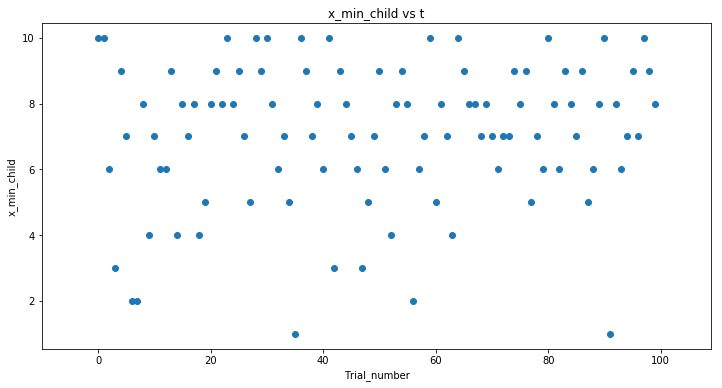

In [159]:
def plot_vals (name, trials):
    f = plt.figure(figsize = (12,6))
    ax = f.add_subplot(111)
    time_vals = [t['tid'] for t in trials.trials]
    min_child_weight = [val["misc"]["vals"][name] for val in trials]
    ax.set_xlim(time_vals[0]-10, time_vals[-1]+10)
    ax.scatter(time_vals, min_child_weight)
    ax.set_title('%s vs t' % name)
    ax.set_xlabel('Trial_number')
    ax.set_ylabel(name)
    plt.show()
plot_vals("x_min_child", trials3_more)

Can't really see it converging anywhere, would likley have to run more than the specified 100 trials to be able to tell 

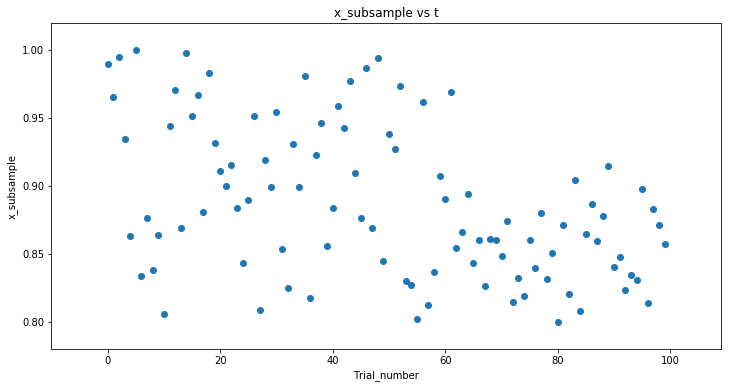

In [135]:
plot_vals("x_subsample")

Seems to be heading towards 0.8, would have to run more tests to be sure

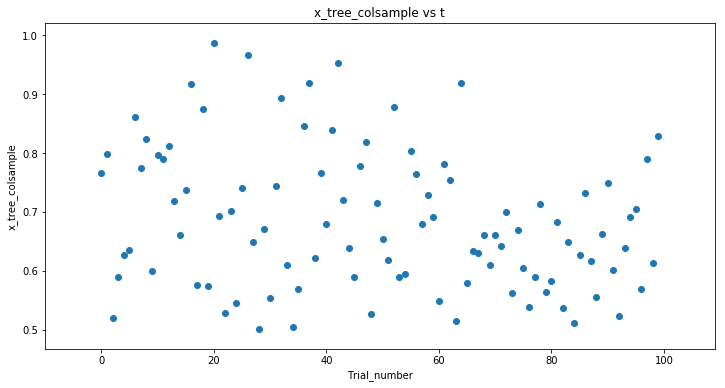

In [136]:
plot_vals("x_tree_colsample")

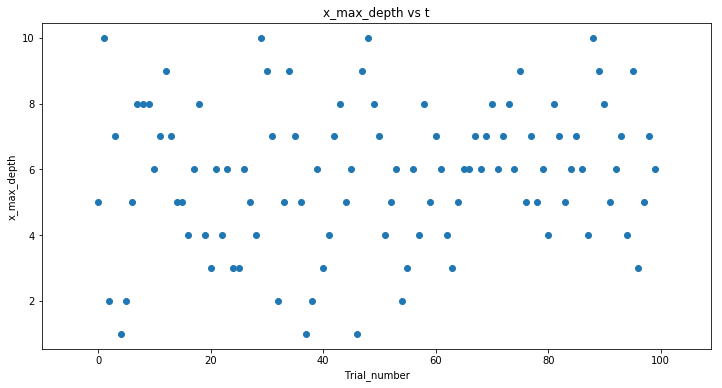

In [137]:
plot_vals("x_max_depth")

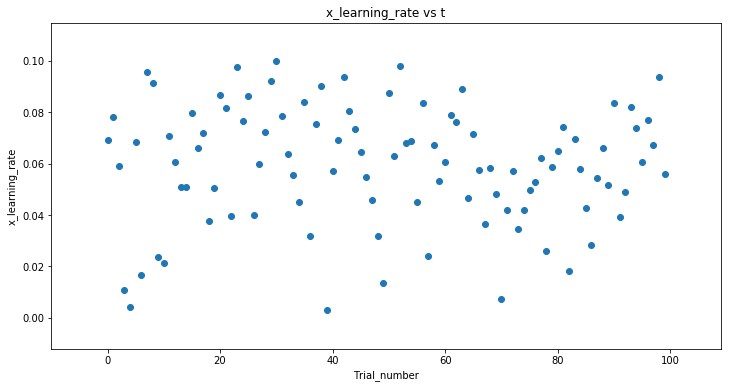

In [138]:
plot_vals("x_learning_rate")


Does appear to be heading towards 0.06, towards the end, less of the values tested are further away for 0.06

In [67]:
#try make three d plot to see if yuo can compare relationship between subsample and col_sample

In [174]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
from matplotlib import cm


def plot_vals_3d (name, name2, trials):
    f = plt.figure(figsize = (12,6))
    ax = f.add_subplot(111, projection = "3d")
    time_vals = [t['tid'] for t in trials.trials]
    param1 = [val["misc"]["vals"][name] for val in trials.trials]
    param2 = [val["misc"]["vals"][name2] for val in trials.trials]

    
    
    x1 = np.asarray(param1).reshape(len(param1))
    y1 = np.asarray(param2).reshape(len(param2))
    
    
    #surf = ax.plot_trisurf(x1, y1, time_vals, cmap=cm.jet, linewidth=0)
    #f.colorbar(time_vals)
    col_mapping = np.linspace(0,len(param1),len(param1))
    scat = ax.scatter(param1, param2, time_vals, c = col_mapping, cmap = cm.jet)
    m = cm.ScalarMappable(cmap=cm.jet, norm=scat.norm)
    m.set_array(time_vals)
    f.colorbar(m)
    ax.tick_params(axis='both', which='major', pad=3)

    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    ax.set_title('%s vs %s' % (name, name2))
    ax.set_xlabel(name, labelpad=5)
    ax.set_ylabel(name2, labelpad=5)
    ax.set_zlabel('Trial Number', labelpad=5)
    #ax.view_init(elev=10, azim=10)
    ax.view_init(elev=30, azim=30)  
    plt.show()

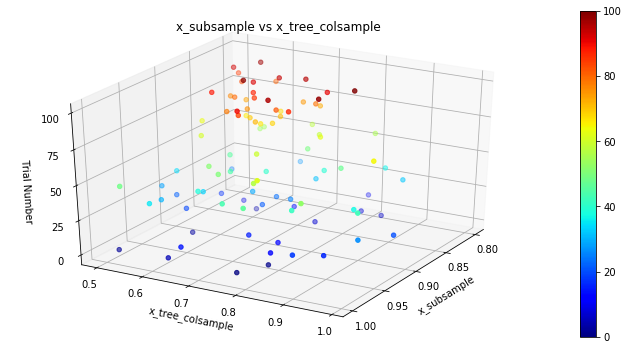

In [175]:
plot_vals_3d("x_subsample", "x_tree_colsample", trials3_more)

This above plot shows that as time passes by, the hyperopt selects parameters mostly concentrated around one area

In [140]:
#back to the model
best_model2

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.599441393371, gamma=0,
       learning_rate=0.0517038760567, max_delta_step=0, max_depth=10,
       min_child_weight=7.0, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.836607086657)

3531


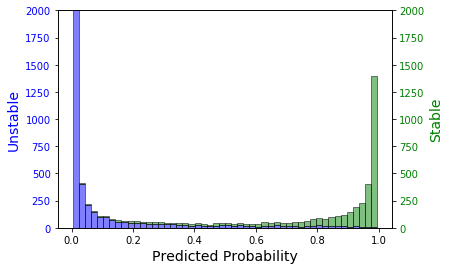

In [147]:
preds = best_model2.predict_proba(testX)[:,1]

bins = 50
Stable=preds[np.where(testY==1)]
Unstable=preds[np.where(testY==0)]

fig, ax1 = plt.subplots()
ax1.hist([Unstable, Stable], bins, alpha=0.5, label='No', color=['blue', 'green'], linewidth = 1, edgecolor='black', histtype='barstacked')
#ax1.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
print Stable.size
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')


ax2 = ax1.twinx()
#ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

#ax1.set_ylim(ax2.get_ylim())
ylim = 2000
ax1.set_ylim([0,ylim])
ax2.set_ylim([0,ylim])

plt.show()

In [149]:
from sklearn.metrics import roc_curve
tpr, fpr, thresholds = roc_curve( testY, preds)

for i in range(0,len(fpr), 10):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(thresholds[i], fpr[i], tpr[i]))

Threshold 0.995299577713, FPR = 0.000283205890683, TPR = 0.0
Threshold 0.989590704441, FPR = 0.17417162277, TPR = 0.000182848784056
Threshold 0.98134046793, FPR = 0.334466156896, TPR = 0.000548546352167
Threshold 0.968991041183, FPR = 0.4437836307, TPR = 0.00127994148839
Threshold 0.957026481628, FPR = 0.499008779383, TPR = 0.00219418540867
Threshold 0.94876563549, FPR = 0.531577456811, TPR = 0.003291278113
Threshold 0.934951901436, FPR = 0.571792693288, TPR = 0.00438837081733
Threshold 0.930219829082, FPR = 0.583404134806, TPR = 0.00530261473761
Threshold 0.925288259983, FPR = 0.594165958652, TPR = 0.00621685865789
Threshold 0.914120554924, FPR = 0.620504106485, TPR = 0.00713110257817
Threshold 0.907161831856, FPR = 0.632965165675, TPR = 0.00804534649845
Threshold 0.894571781158, FPR = 0.658736901728, TPR = 0.00895959041872
Threshold 0.888793408871, FPR = 0.665250637213, TPR = 0.0100566831231
Threshold 0.882274985313, FPR = 0.674596431606, TPR = 0.0111537758274
Threshold 0.87763738632

In [155]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(testY,preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')
print "AUC Score (Test): %f" % average_precision_score(testY, preds)

AUC Score (Test): 0.965028


In [156]:
#Try again with 100 trials
trials3_even_more = Trials()
best3_even_more = fmin(fn=objective3, space = space3, algo = tpe.suggest, max_evals = 500, trials = trials3_even_more)

[0]	validation_0-auc:0.943276
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.949841
[2]	validation_0-auc:0.953438
[3]	validation_0-auc:0.954237
[4]	validation_0-auc:0.959335
[5]	validation_0-auc:0.960344
[6]	validation_0-auc:0.961151
[7]	validation_0-auc:0.962525
[8]	validation_0-auc:0.962397
[9]	validation_0-auc:0.962911
[10]	validation_0-auc:0.964716
[11]	validation_0-auc:0.965726
[12]	validation_0-auc:0.966529
[13]	validation_0-auc:0.966803
[14]	validation_0-auc:0.967549
[15]	validation_0-auc:0.968155
[16]	validation_0-auc:0.968786
[17]	validation_0-auc:0.969239
[18]	validation_0-auc:0.969536
[19]	validation_0-auc:0.969848
[20]	validation_0-auc:0.970313
[21]	validation_0-auc:0.970862
[22]	validation_0-auc:0.971244
[23]	validation_0-auc:0.971451
[24]	validation_0-auc:0.971637
[25]	validation_0-auc:0.971791
[26]	validation_0-auc:0.97209
[27]	validation_0-auc:0.972161
[28]	validation_0-auc:0.972351
[29]	validation_0-auc:0.972442
[30]	validation_0

[59]	validation_0-auc:0.976636
[60]	validation_0-auc:0.976667
[61]	validation_0-auc:0.976671
[62]	validation_0-auc:0.976708
[63]	validation_0-auc:0.976648
[64]	validation_0-auc:0.976695
[65]	validation_0-auc:0.976715
[66]	validation_0-auc:0.976694
[67]	validation_0-auc:0.976716
[68]	validation_0-auc:0.976724
[69]	validation_0-auc:0.976722
[70]	validation_0-auc:0.976707
[71]	validation_0-auc:0.976726
[72]	validation_0-auc:0.976721
[73]	validation_0-auc:0.976729
[74]	validation_0-auc:0.976707
[75]	validation_0-auc:0.976713
[76]	validation_0-auc:0.976695
[77]	validation_0-auc:0.976706
[78]	validation_0-auc:0.976745
[79]	validation_0-auc:0.976745
[80]	validation_0-auc:0.976723
[81]	validation_0-auc:0.976771
[82]	validation_0-auc:0.976765
[83]	validation_0-auc:0.976793
[84]	validation_0-auc:0.976751
[85]	validation_0-auc:0.976751
[86]	validation_0-auc:0.976748
[87]	validation_0-auc:0.976729
[88]	validation_0-auc:0.976739
[89]	validation_0-auc:0.976692
[90]	validation_0-auc:0.976688
[91]	val

[17]	validation_0-auc:0.971605
[18]	validation_0-auc:0.971808
[19]	validation_0-auc:0.971783
[20]	validation_0-auc:0.971901
[21]	validation_0-auc:0.972044
[22]	validation_0-auc:0.972325
[23]	validation_0-auc:0.972442
[24]	validation_0-auc:0.97241
[25]	validation_0-auc:0.972446
[26]	validation_0-auc:0.972574
[27]	validation_0-auc:0.972596
[28]	validation_0-auc:0.97271
[29]	validation_0-auc:0.972608
[30]	validation_0-auc:0.972597
[31]	validation_0-auc:0.972642
[32]	validation_0-auc:0.972783
[33]	validation_0-auc:0.972849
[34]	validation_0-auc:0.972855
[35]	validation_0-auc:0.972857
[36]	validation_0-auc:0.972795
[37]	validation_0-auc:0.972758
[38]	validation_0-auc:0.97274
[39]	validation_0-auc:0.972886
[40]	validation_0-auc:0.972986
[41]	validation_0-auc:0.972974
[42]	validation_0-auc:0.972999
[43]	validation_0-auc:0.972929
[44]	validation_0-auc:0.972975
[45]	validation_0-auc:0.973019
[46]	validation_0-auc:0.973089
[47]	validation_0-auc:0.973036
[48]	validation_0-auc:0.973151
[49]	valida

[78]	validation_0-auc:0.974385
[79]	validation_0-auc:0.974411
[80]	validation_0-auc:0.974491
[81]	validation_0-auc:0.974554
[82]	validation_0-auc:0.974592
[83]	validation_0-auc:0.974636
[84]	validation_0-auc:0.974706
[85]	validation_0-auc:0.974729
[86]	validation_0-auc:0.97479
[87]	validation_0-auc:0.97479
[88]	validation_0-auc:0.974837
[89]	validation_0-auc:0.97486
[90]	validation_0-auc:0.974908
[91]	validation_0-auc:0.974913
[92]	validation_0-auc:0.974914
[93]	validation_0-auc:0.974925
[94]	validation_0-auc:0.974978
[95]	validation_0-auc:0.974996
[96]	validation_0-auc:0.97505
[97]	validation_0-auc:0.975067
[98]	validation_0-auc:0.975096
[99]	validation_0-auc:0.975109
SCORE: 0.97510866712
[0]	validation_0-auc:0.952341
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957318
[2]	validation_0-auc:0.960937
[3]	validation_0-auc:0.963356
[4]	validation_0-auc:0.966222
[5]	validation_0-auc:0.966272
[6]	validation_0-auc:0.966598
[7]	validation_0-auc:0.9669

[37]	validation_0-auc:0.974517
[38]	validation_0-auc:0.974584
[39]	validation_0-auc:0.97468
[40]	validation_0-auc:0.974666
[41]	validation_0-auc:0.974699
[42]	validation_0-auc:0.974789
[43]	validation_0-auc:0.974879
[44]	validation_0-auc:0.974945
[45]	validation_0-auc:0.975042
[46]	validation_0-auc:0.975085
[47]	validation_0-auc:0.975132
[48]	validation_0-auc:0.975166
[49]	validation_0-auc:0.975261
[50]	validation_0-auc:0.975251
[51]	validation_0-auc:0.975307
[52]	validation_0-auc:0.975364
[53]	validation_0-auc:0.975367
[54]	validation_0-auc:0.975414
[55]	validation_0-auc:0.975434
[56]	validation_0-auc:0.975469
[57]	validation_0-auc:0.975533
[58]	validation_0-auc:0.975576
[59]	validation_0-auc:0.975635
[60]	validation_0-auc:0.975668
[61]	validation_0-auc:0.975725
[62]	validation_0-auc:0.975772
[63]	validation_0-auc:0.975795
[64]	validation_0-auc:0.975835
[65]	validation_0-auc:0.975834
[66]	validation_0-auc:0.975884
[67]	validation_0-auc:0.97589
[68]	validation_0-auc:0.975873
[69]	valid

[98]	validation_0-auc:0.976898
[99]	validation_0-auc:0.976907
SCORE: 0.976907146218
[0]	validation_0-auc:0.946275
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.955893
[2]	validation_0-auc:0.962468
[3]	validation_0-auc:0.962775
[4]	validation_0-auc:0.96517
[5]	validation_0-auc:0.964743
[6]	validation_0-auc:0.966561
[7]	validation_0-auc:0.967265
[8]	validation_0-auc:0.96786
[9]	validation_0-auc:0.968136
[10]	validation_0-auc:0.968601
[11]	validation_0-auc:0.969049
[12]	validation_0-auc:0.969805
[13]	validation_0-auc:0.969974
[14]	validation_0-auc:0.970451
[15]	validation_0-auc:0.970563
[16]	validation_0-auc:0.971099
[17]	validation_0-auc:0.971334
[18]	validation_0-auc:0.971663
[19]	validation_0-auc:0.971833
[20]	validation_0-auc:0.971984
[21]	validation_0-auc:0.972298
[22]	validation_0-auc:0.972654
[23]	validation_0-auc:0.972814
[24]	validation_0-auc:0.973056
[25]	validation_0-auc:0.973084
[26]	validation_0-auc:0.973218
[27]	validation_0-auc:0.973

[56]	validation_0-auc:0.976485
[57]	validation_0-auc:0.976532
[58]	validation_0-auc:0.976577
[59]	validation_0-auc:0.976608
[60]	validation_0-auc:0.976635
[61]	validation_0-auc:0.976656
[62]	validation_0-auc:0.976706
[63]	validation_0-auc:0.976704
[64]	validation_0-auc:0.976732
[65]	validation_0-auc:0.976727
[66]	validation_0-auc:0.97673
[67]	validation_0-auc:0.976722
[68]	validation_0-auc:0.976689
[69]	validation_0-auc:0.976653
[70]	validation_0-auc:0.976631
[71]	validation_0-auc:0.976638
[72]	validation_0-auc:0.976606
[73]	validation_0-auc:0.976611
[74]	validation_0-auc:0.976562
[75]	validation_0-auc:0.976524
[76]	validation_0-auc:0.976516
[77]	validation_0-auc:0.976516
[78]	validation_0-auc:0.976501
[79]	validation_0-auc:0.976515
[80]	validation_0-auc:0.976512
[81]	validation_0-auc:0.976546
[82]	validation_0-auc:0.976522
[83]	validation_0-auc:0.976535
[84]	validation_0-auc:0.976568
Stopping. Best iteration:
[64]	validation_0-auc:0.976732

SCORE: 0.976568479821
[0]	validation_0-auc:0

[27]	validation_0-auc:0.974451
[28]	validation_0-auc:0.974579
[29]	validation_0-auc:0.974687
[30]	validation_0-auc:0.97478
[31]	validation_0-auc:0.974803
[32]	validation_0-auc:0.974772
[33]	validation_0-auc:0.974904
[34]	validation_0-auc:0.975004
[35]	validation_0-auc:0.975085
[36]	validation_0-auc:0.975199
[37]	validation_0-auc:0.975245
[38]	validation_0-auc:0.975269
[39]	validation_0-auc:0.975378
[40]	validation_0-auc:0.975365
[41]	validation_0-auc:0.975388
[42]	validation_0-auc:0.975455
[43]	validation_0-auc:0.975496
[44]	validation_0-auc:0.975507
[45]	validation_0-auc:0.975617
[46]	validation_0-auc:0.975618
[47]	validation_0-auc:0.975654
[48]	validation_0-auc:0.975662
[49]	validation_0-auc:0.975679
[50]	validation_0-auc:0.975704
[51]	validation_0-auc:0.975711
[52]	validation_0-auc:0.975732
[53]	validation_0-auc:0.975776
[54]	validation_0-auc:0.975772
[55]	validation_0-auc:0.97576
[56]	validation_0-auc:0.975757
[57]	validation_0-auc:0.975829
[58]	validation_0-auc:0.975896
[59]	valid

[88]	validation_0-auc:0.976912
[89]	validation_0-auc:0.976927
[90]	validation_0-auc:0.9769
[91]	validation_0-auc:0.976941
[92]	validation_0-auc:0.976927
[93]	validation_0-auc:0.976917
[94]	validation_0-auc:0.976912
[95]	validation_0-auc:0.976925
[96]	validation_0-auc:0.976971
[97]	validation_0-auc:0.976955
[98]	validation_0-auc:0.976909
[99]	validation_0-auc:0.976904
SCORE: 0.976904194539
[0]	validation_0-auc:0.850117
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.906963
[2]	validation_0-auc:0.906963
[3]	validation_0-auc:0.908801
[4]	validation_0-auc:0.915949
[5]	validation_0-auc:0.917082
[6]	validation_0-auc:0.91661
[7]	validation_0-auc:0.923328
[8]	validation_0-auc:0.926091
[9]	validation_0-auc:0.928539
[10]	validation_0-auc:0.935323
[11]	validation_0-auc:0.937303
[12]	validation_0-auc:0.936964
[13]	validation_0-auc:0.937337
[14]	validation_0-auc:0.938211
[15]	validation_0-auc:0.942224
[16]	validation_0-auc:0.94184
[17]	validation_0-auc:0.94192

[46]	validation_0-auc:0.974852
[47]	validation_0-auc:0.974926
[48]	validation_0-auc:0.974975
[49]	validation_0-auc:0.975077
[50]	validation_0-auc:0.975113
[51]	validation_0-auc:0.97517
[52]	validation_0-auc:0.975232
[53]	validation_0-auc:0.975266
[54]	validation_0-auc:0.975387
[55]	validation_0-auc:0.975415
[56]	validation_0-auc:0.975448
[57]	validation_0-auc:0.975519
[58]	validation_0-auc:0.975553
[59]	validation_0-auc:0.975584
[60]	validation_0-auc:0.975585
[61]	validation_0-auc:0.975642
[62]	validation_0-auc:0.975728
[63]	validation_0-auc:0.975729
[64]	validation_0-auc:0.975729
[65]	validation_0-auc:0.975801
[66]	validation_0-auc:0.975823
[67]	validation_0-auc:0.975862
[68]	validation_0-auc:0.975909
[69]	validation_0-auc:0.975951
[70]	validation_0-auc:0.975946
[71]	validation_0-auc:0.975985
[72]	validation_0-auc:0.976042
[73]	validation_0-auc:0.976083
[74]	validation_0-auc:0.976129
[75]	validation_0-auc:0.97615
[76]	validation_0-auc:0.976156
[77]	validation_0-auc:0.976212
[78]	valid

[4]	validation_0-auc:0.968207
[5]	validation_0-auc:0.968452
[6]	validation_0-auc:0.96919
[7]	validation_0-auc:0.970161
[8]	validation_0-auc:0.970956
[9]	validation_0-auc:0.971189
[10]	validation_0-auc:0.971685
[11]	validation_0-auc:0.971931
[12]	validation_0-auc:0.972277
[13]	validation_0-auc:0.972479
[14]	validation_0-auc:0.972564
[15]	validation_0-auc:0.972882
[16]	validation_0-auc:0.973098
[17]	validation_0-auc:0.973361
[18]	validation_0-auc:0.973591
[19]	validation_0-auc:0.973604
[20]	validation_0-auc:0.973647
[21]	validation_0-auc:0.973913
[22]	validation_0-auc:0.974026
[23]	validation_0-auc:0.97402
[24]	validation_0-auc:0.974122
[25]	validation_0-auc:0.974189
[26]	validation_0-auc:0.974368
[27]	validation_0-auc:0.97447
[28]	validation_0-auc:0.974531
[29]	validation_0-auc:0.974553
[30]	validation_0-auc:0.974677
[31]	validation_0-auc:0.974787
[32]	validation_0-auc:0.974916
[33]	validation_0-auc:0.974937
[34]	validation_0-auc:0.974926
[35]	validation_0-auc:0.974998
[36]	validation_0

[70]	validation_0-auc:0.976774
[71]	validation_0-auc:0.976814
[72]	validation_0-auc:0.976779
[73]	validation_0-auc:0.976765
[74]	validation_0-auc:0.976758
[75]	validation_0-auc:0.976787
[76]	validation_0-auc:0.97677
[77]	validation_0-auc:0.976768
[78]	validation_0-auc:0.976818
[79]	validation_0-auc:0.976845
[80]	validation_0-auc:0.976876
[81]	validation_0-auc:0.976938
[82]	validation_0-auc:0.976906
[83]	validation_0-auc:0.976937
[84]	validation_0-auc:0.976929
[85]	validation_0-auc:0.976907
[86]	validation_0-auc:0.97692
[87]	validation_0-auc:0.976914
[88]	validation_0-auc:0.976903
[89]	validation_0-auc:0.976901
[90]	validation_0-auc:0.976884
[91]	validation_0-auc:0.97689
[92]	validation_0-auc:0.976871
[93]	validation_0-auc:0.976861
[94]	validation_0-auc:0.976869
[95]	validation_0-auc:0.976845
[96]	validation_0-auc:0.976862
[97]	validation_0-auc:0.976887
[98]	validation_0-auc:0.97685
[99]	validation_0-auc:0.976839
SCORE: 0.976838584397
[0]	validation_0-auc:0.952081
Will train until valid

[28]	validation_0-auc:0.973592
[29]	validation_0-auc:0.973709
[30]	validation_0-auc:0.973834
[31]	validation_0-auc:0.973918
[32]	validation_0-auc:0.974044
[33]	validation_0-auc:0.974165
[34]	validation_0-auc:0.974182
[35]	validation_0-auc:0.974273
[36]	validation_0-auc:0.974267
[37]	validation_0-auc:0.974309
[38]	validation_0-auc:0.97442
[39]	validation_0-auc:0.974537
[40]	validation_0-auc:0.974687
[41]	validation_0-auc:0.974757
[42]	validation_0-auc:0.97479
[43]	validation_0-auc:0.974824
[44]	validation_0-auc:0.97491
[45]	validation_0-auc:0.974981
[46]	validation_0-auc:0.975017
[47]	validation_0-auc:0.975023
[48]	validation_0-auc:0.975074
[49]	validation_0-auc:0.975127
[50]	validation_0-auc:0.975173
[51]	validation_0-auc:0.975168
[52]	validation_0-auc:0.975235
[53]	validation_0-auc:0.97522
[54]	validation_0-auc:0.975323
[55]	validation_0-auc:0.975305
[56]	validation_0-auc:0.975358
[57]	validation_0-auc:0.975395
[58]	validation_0-auc:0.975454
[59]	validation_0-auc:0.975517
[60]	validat

[89]	validation_0-auc:0.976945
[90]	validation_0-auc:0.976891
[91]	validation_0-auc:0.976874
[92]	validation_0-auc:0.97688
[93]	validation_0-auc:0.976902
[94]	validation_0-auc:0.976926
[95]	validation_0-auc:0.976923
[96]	validation_0-auc:0.97695
[97]	validation_0-auc:0.977013
[98]	validation_0-auc:0.977059
[99]	validation_0-auc:0.9771
SCORE: 0.977100248205
[0]	validation_0-auc:0.936069
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.953894
[2]	validation_0-auc:0.956288
[3]	validation_0-auc:0.959582
[4]	validation_0-auc:0.963039
[5]	validation_0-auc:0.964807
[6]	validation_0-auc:0.966201
[7]	validation_0-auc:0.967148
[8]	validation_0-auc:0.967808
[9]	validation_0-auc:0.968712
[10]	validation_0-auc:0.969243
[11]	validation_0-auc:0.969608
[12]	validation_0-auc:0.970248
[13]	validation_0-auc:0.970866
[14]	validation_0-auc:0.97112
[15]	validation_0-auc:0.971557
[16]	validation_0-auc:0.972023
[17]	validation_0-auc:0.972233
[18]	validation_0-auc:0.972337

[47]	validation_0-auc:0.97192
[48]	validation_0-auc:0.971982
[49]	validation_0-auc:0.972257
[50]	validation_0-auc:0.97246
[51]	validation_0-auc:0.972541
[52]	validation_0-auc:0.97277
[53]	validation_0-auc:0.973003
[54]	validation_0-auc:0.973232
[55]	validation_0-auc:0.973367
[56]	validation_0-auc:0.973393
[57]	validation_0-auc:0.973471
[58]	validation_0-auc:0.9736
[59]	validation_0-auc:0.973726
[60]	validation_0-auc:0.973775
[61]	validation_0-auc:0.973737
[62]	validation_0-auc:0.973874
[63]	validation_0-auc:0.973925
[64]	validation_0-auc:0.974051
[65]	validation_0-auc:0.974154
[66]	validation_0-auc:0.974213
[67]	validation_0-auc:0.974276
[68]	validation_0-auc:0.974393
[69]	validation_0-auc:0.974442
[70]	validation_0-auc:0.97448
[71]	validation_0-auc:0.97463
[72]	validation_0-auc:0.974697
[73]	validation_0-auc:0.974744
[74]	validation_0-auc:0.974818
[75]	validation_0-auc:0.974849
[76]	validation_0-auc:0.974934
[77]	validation_0-auc:0.975056
[78]	validation_0-auc:0.975099
[79]	validation

[5]	validation_0-auc:0.966451
[6]	validation_0-auc:0.966791
[7]	validation_0-auc:0.967472
[8]	validation_0-auc:0.96755
[9]	validation_0-auc:0.96814
[10]	validation_0-auc:0.968492
[11]	validation_0-auc:0.969429
[12]	validation_0-auc:0.96933
[13]	validation_0-auc:0.969472
[14]	validation_0-auc:0.969878
[15]	validation_0-auc:0.970347
[16]	validation_0-auc:0.970808
[17]	validation_0-auc:0.970977
[18]	validation_0-auc:0.97107
[19]	validation_0-auc:0.971355
[20]	validation_0-auc:0.971681
[21]	validation_0-auc:0.971997
[22]	validation_0-auc:0.972369
[23]	validation_0-auc:0.972567
[24]	validation_0-auc:0.972784
[25]	validation_0-auc:0.972944
[26]	validation_0-auc:0.973094
[27]	validation_0-auc:0.973256
[28]	validation_0-auc:0.973449
[29]	validation_0-auc:0.973469
[30]	validation_0-auc:0.973619
[31]	validation_0-auc:0.973638
[32]	validation_0-auc:0.973698
[33]	validation_0-auc:0.973764
[34]	validation_0-auc:0.973808
[35]	validation_0-auc:0.973929
[36]	validation_0-auc:0.973946
[37]	validation_0

[66]	validation_0-auc:0.969345
[67]	validation_0-auc:0.969649
[68]	validation_0-auc:0.969799
[69]	validation_0-auc:0.969828
[70]	validation_0-auc:0.970078
[71]	validation_0-auc:0.970145
[72]	validation_0-auc:0.970159
[73]	validation_0-auc:0.970182
[74]	validation_0-auc:0.970266
[75]	validation_0-auc:0.970391
[76]	validation_0-auc:0.970423
[77]	validation_0-auc:0.970539
[78]	validation_0-auc:0.970611
[79]	validation_0-auc:0.97068
[80]	validation_0-auc:0.970782
[81]	validation_0-auc:0.970831
[82]	validation_0-auc:0.970901
[83]	validation_0-auc:0.970981
[84]	validation_0-auc:0.971094
[85]	validation_0-auc:0.971317
[86]	validation_0-auc:0.971489
[87]	validation_0-auc:0.971421
[88]	validation_0-auc:0.971406
[89]	validation_0-auc:0.971422
[90]	validation_0-auc:0.971493
[91]	validation_0-auc:0.97167
[92]	validation_0-auc:0.971696
[93]	validation_0-auc:0.971773
[94]	validation_0-auc:0.97191
[95]	validation_0-auc:0.971955
[96]	validation_0-auc:0.97205
[97]	validation_0-auc:0.972246
[98]	validat

[24]	validation_0-auc:0.971724
[25]	validation_0-auc:0.971909
[26]	validation_0-auc:0.972198
[27]	validation_0-auc:0.972379
[28]	validation_0-auc:0.972525
[29]	validation_0-auc:0.972579
[30]	validation_0-auc:0.972739
[31]	validation_0-auc:0.972838
[32]	validation_0-auc:0.972907
[33]	validation_0-auc:0.973089
[34]	validation_0-auc:0.97315
[35]	validation_0-auc:0.973214
[36]	validation_0-auc:0.973265
[37]	validation_0-auc:0.973348
[38]	validation_0-auc:0.973349
[39]	validation_0-auc:0.973503
[40]	validation_0-auc:0.973679
[41]	validation_0-auc:0.973756
[42]	validation_0-auc:0.973788
[43]	validation_0-auc:0.973877
[44]	validation_0-auc:0.973963
[45]	validation_0-auc:0.974106
[46]	validation_0-auc:0.974125
[47]	validation_0-auc:0.974167
[48]	validation_0-auc:0.974262
[49]	validation_0-auc:0.974354
[50]	validation_0-auc:0.974402
[51]	validation_0-auc:0.9744
[52]	validation_0-auc:0.974448
[53]	validation_0-auc:0.974567
[54]	validation_0-auc:0.974615
[55]	validation_0-auc:0.974622
[56]	valida

[85]	validation_0-auc:0.973356
[86]	validation_0-auc:0.973403
[87]	validation_0-auc:0.973443
[88]	validation_0-auc:0.973458
[89]	validation_0-auc:0.973484
[90]	validation_0-auc:0.973491
[91]	validation_0-auc:0.973544
[92]	validation_0-auc:0.973585
[93]	validation_0-auc:0.973609
[94]	validation_0-auc:0.973648
[95]	validation_0-auc:0.973659
[96]	validation_0-auc:0.973735
[97]	validation_0-auc:0.973792
[98]	validation_0-auc:0.973839
[99]	validation_0-auc:0.973851
SCORE: 0.973850552526
[0]	validation_0-auc:0.944035
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.950481
[2]	validation_0-auc:0.956753
[3]	validation_0-auc:0.957866
[4]	validation_0-auc:0.962234
[5]	validation_0-auc:0.962859
[6]	validation_0-auc:0.963401
[7]	validation_0-auc:0.964467
[8]	validation_0-auc:0.965434
[9]	validation_0-auc:0.965129
[10]	validation_0-auc:0.965368
[11]	validation_0-auc:0.966307
[12]	validation_0-auc:0.967053
[13]	validation_0-auc:0.967424
[14]	validation_0-auc:0.9

[43]	validation_0-auc:0.973957
[44]	validation_0-auc:0.974123
[45]	validation_0-auc:0.974245
[46]	validation_0-auc:0.974326
[47]	validation_0-auc:0.974461
[48]	validation_0-auc:0.974559
[49]	validation_0-auc:0.974549
[50]	validation_0-auc:0.974511
[51]	validation_0-auc:0.974576
[52]	validation_0-auc:0.974655
[53]	validation_0-auc:0.974711
[54]	validation_0-auc:0.974841
[55]	validation_0-auc:0.974966
[56]	validation_0-auc:0.9751
[57]	validation_0-auc:0.975112
[58]	validation_0-auc:0.975207
[59]	validation_0-auc:0.975289
[60]	validation_0-auc:0.975308
[61]	validation_0-auc:0.975309
[62]	validation_0-auc:0.975404
[63]	validation_0-auc:0.975479
[64]	validation_0-auc:0.975493
[65]	validation_0-auc:0.975536
[66]	validation_0-auc:0.975551
[67]	validation_0-auc:0.975582
[68]	validation_0-auc:0.975645
[69]	validation_0-auc:0.975721
[70]	validation_0-auc:0.975742
[71]	validation_0-auc:0.975748
[72]	validation_0-auc:0.975749
[73]	validation_0-auc:0.975792
[74]	validation_0-auc:0.975838
[75]	valid

[1]	validation_0-auc:0.957331
[2]	validation_0-auc:0.962522
[3]	validation_0-auc:0.964815
[4]	validation_0-auc:0.967489
[5]	validation_0-auc:0.967784
[6]	validation_0-auc:0.968731
[7]	validation_0-auc:0.97
[8]	validation_0-auc:0.971082
[9]	validation_0-auc:0.97152
[10]	validation_0-auc:0.972092
[11]	validation_0-auc:0.972568
[12]	validation_0-auc:0.972749
[13]	validation_0-auc:0.972838
[14]	validation_0-auc:0.973099
[15]	validation_0-auc:0.973338
[16]	validation_0-auc:0.973526
[17]	validation_0-auc:0.973613
[18]	validation_0-auc:0.973874
[19]	validation_0-auc:0.974067
[20]	validation_0-auc:0.974124
[21]	validation_0-auc:0.974297
[22]	validation_0-auc:0.974446
[23]	validation_0-auc:0.974547
[24]	validation_0-auc:0.974673
[25]	validation_0-auc:0.97469
[26]	validation_0-auc:0.974762
[27]	validation_0-auc:0.97493
[28]	validation_0-auc:0.974958
[29]	validation_0-auc:0.975082
[30]	validation_0-auc:0.975168
[31]	validation_0-auc:0.975224
[32]	validation_0-auc:0.9753
[33]	validation_0-auc:0.97

[62]	validation_0-auc:0.976432
[63]	validation_0-auc:0.976458
[64]	validation_0-auc:0.976526
[65]	validation_0-auc:0.976566
[66]	validation_0-auc:0.976626
[67]	validation_0-auc:0.976642
[68]	validation_0-auc:0.97669
[69]	validation_0-auc:0.976695
[70]	validation_0-auc:0.976696
[71]	validation_0-auc:0.976723
[72]	validation_0-auc:0.976774
[73]	validation_0-auc:0.976765
[74]	validation_0-auc:0.976746
[75]	validation_0-auc:0.976772
[76]	validation_0-auc:0.976772
[77]	validation_0-auc:0.976773
[78]	validation_0-auc:0.976779
[79]	validation_0-auc:0.976808
[80]	validation_0-auc:0.976849
[81]	validation_0-auc:0.976863
[82]	validation_0-auc:0.976858
[83]	validation_0-auc:0.97687
[84]	validation_0-auc:0.976899
[85]	validation_0-auc:0.976893
[86]	validation_0-auc:0.976886
[87]	validation_0-auc:0.976902
[88]	validation_0-auc:0.97695
[89]	validation_0-auc:0.976938
[90]	validation_0-auc:0.976931
[91]	validation_0-auc:0.976925
[92]	validation_0-auc:0.976983
[93]	validation_0-auc:0.976985
[94]	valida

[20]	validation_0-auc:0.948334
[21]	validation_0-auc:0.950217
[22]	validation_0-auc:0.95146
[23]	validation_0-auc:0.951372
[24]	validation_0-auc:0.952564
[25]	validation_0-auc:0.953043
[26]	validation_0-auc:0.954056
[27]	validation_0-auc:0.95504
[28]	validation_0-auc:0.954777
[29]	validation_0-auc:0.955677
[30]	validation_0-auc:0.957055
[31]	validation_0-auc:0.957335
[32]	validation_0-auc:0.9584
[33]	validation_0-auc:0.958922
[34]	validation_0-auc:0.959584
[35]	validation_0-auc:0.960314
[36]	validation_0-auc:0.960819
[37]	validation_0-auc:0.961736
[38]	validation_0-auc:0.962177
[39]	validation_0-auc:0.962505
[40]	validation_0-auc:0.9628
[41]	validation_0-auc:0.963236
[42]	validation_0-auc:0.963435
[43]	validation_0-auc:0.96355
[44]	validation_0-auc:0.96348
[45]	validation_0-auc:0.964094
[46]	validation_0-auc:0.96459
[47]	validation_0-auc:0.964832
[48]	validation_0-auc:0.964976
[49]	validation_0-auc:0.965265
[50]	validation_0-auc:0.96546
[51]	validation_0-auc:0.965515
[52]	validation_0-

[81]	validation_0-auc:0.976822
[82]	validation_0-auc:0.976916
[83]	validation_0-auc:0.976965
[84]	validation_0-auc:0.977035
[85]	validation_0-auc:0.977072
[86]	validation_0-auc:0.977076
[87]	validation_0-auc:0.977056
[88]	validation_0-auc:0.977009
[89]	validation_0-auc:0.97703
[90]	validation_0-auc:0.976989
[91]	validation_0-auc:0.976977
[92]	validation_0-auc:0.976979
[93]	validation_0-auc:0.977024
[94]	validation_0-auc:0.977046
[95]	validation_0-auc:0.977024
[96]	validation_0-auc:0.977017
[97]	validation_0-auc:0.977016
[98]	validation_0-auc:0.976993
[99]	validation_0-auc:0.97696
SCORE: 0.976959836288
[0]	validation_0-auc:0.945485
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957424
[2]	validation_0-auc:0.9605
[3]	validation_0-auc:0.960722
[4]	validation_0-auc:0.963241
[5]	validation_0-auc:0.963528
[6]	validation_0-auc:0.965069
[7]	validation_0-auc:0.966249
[8]	validation_0-auc:0.966957
[9]	validation_0-auc:0.967334
[10]	validation_0-auc:0.96763

[39]	validation_0-auc:0.971694
[40]	validation_0-auc:0.97187
[41]	validation_0-auc:0.972066
[42]	validation_0-auc:0.972224
[43]	validation_0-auc:0.972353
[44]	validation_0-auc:0.972683
[45]	validation_0-auc:0.972772
[46]	validation_0-auc:0.972951
[47]	validation_0-auc:0.973079
[48]	validation_0-auc:0.973145
[49]	validation_0-auc:0.973444
[50]	validation_0-auc:0.973526
[51]	validation_0-auc:0.973739
[52]	validation_0-auc:0.973803
[53]	validation_0-auc:0.973972
[54]	validation_0-auc:0.97402
[55]	validation_0-auc:0.974161
[56]	validation_0-auc:0.974223
[57]	validation_0-auc:0.974383
[58]	validation_0-auc:0.974413
[59]	validation_0-auc:0.9744
[60]	validation_0-auc:0.974424
[61]	validation_0-auc:0.974452
[62]	validation_0-auc:0.97443
[63]	validation_0-auc:0.974567
[64]	validation_0-auc:0.9747
[65]	validation_0-auc:0.974793
[66]	validation_0-auc:0.974807
[67]	validation_0-auc:0.974832
[68]	validation_0-auc:0.974856
[69]	validation_0-auc:0.974934
[70]	validation_0-auc:0.97494
[71]	validation_

SCORE: 0.977066951188
[0]	validation_0-auc:0.936304
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.952792
[2]	validation_0-auc:0.9568
[3]	validation_0-auc:0.959366
[4]	validation_0-auc:0.963248
[5]	validation_0-auc:0.963663
[6]	validation_0-auc:0.965454
[7]	validation_0-auc:0.96693
[8]	validation_0-auc:0.96797
[9]	validation_0-auc:0.968241
[10]	validation_0-auc:0.968199
[11]	validation_0-auc:0.968729
[12]	validation_0-auc:0.969217
[13]	validation_0-auc:0.969466
[14]	validation_0-auc:0.969898
[15]	validation_0-auc:0.970302
[16]	validation_0-auc:0.970953
[17]	validation_0-auc:0.97111
[18]	validation_0-auc:0.971592
[19]	validation_0-auc:0.971966
[20]	validation_0-auc:0.972143
[21]	validation_0-auc:0.972514
[22]	validation_0-auc:0.972767
[23]	validation_0-auc:0.972818
[24]	validation_0-auc:0.972953
[25]	validation_0-auc:0.973136
[26]	validation_0-auc:0.973282
[27]	validation_0-auc:0.973495
[28]	validation_0-auc:0.973676
[29]	validation_0-auc:0.973751

[59]	validation_0-auc:0.975803
[60]	validation_0-auc:0.975867
[61]	validation_0-auc:0.975866
[62]	validation_0-auc:0.975887
[63]	validation_0-auc:0.975901
[64]	validation_0-auc:0.975945
[65]	validation_0-auc:0.97599
[66]	validation_0-auc:0.976023
[67]	validation_0-auc:0.97602
[68]	validation_0-auc:0.976088
[69]	validation_0-auc:0.976129
[70]	validation_0-auc:0.976156
[71]	validation_0-auc:0.976207
[72]	validation_0-auc:0.976224
[73]	validation_0-auc:0.976232
[74]	validation_0-auc:0.976305
[75]	validation_0-auc:0.976336
[76]	validation_0-auc:0.976354
[77]	validation_0-auc:0.97643
[78]	validation_0-auc:0.976427
[79]	validation_0-auc:0.976475
[80]	validation_0-auc:0.976517
[81]	validation_0-auc:0.976564
[82]	validation_0-auc:0.976587
[83]	validation_0-auc:0.976596
[84]	validation_0-auc:0.976614
[85]	validation_0-auc:0.976629
[86]	validation_0-auc:0.976608
[87]	validation_0-auc:0.976614
[88]	validation_0-auc:0.97669
[89]	validation_0-auc:0.976659
[90]	validation_0-auc:0.976682
[91]	validat

[17]	validation_0-auc:0.973143
[18]	validation_0-auc:0.973319
[19]	validation_0-auc:0.973387
[20]	validation_0-auc:0.973471
[21]	validation_0-auc:0.973865
[22]	validation_0-auc:0.974147
[23]	validation_0-auc:0.974265
[24]	validation_0-auc:0.974442
[25]	validation_0-auc:0.974517
[26]	validation_0-auc:0.974495
[27]	validation_0-auc:0.97465
[28]	validation_0-auc:0.974784
[29]	validation_0-auc:0.974832
[30]	validation_0-auc:0.97495
[31]	validation_0-auc:0.974967
[32]	validation_0-auc:0.975079
[33]	validation_0-auc:0.975125
[34]	validation_0-auc:0.975263
[35]	validation_0-auc:0.975322
[36]	validation_0-auc:0.975341
[37]	validation_0-auc:0.975384
[38]	validation_0-auc:0.975399
[39]	validation_0-auc:0.975452
[40]	validation_0-auc:0.97557
[41]	validation_0-auc:0.975588
[42]	validation_0-auc:0.975609
[43]	validation_0-auc:0.975662
[44]	validation_0-auc:0.975708
[45]	validation_0-auc:0.975733
[46]	validation_0-auc:0.975786
[47]	validation_0-auc:0.975771
[48]	validation_0-auc:0.975777
[49]	valida

[78]	validation_0-auc:0.976087
[79]	validation_0-auc:0.976143
[80]	validation_0-auc:0.97622
[81]	validation_0-auc:0.976267
[82]	validation_0-auc:0.976338
[83]	validation_0-auc:0.97638
[84]	validation_0-auc:0.976411
[85]	validation_0-auc:0.976414
[86]	validation_0-auc:0.976392
[87]	validation_0-auc:0.976403
[88]	validation_0-auc:0.976476
[89]	validation_0-auc:0.976521
[90]	validation_0-auc:0.97656
[91]	validation_0-auc:0.976578
[92]	validation_0-auc:0.97662
[93]	validation_0-auc:0.976658
[94]	validation_0-auc:0.976683
[95]	validation_0-auc:0.976694
[96]	validation_0-auc:0.976733
[97]	validation_0-auc:0.976771
[98]	validation_0-auc:0.976782
[99]	validation_0-auc:0.976782
SCORE: 0.97678203643
[0]	validation_0-auc:0.950674
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957586
[2]	validation_0-auc:0.964507
[3]	validation_0-auc:0.9665
[4]	validation_0-auc:0.967842
[5]	validation_0-auc:0.967943
[6]	validation_0-auc:0.968797
[7]	validation_0-auc:0.969913

[36]	validation_0-auc:0.975061
[37]	validation_0-auc:0.975166
[38]	validation_0-auc:0.975287
[39]	validation_0-auc:0.975359
[40]	validation_0-auc:0.975457
[41]	validation_0-auc:0.975481
[42]	validation_0-auc:0.975537
[43]	validation_0-auc:0.975612
[44]	validation_0-auc:0.97567
[45]	validation_0-auc:0.975663
[46]	validation_0-auc:0.975705
[47]	validation_0-auc:0.975743
[48]	validation_0-auc:0.975757
[49]	validation_0-auc:0.975807
[50]	validation_0-auc:0.975853
[51]	validation_0-auc:0.975859
[52]	validation_0-auc:0.975907
[53]	validation_0-auc:0.975943
[54]	validation_0-auc:0.97603
[55]	validation_0-auc:0.976016
[56]	validation_0-auc:0.976062
[57]	validation_0-auc:0.976114
[58]	validation_0-auc:0.976133
[59]	validation_0-auc:0.976163
[60]	validation_0-auc:0.976201
[61]	validation_0-auc:0.976199
[62]	validation_0-auc:0.976264
[63]	validation_0-auc:0.976305
[64]	validation_0-auc:0.97633
[65]	validation_0-auc:0.976311
[66]	validation_0-auc:0.976348
[67]	validation_0-auc:0.976333
[68]	valida

[97]	validation_0-auc:0.976445
[98]	validation_0-auc:0.976469
[99]	validation_0-auc:0.976461
SCORE: 0.97646066584
[0]	validation_0-auc:0.952635
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.959228
[2]	validation_0-auc:0.963088
[3]	validation_0-auc:0.964617
[4]	validation_0-auc:0.967332
[5]	validation_0-auc:0.967712
[6]	validation_0-auc:0.968815
[7]	validation_0-auc:0.969718
[8]	validation_0-auc:0.970777
[9]	validation_0-auc:0.970907
[10]	validation_0-auc:0.97137
[11]	validation_0-auc:0.971748
[12]	validation_0-auc:0.972056
[13]	validation_0-auc:0.972092
[14]	validation_0-auc:0.972467
[15]	validation_0-auc:0.972805
[16]	validation_0-auc:0.972946
[17]	validation_0-auc:0.973005
[18]	validation_0-auc:0.973267
[19]	validation_0-auc:0.973433
[20]	validation_0-auc:0.973588
[21]	validation_0-auc:0.973725
[22]	validation_0-auc:0.973824
[23]	validation_0-auc:0.973925
[24]	validation_0-auc:0.974117
[25]	validation_0-auc:0.974229
[26]	validation_0-auc:0.974

[55]	validation_0-auc:0.974005
[56]	validation_0-auc:0.974061
[57]	validation_0-auc:0.974164
[58]	validation_0-auc:0.974269
[59]	validation_0-auc:0.974306
[60]	validation_0-auc:0.974471
[61]	validation_0-auc:0.97449
[62]	validation_0-auc:0.974624
[63]	validation_0-auc:0.974644
[64]	validation_0-auc:0.97473
[65]	validation_0-auc:0.974824
[66]	validation_0-auc:0.974845
[67]	validation_0-auc:0.974931
[68]	validation_0-auc:0.975034
[69]	validation_0-auc:0.975051
[70]	validation_0-auc:0.975011
[71]	validation_0-auc:0.975053
[72]	validation_0-auc:0.975108
[73]	validation_0-auc:0.975199
[74]	validation_0-auc:0.975262
[75]	validation_0-auc:0.975306
[76]	validation_0-auc:0.975307
[77]	validation_0-auc:0.975407
[78]	validation_0-auc:0.975474
[79]	validation_0-auc:0.97556
[80]	validation_0-auc:0.975639
[81]	validation_0-auc:0.97569
[82]	validation_0-auc:0.975724
[83]	validation_0-auc:0.975785
[84]	validation_0-auc:0.97585
[85]	validation_0-auc:0.975847
[86]	validation_0-auc:0.975852
[87]	validati

[13]	validation_0-auc:0.969691
[14]	validation_0-auc:0.970176
[15]	validation_0-auc:0.97064
[16]	validation_0-auc:0.971121
[17]	validation_0-auc:0.971447
[18]	validation_0-auc:0.971773
[19]	validation_0-auc:0.972005
[20]	validation_0-auc:0.972285
[21]	validation_0-auc:0.972621
[22]	validation_0-auc:0.972926
[23]	validation_0-auc:0.973053
[24]	validation_0-auc:0.973229
[25]	validation_0-auc:0.973333
[26]	validation_0-auc:0.973494
[27]	validation_0-auc:0.973676
[28]	validation_0-auc:0.973753
[29]	validation_0-auc:0.973841
[30]	validation_0-auc:0.973883
[31]	validation_0-auc:0.974023
[32]	validation_0-auc:0.974151
[33]	validation_0-auc:0.974257
[34]	validation_0-auc:0.974304
[35]	validation_0-auc:0.974356
[36]	validation_0-auc:0.974455
[37]	validation_0-auc:0.974561
[38]	validation_0-auc:0.974665
[39]	validation_0-auc:0.974772
[40]	validation_0-auc:0.974937
[41]	validation_0-auc:0.974921
[42]	validation_0-auc:0.975011
[43]	validation_0-auc:0.975065
[44]	validation_0-auc:0.975121
[45]	vali

[74]	validation_0-auc:0.976052
[75]	validation_0-auc:0.976103
[76]	validation_0-auc:0.976098
[77]	validation_0-auc:0.97609
[78]	validation_0-auc:0.976102
[79]	validation_0-auc:0.976147
[80]	validation_0-auc:0.976209
[81]	validation_0-auc:0.976241
[82]	validation_0-auc:0.976234
[83]	validation_0-auc:0.976285
[84]	validation_0-auc:0.976291
[85]	validation_0-auc:0.976265
[86]	validation_0-auc:0.976279
[87]	validation_0-auc:0.976271
[88]	validation_0-auc:0.976319
[89]	validation_0-auc:0.976343
[90]	validation_0-auc:0.976362
[91]	validation_0-auc:0.976371
[92]	validation_0-auc:0.976377
[93]	validation_0-auc:0.976398
[94]	validation_0-auc:0.976418
[95]	validation_0-auc:0.976438
[96]	validation_0-auc:0.976441
[97]	validation_0-auc:0.97648
[98]	validation_0-auc:0.97649
[99]	validation_0-auc:0.976523
SCORE: 0.976523220734
[0]	validation_0-auc:0.912196
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.921234
[2]	validation_0-auc:0.927974
[3]	validation_0-auc:

[32]	validation_0-auc:0.974809
[33]	validation_0-auc:0.974951
[34]	validation_0-auc:0.974874
[35]	validation_0-auc:0.974983
[36]	validation_0-auc:0.974987
[37]	validation_0-auc:0.975045
[38]	validation_0-auc:0.975067
[39]	validation_0-auc:0.975189
[40]	validation_0-auc:0.975313
[41]	validation_0-auc:0.975319
[42]	validation_0-auc:0.97542
[43]	validation_0-auc:0.97543
[44]	validation_0-auc:0.975431
[45]	validation_0-auc:0.975504
[46]	validation_0-auc:0.975604
[47]	validation_0-auc:0.975576
[48]	validation_0-auc:0.975603
[49]	validation_0-auc:0.975638
[50]	validation_0-auc:0.975646
[51]	validation_0-auc:0.975667
[52]	validation_0-auc:0.975704
[53]	validation_0-auc:0.975784
[54]	validation_0-auc:0.975807
[55]	validation_0-auc:0.975904
[56]	validation_0-auc:0.975963
[57]	validation_0-auc:0.975965
[58]	validation_0-auc:0.97604
[59]	validation_0-auc:0.976085
[60]	validation_0-auc:0.976107
[61]	validation_0-auc:0.976153
[62]	validation_0-auc:0.97622
[63]	validation_0-auc:0.976209
[64]	validat

[93]	validation_0-auc:0.976511
[94]	validation_0-auc:0.976547
[95]	validation_0-auc:0.976564
[96]	validation_0-auc:0.976592
[97]	validation_0-auc:0.97663
[98]	validation_0-auc:0.976638
[99]	validation_0-auc:0.976667
SCORE: 0.976666662006
[0]	validation_0-auc:0.950227
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.956358
[2]	validation_0-auc:0.962427
[3]	validation_0-auc:0.963974
[4]	validation_0-auc:0.966957
[5]	validation_0-auc:0.967379
[6]	validation_0-auc:0.967605
[7]	validation_0-auc:0.968467
[8]	validation_0-auc:0.968818
[9]	validation_0-auc:0.969418
[10]	validation_0-auc:0.969983
[11]	validation_0-auc:0.97086
[12]	validation_0-auc:0.97111
[13]	validation_0-auc:0.971532
[14]	validation_0-auc:0.971898
[15]	validation_0-auc:0.972368
[16]	validation_0-auc:0.972737
[17]	validation_0-auc:0.973001
[18]	validation_0-auc:0.973161
[19]	validation_0-auc:0.973357
[20]	validation_0-auc:0.973594
[21]	validation_0-auc:0.973835
[22]	validation_0-auc:0.9739

[51]	validation_0-auc:0.975907
[52]	validation_0-auc:0.975973
[53]	validation_0-auc:0.975958
[54]	validation_0-auc:0.975932
[55]	validation_0-auc:0.975953
[56]	validation_0-auc:0.976007
[57]	validation_0-auc:0.975995
[58]	validation_0-auc:0.976058
[59]	validation_0-auc:0.97615
[60]	validation_0-auc:0.976195
[61]	validation_0-auc:0.976191
[62]	validation_0-auc:0.97623
[63]	validation_0-auc:0.976216
[64]	validation_0-auc:0.976231
[65]	validation_0-auc:0.976231
[66]	validation_0-auc:0.976245
[67]	validation_0-auc:0.976233
[68]	validation_0-auc:0.976229
[69]	validation_0-auc:0.976251
[70]	validation_0-auc:0.976287
[71]	validation_0-auc:0.97634
[72]	validation_0-auc:0.976359
[73]	validation_0-auc:0.976366
[74]	validation_0-auc:0.976342
[75]	validation_0-auc:0.976354
[76]	validation_0-auc:0.976352
[77]	validation_0-auc:0.97636
[78]	validation_0-auc:0.976373
[79]	validation_0-auc:0.976376
[80]	validation_0-auc:0.97639
[81]	validation_0-auc:0.976419
[82]	validation_0-auc:0.976378
[83]	validati

[10]	validation_0-auc:0.971652
[11]	validation_0-auc:0.971768
[12]	validation_0-auc:0.971794
[13]	validation_0-auc:0.972016
[14]	validation_0-auc:0.972105
[15]	validation_0-auc:0.972069
[16]	validation_0-auc:0.972407
[17]	validation_0-auc:0.972458
[18]	validation_0-auc:0.9726
[19]	validation_0-auc:0.972788
[20]	validation_0-auc:0.972919
[21]	validation_0-auc:0.97308
[22]	validation_0-auc:0.973476
[23]	validation_0-auc:0.973594
[24]	validation_0-auc:0.97367
[25]	validation_0-auc:0.97361
[26]	validation_0-auc:0.973758
[27]	validation_0-auc:0.973902
[28]	validation_0-auc:0.974105
[29]	validation_0-auc:0.974113
[30]	validation_0-auc:0.974204
[31]	validation_0-auc:0.974341
[32]	validation_0-auc:0.974477
[33]	validation_0-auc:0.974531
[34]	validation_0-auc:0.97459
[35]	validation_0-auc:0.97463
[36]	validation_0-auc:0.974583
[37]	validation_0-auc:0.974627
[38]	validation_0-auc:0.974685
[39]	validation_0-auc:0.974688
[40]	validation_0-auc:0.974795
[41]	validation_0-auc:0.974756
[42]	validation

[71]	validation_0-auc:0.976995
[72]	validation_0-auc:0.976985
[73]	validation_0-auc:0.976973
[74]	validation_0-auc:0.976969
[75]	validation_0-auc:0.976966
[76]	validation_0-auc:0.976952
[77]	validation_0-auc:0.976948
[78]	validation_0-auc:0.976947
[79]	validation_0-auc:0.977032
[80]	validation_0-auc:0.977082
[81]	validation_0-auc:0.977166
[82]	validation_0-auc:0.977151
[83]	validation_0-auc:0.977167
[84]	validation_0-auc:0.977163
[85]	validation_0-auc:0.977185
[86]	validation_0-auc:0.977214
[87]	validation_0-auc:0.977231
[88]	validation_0-auc:0.977266
[89]	validation_0-auc:0.977225
[90]	validation_0-auc:0.977193
[91]	validation_0-auc:0.977206
[92]	validation_0-auc:0.977187
[93]	validation_0-auc:0.977207
[94]	validation_0-auc:0.977216
[95]	validation_0-auc:0.977211
[96]	validation_0-auc:0.977275
[97]	validation_0-auc:0.977268
[98]	validation_0-auc:0.977245
[99]	validation_0-auc:0.977183
SCORE: 0.977183464857
[0]	validation_0-auc:0.926643
Will train until validation_0-auc hasn't improved

[29]	validation_0-auc:0.974182
[30]	validation_0-auc:0.9744
[31]	validation_0-auc:0.974486
[32]	validation_0-auc:0.974583
[33]	validation_0-auc:0.974767
[34]	validation_0-auc:0.974892
[35]	validation_0-auc:0.974992
[36]	validation_0-auc:0.974992
[37]	validation_0-auc:0.974991
[38]	validation_0-auc:0.975011
[39]	validation_0-auc:0.975105
[40]	validation_0-auc:0.975242
[41]	validation_0-auc:0.975233
[42]	validation_0-auc:0.975359
[43]	validation_0-auc:0.975411
[44]	validation_0-auc:0.975504
[45]	validation_0-auc:0.97554
[46]	validation_0-auc:0.975722
[47]	validation_0-auc:0.975727
[48]	validation_0-auc:0.97578
[49]	validation_0-auc:0.975832
[50]	validation_0-auc:0.975905
[51]	validation_0-auc:0.975951
[52]	validation_0-auc:0.976045
[53]	validation_0-auc:0.976088
[54]	validation_0-auc:0.976112
[55]	validation_0-auc:0.976157
[56]	validation_0-auc:0.976222
[57]	validation_0-auc:0.976301
[58]	validation_0-auc:0.976314
[59]	validation_0-auc:0.976322
[60]	validation_0-auc:0.976339
[61]	validat

[90]	validation_0-auc:0.976166
[91]	validation_0-auc:0.976193
[92]	validation_0-auc:0.976228
[93]	validation_0-auc:0.976258
[94]	validation_0-auc:0.976306
[95]	validation_0-auc:0.976309
[96]	validation_0-auc:0.976329
[97]	validation_0-auc:0.976338
[98]	validation_0-auc:0.976321
[99]	validation_0-auc:0.976341
SCORE: 0.976341148708
[0]	validation_0-auc:0.945617
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958566
[2]	validation_0-auc:0.960422
[3]	validation_0-auc:0.961353
[4]	validation_0-auc:0.965276
[5]	validation_0-auc:0.965272
[6]	validation_0-auc:0.965392
[7]	validation_0-auc:0.966041
[8]	validation_0-auc:0.96601
[9]	validation_0-auc:0.966043
[10]	validation_0-auc:0.966454
[11]	validation_0-auc:0.967044
[12]	validation_0-auc:0.966746
[13]	validation_0-auc:0.966788
[14]	validation_0-auc:0.966746
[15]	validation_0-auc:0.967441
[16]	validation_0-auc:0.967752
[17]	validation_0-auc:0.967838
[18]	validation_0-auc:0.968147
[19]	validation_0-auc:0.96

[48]	validation_0-auc:0.965145
[49]	validation_0-auc:0.965226
[50]	validation_0-auc:0.965434
[51]	validation_0-auc:0.965865
[52]	validation_0-auc:0.966389
[53]	validation_0-auc:0.966317
[54]	validation_0-auc:0.966637
[55]	validation_0-auc:0.966825
[56]	validation_0-auc:0.967064
[57]	validation_0-auc:0.967222
[58]	validation_0-auc:0.967499
[59]	validation_0-auc:0.96768
[60]	validation_0-auc:0.967721
[61]	validation_0-auc:0.967821
[62]	validation_0-auc:0.967929
[63]	validation_0-auc:0.968005
[64]	validation_0-auc:0.96807
[65]	validation_0-auc:0.968148
[66]	validation_0-auc:0.968433
[67]	validation_0-auc:0.968458
[68]	validation_0-auc:0.968646
[69]	validation_0-auc:0.968761
[70]	validation_0-auc:0.968893
[71]	validation_0-auc:0.969179
[72]	validation_0-auc:0.969197
[73]	validation_0-auc:0.969286
[74]	validation_0-auc:0.969425
[75]	validation_0-auc:0.969713
[76]	validation_0-auc:0.969719
[77]	validation_0-auc:0.96993
[78]	validation_0-auc:0.970029
[79]	validation_0-auc:0.970117
[80]	valida

[6]	validation_0-auc:0.966104
[7]	validation_0-auc:0.966875
[8]	validation_0-auc:0.96761
[9]	validation_0-auc:0.967586
[10]	validation_0-auc:0.967803
[11]	validation_0-auc:0.96836
[12]	validation_0-auc:0.968776
[13]	validation_0-auc:0.968939
[14]	validation_0-auc:0.969363
[15]	validation_0-auc:0.969725
[16]	validation_0-auc:0.97054
[17]	validation_0-auc:0.970778
[18]	validation_0-auc:0.971329
[19]	validation_0-auc:0.971562
[20]	validation_0-auc:0.971719
[21]	validation_0-auc:0.972124
[22]	validation_0-auc:0.972468
[23]	validation_0-auc:0.972685
[24]	validation_0-auc:0.972891
[25]	validation_0-auc:0.973027
[26]	validation_0-auc:0.973112
[27]	validation_0-auc:0.973228
[28]	validation_0-auc:0.973488
[29]	validation_0-auc:0.973693
[30]	validation_0-auc:0.973837
[31]	validation_0-auc:0.973935
[32]	validation_0-auc:0.974078
[33]	validation_0-auc:0.974198
[34]	validation_0-auc:0.97434
[35]	validation_0-auc:0.974498
[36]	validation_0-auc:0.974453
[37]	validation_0-auc:0.974645
[38]	validation_

[67]	validation_0-auc:0.976728
[68]	validation_0-auc:0.976696
[69]	validation_0-auc:0.976704
[70]	validation_0-auc:0.976625
[71]	validation_0-auc:0.976602
[72]	validation_0-auc:0.976623
[73]	validation_0-auc:0.976581
[74]	validation_0-auc:0.976609
[75]	validation_0-auc:0.976555
[76]	validation_0-auc:0.976536
[77]	validation_0-auc:0.976579
[78]	validation_0-auc:0.976634
[79]	validation_0-auc:0.976657
[80]	validation_0-auc:0.97659
[81]	validation_0-auc:0.976654
[82]	validation_0-auc:0.976659
[83]	validation_0-auc:0.976618
[84]	validation_0-auc:0.976635
[85]	validation_0-auc:0.976666
[86]	validation_0-auc:0.976636
[87]	validation_0-auc:0.976635
Stopping. Best iteration:
[67]	validation_0-auc:0.976728

SCORE: 0.976634556017
[0]	validation_0-auc:0.943893
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.950318
[2]	validation_0-auc:0.954621
[3]	validation_0-auc:0.957497
[4]	validation_0-auc:0.96226
[5]	validation_0-auc:0.963164
[6]	validation_0-auc:0.9656

[38]	validation_0-auc:0.974878
[39]	validation_0-auc:0.974929
[40]	validation_0-auc:0.975046
[41]	validation_0-auc:0.975072
[42]	validation_0-auc:0.975201
[43]	validation_0-auc:0.975274
[44]	validation_0-auc:0.975391
[45]	validation_0-auc:0.975401
[46]	validation_0-auc:0.975479
[47]	validation_0-auc:0.975503
[48]	validation_0-auc:0.97557
[49]	validation_0-auc:0.975661
[50]	validation_0-auc:0.975731
[51]	validation_0-auc:0.975787
[52]	validation_0-auc:0.975857
[53]	validation_0-auc:0.975895
[54]	validation_0-auc:0.975969
[55]	validation_0-auc:0.976016
[56]	validation_0-auc:0.97606
[57]	validation_0-auc:0.976122
[58]	validation_0-auc:0.976145
[59]	validation_0-auc:0.976199
[60]	validation_0-auc:0.976233
[61]	validation_0-auc:0.976255
[62]	validation_0-auc:0.976279
[63]	validation_0-auc:0.97632
[64]	validation_0-auc:0.976384
[65]	validation_0-auc:0.976389
[66]	validation_0-auc:0.976404
[67]	validation_0-auc:0.976479
[68]	validation_0-auc:0.97654
[69]	validation_0-auc:0.976567
[70]	validat

[99]	validation_0-auc:0.976007
SCORE: 0.976007065182
[0]	validation_0-auc:0.912196
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.921234
[2]	validation_0-auc:0.928357
[3]	validation_0-auc:0.934528
[4]	validation_0-auc:0.942394
[5]	validation_0-auc:0.946549
[6]	validation_0-auc:0.948052
[7]	validation_0-auc:0.950749
[8]	validation_0-auc:0.951275
[9]	validation_0-auc:0.951481
[10]	validation_0-auc:0.951656
[11]	validation_0-auc:0.952979
[12]	validation_0-auc:0.953277
[13]	validation_0-auc:0.953488
[14]	validation_0-auc:0.954058
[15]	validation_0-auc:0.955189
[16]	validation_0-auc:0.955723
[17]	validation_0-auc:0.956952
[18]	validation_0-auc:0.957752
[19]	validation_0-auc:0.958019
[20]	validation_0-auc:0.958705
[21]	validation_0-auc:0.95898
[22]	validation_0-auc:0.959328
[23]	validation_0-auc:0.959468
[24]	validation_0-auc:0.959875
[25]	validation_0-auc:0.960174
[26]	validation_0-auc:0.960856
[27]	validation_0-auc:0.961634
[28]	validation_0-auc:0.96

[57]	validation_0-auc:0.976043
[58]	validation_0-auc:0.976102
[59]	validation_0-auc:0.976163
[60]	validation_0-auc:0.976113
[61]	validation_0-auc:0.976066
[62]	validation_0-auc:0.97613
[63]	validation_0-auc:0.976168
[64]	validation_0-auc:0.9762
[65]	validation_0-auc:0.976188
[66]	validation_0-auc:0.976228
[67]	validation_0-auc:0.976262
[68]	validation_0-auc:0.976319
[69]	validation_0-auc:0.976343
[70]	validation_0-auc:0.976356
[71]	validation_0-auc:0.9764
[72]	validation_0-auc:0.976396
[73]	validation_0-auc:0.976413
[74]	validation_0-auc:0.976419
[75]	validation_0-auc:0.976445
[76]	validation_0-auc:0.976393
[77]	validation_0-auc:0.976458
[78]	validation_0-auc:0.976496
[79]	validation_0-auc:0.976524
[80]	validation_0-auc:0.976557
[81]	validation_0-auc:0.976585
[82]	validation_0-auc:0.976605
[83]	validation_0-auc:0.976603
[84]	validation_0-auc:0.97658
[85]	validation_0-auc:0.976595
[86]	validation_0-auc:0.976579
[87]	validation_0-auc:0.976593
[88]	validation_0-auc:0.976565
[89]	validatio

[16]	validation_0-auc:0.971914
[17]	validation_0-auc:0.972104
[18]	validation_0-auc:0.972288
[19]	validation_0-auc:0.972216
[20]	validation_0-auc:0.97255
[21]	validation_0-auc:0.972794
[22]	validation_0-auc:0.972953
[23]	validation_0-auc:0.973122
[24]	validation_0-auc:0.973405
[25]	validation_0-auc:0.973487
[26]	validation_0-auc:0.973664
[27]	validation_0-auc:0.973904
[28]	validation_0-auc:0.974057
[29]	validation_0-auc:0.974194
[30]	validation_0-auc:0.974227
[31]	validation_0-auc:0.974364
[32]	validation_0-auc:0.974401
[33]	validation_0-auc:0.974507
[34]	validation_0-auc:0.974558
[35]	validation_0-auc:0.974632
[36]	validation_0-auc:0.9747
[37]	validation_0-auc:0.974744
[38]	validation_0-auc:0.974792
[39]	validation_0-auc:0.974938
[40]	validation_0-auc:0.975049
[41]	validation_0-auc:0.975049
[42]	validation_0-auc:0.975095
[43]	validation_0-auc:0.975206
[44]	validation_0-auc:0.975261
[45]	validation_0-auc:0.975357
[46]	validation_0-auc:0.975378
[47]	validation_0-auc:0.975432
[48]	valida

[77]	validation_0-auc:0.969649
[78]	validation_0-auc:0.96965
[79]	validation_0-auc:0.969737
[80]	validation_0-auc:0.969832
[81]	validation_0-auc:0.969964
[82]	validation_0-auc:0.97006
[83]	validation_0-auc:0.970121
[84]	validation_0-auc:0.97024
[85]	validation_0-auc:0.970511
[86]	validation_0-auc:0.970512
[87]	validation_0-auc:0.970573
[88]	validation_0-auc:0.970564
[89]	validation_0-auc:0.970608
[90]	validation_0-auc:0.97069
[91]	validation_0-auc:0.970842
[92]	validation_0-auc:0.971028
[93]	validation_0-auc:0.971114
[94]	validation_0-auc:0.971288
[95]	validation_0-auc:0.971334
[96]	validation_0-auc:0.971446
[97]	validation_0-auc:0.971652
[98]	validation_0-auc:0.971621
[99]	validation_0-auc:0.97167
SCORE: 0.971669830919
[0]	validation_0-auc:0.951678
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.959333
[2]	validation_0-auc:0.964634
[3]	validation_0-auc:0.965398
[4]	validation_0-auc:0.967388
[5]	validation_0-auc:0.967727
[6]	validation_0-auc:0.969

[36]	validation_0-auc:0.97468
[37]	validation_0-auc:0.974726
[38]	validation_0-auc:0.974787
[39]	validation_0-auc:0.974943
[40]	validation_0-auc:0.97495
[41]	validation_0-auc:0.974988
[42]	validation_0-auc:0.975113
[43]	validation_0-auc:0.97527
[44]	validation_0-auc:0.975364
[45]	validation_0-auc:0.975389
[46]	validation_0-auc:0.975504
[47]	validation_0-auc:0.975507
[48]	validation_0-auc:0.975568
[49]	validation_0-auc:0.975666
[50]	validation_0-auc:0.975664
[51]	validation_0-auc:0.975728
[52]	validation_0-auc:0.975835
[53]	validation_0-auc:0.975851
[54]	validation_0-auc:0.975923
[55]	validation_0-auc:0.975918
[56]	validation_0-auc:0.97595
[57]	validation_0-auc:0.976008
[58]	validation_0-auc:0.976064
[59]	validation_0-auc:0.976127
[60]	validation_0-auc:0.976168
[61]	validation_0-auc:0.976196
[62]	validation_0-auc:0.97619
[63]	validation_0-auc:0.976206
[64]	validation_0-auc:0.976254
[65]	validation_0-auc:0.976273
[66]	validation_0-auc:0.976341
[67]	validation_0-auc:0.976401
[68]	validati

[97]	validation_0-auc:0.976753
[98]	validation_0-auc:0.976753
[99]	validation_0-auc:0.976768
SCORE: 0.976768365493
[0]	validation_0-auc:0.93128
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.941076
[2]	validation_0-auc:0.945245
[3]	validation_0-auc:0.947311
[4]	validation_0-auc:0.953592
[5]	validation_0-auc:0.955871
[6]	validation_0-auc:0.956982
[7]	validation_0-auc:0.958527
[8]	validation_0-auc:0.960746
[9]	validation_0-auc:0.96195
[10]	validation_0-auc:0.962594
[11]	validation_0-auc:0.963224
[12]	validation_0-auc:0.963966
[13]	validation_0-auc:0.964279
[14]	validation_0-auc:0.964804
[15]	validation_0-auc:0.9655
[16]	validation_0-auc:0.965709
[17]	validation_0-auc:0.966628
[18]	validation_0-auc:0.967124
[19]	validation_0-auc:0.967516
[20]	validation_0-auc:0.968089
[21]	validation_0-auc:0.968453
[22]	validation_0-auc:0.96898
[23]	validation_0-auc:0.969436
[24]	validation_0-auc:0.969733
[25]	validation_0-auc:0.969876
[26]	validation_0-auc:0.97017


[56]	validation_0-auc:0.976191
[57]	validation_0-auc:0.976245
[58]	validation_0-auc:0.976298
[59]	validation_0-auc:0.976332
[60]	validation_0-auc:0.976354
[61]	validation_0-auc:0.976427
[62]	validation_0-auc:0.97646
[63]	validation_0-auc:0.976465
[64]	validation_0-auc:0.976474
[65]	validation_0-auc:0.976431
[66]	validation_0-auc:0.976446
[67]	validation_0-auc:0.976459
[68]	validation_0-auc:0.976465
[69]	validation_0-auc:0.976514
[70]	validation_0-auc:0.976537
[71]	validation_0-auc:0.97659
[72]	validation_0-auc:0.97658
[73]	validation_0-auc:0.97656
[74]	validation_0-auc:0.97655
[75]	validation_0-auc:0.976562
[76]	validation_0-auc:0.976565
[77]	validation_0-auc:0.976622
[78]	validation_0-auc:0.976652
[79]	validation_0-auc:0.976673
[80]	validation_0-auc:0.976721
[81]	validation_0-auc:0.976745
[82]	validation_0-auc:0.976752
[83]	validation_0-auc:0.976773
[84]	validation_0-auc:0.976793
[85]	validation_0-auc:0.976781
[86]	validation_0-auc:0.976765
[87]	validation_0-auc:0.976753
[88]	validati

[14]	validation_0-auc:0.961136
[15]	validation_0-auc:0.961895
[16]	validation_0-auc:0.962681
[17]	validation_0-auc:0.963307
[18]	validation_0-auc:0.963352
[19]	validation_0-auc:0.9638
[20]	validation_0-auc:0.964307
[21]	validation_0-auc:0.96477
[22]	validation_0-auc:0.965459
[23]	validation_0-auc:0.965706
[24]	validation_0-auc:0.965901
[25]	validation_0-auc:0.966271
[26]	validation_0-auc:0.966413
[27]	validation_0-auc:0.966701
[28]	validation_0-auc:0.967022
[29]	validation_0-auc:0.967226
[30]	validation_0-auc:0.967419
[31]	validation_0-auc:0.96763
[32]	validation_0-auc:0.967825
[33]	validation_0-auc:0.968102
[34]	validation_0-auc:0.968281
[35]	validation_0-auc:0.968403
[36]	validation_0-auc:0.968696
[37]	validation_0-auc:0.968853
[38]	validation_0-auc:0.968983
[39]	validation_0-auc:0.969322
[40]	validation_0-auc:0.969541
[41]	validation_0-auc:0.969527
[42]	validation_0-auc:0.969613
[43]	validation_0-auc:0.969693
[44]	validation_0-auc:0.96985
[45]	validation_0-auc:0.970007
[46]	validati

[75]	validation_0-auc:0.976333
[76]	validation_0-auc:0.976368
[77]	validation_0-auc:0.976356
[78]	validation_0-auc:0.976376
[79]	validation_0-auc:0.976413
[80]	validation_0-auc:0.976465
[81]	validation_0-auc:0.976501
[82]	validation_0-auc:0.97652
[83]	validation_0-auc:0.976568
[84]	validation_0-auc:0.976589
[85]	validation_0-auc:0.976576
[86]	validation_0-auc:0.976596
[87]	validation_0-auc:0.976611
[88]	validation_0-auc:0.976649
[89]	validation_0-auc:0.976639
[90]	validation_0-auc:0.976622
[91]	validation_0-auc:0.976644
[92]	validation_0-auc:0.976648
[93]	validation_0-auc:0.976692
[94]	validation_0-auc:0.976709
[95]	validation_0-auc:0.976736
[96]	validation_0-auc:0.976774
[97]	validation_0-auc:0.976812
[98]	validation_0-auc:0.976841
[99]	validation_0-auc:0.976832
SCORE: 0.976832473903
[0]	validation_0-auc:0.935922
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.951334
[2]	validation_0-auc:0.95612
[3]	validation_0-auc:0.959211
[4]	validation_0-auc:

[33]	validation_0-auc:0.974718
[34]	validation_0-auc:0.97478
[35]	validation_0-auc:0.974821
[36]	validation_0-auc:0.9748
[37]	validation_0-auc:0.974939
[38]	validation_0-auc:0.975053
[39]	validation_0-auc:0.97514
[40]	validation_0-auc:0.975239
[41]	validation_0-auc:0.975285
[42]	validation_0-auc:0.97538
[43]	validation_0-auc:0.975432
[44]	validation_0-auc:0.975442
[45]	validation_0-auc:0.975464
[46]	validation_0-auc:0.975497
[47]	validation_0-auc:0.975505
[48]	validation_0-auc:0.975526
[49]	validation_0-auc:0.975589
[50]	validation_0-auc:0.975643
[51]	validation_0-auc:0.975635
[52]	validation_0-auc:0.975665
[53]	validation_0-auc:0.975686
[54]	validation_0-auc:0.975746
[55]	validation_0-auc:0.975833
[56]	validation_0-auc:0.975913
[57]	validation_0-auc:0.9759
[58]	validation_0-auc:0.975955
[59]	validation_0-auc:0.976016
[60]	validation_0-auc:0.97605
[61]	validation_0-auc:0.976101
[62]	validation_0-auc:0.976156
[63]	validation_0-auc:0.976167
[64]	validation_0-auc:0.976172
[65]	validation_

[94]	validation_0-auc:0.976661
[95]	validation_0-auc:0.976679
[96]	validation_0-auc:0.97666
[97]	validation_0-auc:0.976603
[98]	validation_0-auc:0.976592
[99]	validation_0-auc:0.976621
SCORE: 0.976620729729
[0]	validation_0-auc:0.850117
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.850222
[2]	validation_0-auc:0.850222
[3]	validation_0-auc:0.850222
[4]	validation_0-auc:0.901113
[5]	validation_0-auc:0.901113
[6]	validation_0-auc:0.920395
[7]	validation_0-auc:0.921251
[8]	validation_0-auc:0.922267
[9]	validation_0-auc:0.922267
[10]	validation_0-auc:0.922126
[11]	validation_0-auc:0.922238
[12]	validation_0-auc:0.922127
[13]	validation_0-auc:0.922127
[14]	validation_0-auc:0.924596
[15]	validation_0-auc:0.924761
[16]	validation_0-auc:0.925125
[17]	validation_0-auc:0.924993
[18]	validation_0-auc:0.924991
[19]	validation_0-auc:0.924963
[20]	validation_0-auc:0.925472
[21]	validation_0-auc:0.925787
[22]	validation_0-auc:0.926151
[23]	validation_0-auc:0.92

[52]	validation_0-auc:0.975923
[53]	validation_0-auc:0.976002
[54]	validation_0-auc:0.976031
[55]	validation_0-auc:0.97608
[56]	validation_0-auc:0.976082
[57]	validation_0-auc:0.976147
[58]	validation_0-auc:0.976238
[59]	validation_0-auc:0.976272
[60]	validation_0-auc:0.976272
[61]	validation_0-auc:0.976317
[62]	validation_0-auc:0.976366
[63]	validation_0-auc:0.976412
[64]	validation_0-auc:0.976476
[65]	validation_0-auc:0.976514
[66]	validation_0-auc:0.976531
[67]	validation_0-auc:0.976559
[68]	validation_0-auc:0.97657
[69]	validation_0-auc:0.976591
[70]	validation_0-auc:0.976584
[71]	validation_0-auc:0.976578
[72]	validation_0-auc:0.976668
[73]	validation_0-auc:0.97666
[74]	validation_0-auc:0.976704
[75]	validation_0-auc:0.976726
[76]	validation_0-auc:0.976734
[77]	validation_0-auc:0.97679
[78]	validation_0-auc:0.976758
[79]	validation_0-auc:0.976777
[80]	validation_0-auc:0.976817
[81]	validation_0-auc:0.97688
[82]	validation_0-auc:0.97687
[83]	validation_0-auc:0.976885
[84]	validatio

[10]	validation_0-auc:0.969353
[11]	validation_0-auc:0.970019
[12]	validation_0-auc:0.970429
[13]	validation_0-auc:0.970881
[14]	validation_0-auc:0.971435
[15]	validation_0-auc:0.971887
[16]	validation_0-auc:0.972139
[17]	validation_0-auc:0.972317
[18]	validation_0-auc:0.972506
[19]	validation_0-auc:0.972669
[20]	validation_0-auc:0.972932
[21]	validation_0-auc:0.973221
[22]	validation_0-auc:0.973495
[23]	validation_0-auc:0.973575
[24]	validation_0-auc:0.973601
[25]	validation_0-auc:0.97374
[26]	validation_0-auc:0.973808
[27]	validation_0-auc:0.974055
[28]	validation_0-auc:0.974286
[29]	validation_0-auc:0.974501
[30]	validation_0-auc:0.97462
[31]	validation_0-auc:0.97469
[32]	validation_0-auc:0.974801
[33]	validation_0-auc:0.974849
[34]	validation_0-auc:0.975002
[35]	validation_0-auc:0.97511
[36]	validation_0-auc:0.975121
[37]	validation_0-auc:0.975205
[38]	validation_0-auc:0.975279
[39]	validation_0-auc:0.975367
[40]	validation_0-auc:0.97549
[41]	validation_0-auc:0.975513
[42]	validati

[71]	validation_0-auc:0.976433
[72]	validation_0-auc:0.976461
[73]	validation_0-auc:0.976473
[74]	validation_0-auc:0.976482
[75]	validation_0-auc:0.976521
[76]	validation_0-auc:0.976547
[77]	validation_0-auc:0.97654
[78]	validation_0-auc:0.976586
[79]	validation_0-auc:0.976639
[80]	validation_0-auc:0.97661
[81]	validation_0-auc:0.976692
[82]	validation_0-auc:0.976693
[83]	validation_0-auc:0.976728
[84]	validation_0-auc:0.976693
[85]	validation_0-auc:0.976695
[86]	validation_0-auc:0.97675
[87]	validation_0-auc:0.976781
[88]	validation_0-auc:0.976731
[89]	validation_0-auc:0.976692
[90]	validation_0-auc:0.976671
[91]	validation_0-auc:0.97665
[92]	validation_0-auc:0.976653
[93]	validation_0-auc:0.976615
[94]	validation_0-auc:0.976627
[95]	validation_0-auc:0.976635
[96]	validation_0-auc:0.976643
[97]	validation_0-auc:0.976676
[98]	validation_0-auc:0.976685
[99]	validation_0-auc:0.976688
SCORE: 0.976688048737
[0]	validation_0-auc:0.941351
Will train until validation_0-auc hasn't improved in 

[29]	validation_0-auc:0.975006
[30]	validation_0-auc:0.975064
[31]	validation_0-auc:0.975045
[32]	validation_0-auc:0.975071
[33]	validation_0-auc:0.975166
[34]	validation_0-auc:0.975263
[35]	validation_0-auc:0.975361
[36]	validation_0-auc:0.97546
[37]	validation_0-auc:0.975547
[38]	validation_0-auc:0.975672
[39]	validation_0-auc:0.975828
[40]	validation_0-auc:0.975893
[41]	validation_0-auc:0.975926
[42]	validation_0-auc:0.97601
[43]	validation_0-auc:0.976053
[44]	validation_0-auc:0.976075
[45]	validation_0-auc:0.975998
[46]	validation_0-auc:0.976009
[47]	validation_0-auc:0.97605
[48]	validation_0-auc:0.976117
[49]	validation_0-auc:0.976162
[50]	validation_0-auc:0.976168
[51]	validation_0-auc:0.976224
[52]	validation_0-auc:0.976313
[53]	validation_0-auc:0.976313
[54]	validation_0-auc:0.976327
[55]	validation_0-auc:0.976338
[56]	validation_0-auc:0.976334
[57]	validation_0-auc:0.976351
[58]	validation_0-auc:0.976422
[59]	validation_0-auc:0.976444
[60]	validation_0-auc:0.976467
[61]	valida

[90]	validation_0-auc:0.976282
[91]	validation_0-auc:0.976284
[92]	validation_0-auc:0.976285
[93]	validation_0-auc:0.976319
[94]	validation_0-auc:0.976365
[95]	validation_0-auc:0.97635
[96]	validation_0-auc:0.976372
[97]	validation_0-auc:0.976374
[98]	validation_0-auc:0.976377
[99]	validation_0-auc:0.976402
SCORE: 0.976402460789
[0]	validation_0-auc:0.946237
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958282
[2]	validation_0-auc:0.961597
[3]	validation_0-auc:0.963456
[4]	validation_0-auc:0.967023
[5]	validation_0-auc:0.967364
[6]	validation_0-auc:0.968379
[7]	validation_0-auc:0.969776
[8]	validation_0-auc:0.970537
[9]	validation_0-auc:0.971064
[10]	validation_0-auc:0.971399
[11]	validation_0-auc:0.971915
[12]	validation_0-auc:0.972221
[13]	validation_0-auc:0.972481
[14]	validation_0-auc:0.972781
[15]	validation_0-auc:0.973152
[16]	validation_0-auc:0.973316
[17]	validation_0-auc:0.973418
[18]	validation_0-auc:0.973538
[19]	validation_0-auc:0.97

[48]	validation_0-auc:0.975392
[49]	validation_0-auc:0.975452
[50]	validation_0-auc:0.975537
[51]	validation_0-auc:0.975561
[52]	validation_0-auc:0.975584
[53]	validation_0-auc:0.975621
[54]	validation_0-auc:0.975789
[55]	validation_0-auc:0.975799
[56]	validation_0-auc:0.975875
[57]	validation_0-auc:0.975938
[58]	validation_0-auc:0.97607
[59]	validation_0-auc:0.976121
[60]	validation_0-auc:0.976162
[61]	validation_0-auc:0.976162
[62]	validation_0-auc:0.976191
[63]	validation_0-auc:0.976215
[64]	validation_0-auc:0.976228
[65]	validation_0-auc:0.976256
[66]	validation_0-auc:0.976228
[67]	validation_0-auc:0.976254
[68]	validation_0-auc:0.976269
[69]	validation_0-auc:0.976315
[70]	validation_0-auc:0.976349
[71]	validation_0-auc:0.976362
[72]	validation_0-auc:0.976399
[73]	validation_0-auc:0.976412
[74]	validation_0-auc:0.97641
[75]	validation_0-auc:0.976441
[76]	validation_0-auc:0.976452
[77]	validation_0-auc:0.976491
[78]	validation_0-auc:0.976513
[79]	validation_0-auc:0.976565
[80]	valid

[6]	validation_0-auc:0.969799
[7]	validation_0-auc:0.970792
[8]	validation_0-auc:0.971533
[9]	validation_0-auc:0.971703
[10]	validation_0-auc:0.971958
[11]	validation_0-auc:0.97221
[12]	validation_0-auc:0.972604
[13]	validation_0-auc:0.972595
[14]	validation_0-auc:0.972957
[15]	validation_0-auc:0.973388
[16]	validation_0-auc:0.973779
[17]	validation_0-auc:0.973853
[18]	validation_0-auc:0.974063
[19]	validation_0-auc:0.974102
[20]	validation_0-auc:0.974374
[21]	validation_0-auc:0.97461
[22]	validation_0-auc:0.974864
[23]	validation_0-auc:0.974936
[24]	validation_0-auc:0.974962
[25]	validation_0-auc:0.974991
[26]	validation_0-auc:0.975025
[27]	validation_0-auc:0.975121
[28]	validation_0-auc:0.975231
[29]	validation_0-auc:0.975281
[30]	validation_0-auc:0.975321
[31]	validation_0-auc:0.975322
[32]	validation_0-auc:0.975428
[33]	validation_0-auc:0.975439
[34]	validation_0-auc:0.975494
[35]	validation_0-auc:0.975516
[36]	validation_0-auc:0.975637
[37]	validation_0-auc:0.975721
[38]	validatio

[67]	validation_0-auc:0.97621
[68]	validation_0-auc:0.976267
[69]	validation_0-auc:0.976285
[70]	validation_0-auc:0.976317
[71]	validation_0-auc:0.97634
[72]	validation_0-auc:0.976358
[73]	validation_0-auc:0.976369
[74]	validation_0-auc:0.976422
[75]	validation_0-auc:0.976455
[76]	validation_0-auc:0.97645
[77]	validation_0-auc:0.976504
[78]	validation_0-auc:0.97652
[79]	validation_0-auc:0.976547
[80]	validation_0-auc:0.976604
[81]	validation_0-auc:0.97661
[82]	validation_0-auc:0.976631
[83]	validation_0-auc:0.976644
[84]	validation_0-auc:0.976641
[85]	validation_0-auc:0.976663
[86]	validation_0-auc:0.976657
[87]	validation_0-auc:0.97666
[88]	validation_0-auc:0.976675
[89]	validation_0-auc:0.97663
[90]	validation_0-auc:0.976632
[91]	validation_0-auc:0.976649
[92]	validation_0-auc:0.976684
[93]	validation_0-auc:0.976701
[94]	validation_0-auc:0.976713
[95]	validation_0-auc:0.976718
[96]	validation_0-auc:0.976757
[97]	validation_0-auc:0.976745
[98]	validation_0-auc:0.976752
[99]	validation

[25]	validation_0-auc:0.973246
[26]	validation_0-auc:0.97351
[27]	validation_0-auc:0.973641
[28]	validation_0-auc:0.973706
[29]	validation_0-auc:0.973742
[30]	validation_0-auc:0.973812
[31]	validation_0-auc:0.973931
[32]	validation_0-auc:0.974018
[33]	validation_0-auc:0.974127
[34]	validation_0-auc:0.974176
[35]	validation_0-auc:0.974307
[36]	validation_0-auc:0.974286
[37]	validation_0-auc:0.974479
[38]	validation_0-auc:0.974633
[39]	validation_0-auc:0.974819
[40]	validation_0-auc:0.974898
[41]	validation_0-auc:0.974945
[42]	validation_0-auc:0.97504
[43]	validation_0-auc:0.975157
[44]	validation_0-auc:0.975271
[45]	validation_0-auc:0.975274
[46]	validation_0-auc:0.975411
[47]	validation_0-auc:0.975482
[48]	validation_0-auc:0.975598
[49]	validation_0-auc:0.975693
[50]	validation_0-auc:0.975701
[51]	validation_0-auc:0.975752
[52]	validation_0-auc:0.975799
[53]	validation_0-auc:0.975828
[54]	validation_0-auc:0.975898
[55]	validation_0-auc:0.975953
[56]	validation_0-auc:0.976004
[57]	valid

[85]	validation_0-auc:0.976887
[86]	validation_0-auc:0.976844
[87]	validation_0-auc:0.97681
[88]	validation_0-auc:0.976768
[89]	validation_0-auc:0.976756
[90]	validation_0-auc:0.976737
[91]	validation_0-auc:0.976666
[92]	validation_0-auc:0.976674
[93]	validation_0-auc:0.976683
[94]	validation_0-auc:0.976708
[95]	validation_0-auc:0.976685
[96]	validation_0-auc:0.976711
[97]	validation_0-auc:0.976783
[98]	validation_0-auc:0.976772
[99]	validation_0-auc:0.976736
SCORE: 0.976736000585
[0]	validation_0-auc:0.936233
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.952812
[2]	validation_0-auc:0.957324
[3]	validation_0-auc:0.959626
[4]	validation_0-auc:0.963007
[5]	validation_0-auc:0.963712
[6]	validation_0-auc:0.964443
[7]	validation_0-auc:0.965252
[8]	validation_0-auc:0.966686
[9]	validation_0-auc:0.966985
[10]	validation_0-auc:0.967021
[11]	validation_0-auc:0.967696
[12]	validation_0-auc:0.968439
[13]	validation_0-auc:0.968598
[14]	validation_0-auc:0.96

[43]	validation_0-auc:0.974852
[44]	validation_0-auc:0.974987
[45]	validation_0-auc:0.974997
[46]	validation_0-auc:0.975126
[47]	validation_0-auc:0.975141
[48]	validation_0-auc:0.975205
[49]	validation_0-auc:0.975277
[50]	validation_0-auc:0.975241
[51]	validation_0-auc:0.975319
[52]	validation_0-auc:0.975422
[53]	validation_0-auc:0.975449
[54]	validation_0-auc:0.97553
[55]	validation_0-auc:0.975632
[56]	validation_0-auc:0.975705
[57]	validation_0-auc:0.97577
[58]	validation_0-auc:0.975793
[59]	validation_0-auc:0.975846
[60]	validation_0-auc:0.975875
[61]	validation_0-auc:0.975937
[62]	validation_0-auc:0.975968
[63]	validation_0-auc:0.976032
[64]	validation_0-auc:0.976077
[65]	validation_0-auc:0.976102
[66]	validation_0-auc:0.976168
[67]	validation_0-auc:0.976196
[68]	validation_0-auc:0.976229
[69]	validation_0-auc:0.976285
[70]	validation_0-auc:0.976305
[71]	validation_0-auc:0.976323
[72]	validation_0-auc:0.976347
[73]	validation_0-auc:0.976349
[74]	validation_0-auc:0.976359
[75]	valid

[1]	validation_0-auc:0.952633
[2]	validation_0-auc:0.955236
[3]	validation_0-auc:0.956417
[4]	validation_0-auc:0.962198
[5]	validation_0-auc:0.962934
[6]	validation_0-auc:0.964778
[7]	validation_0-auc:0.96598
[8]	validation_0-auc:0.96689
[9]	validation_0-auc:0.967212
[10]	validation_0-auc:0.968265
[11]	validation_0-auc:0.968689
[12]	validation_0-auc:0.969363
[13]	validation_0-auc:0.969826
[14]	validation_0-auc:0.969964
[15]	validation_0-auc:0.970421
[16]	validation_0-auc:0.970879
[17]	validation_0-auc:0.971188
[18]	validation_0-auc:0.971518
[19]	validation_0-auc:0.971664
[20]	validation_0-auc:0.972012
[21]	validation_0-auc:0.972383
[22]	validation_0-auc:0.972552
[23]	validation_0-auc:0.972894
[24]	validation_0-auc:0.973179
[25]	validation_0-auc:0.973349
[26]	validation_0-auc:0.9736
[27]	validation_0-auc:0.973714
[28]	validation_0-auc:0.973819
[29]	validation_0-auc:0.97388
[30]	validation_0-auc:0.973869
[31]	validation_0-auc:0.974011
[32]	validation_0-auc:0.974086
[33]	validation_0-auc:

[62]	validation_0-auc:0.976355
[63]	validation_0-auc:0.976395
[64]	validation_0-auc:0.976435
[65]	validation_0-auc:0.976484
[66]	validation_0-auc:0.976492
[67]	validation_0-auc:0.976533
[68]	validation_0-auc:0.976571
[69]	validation_0-auc:0.976623
[70]	validation_0-auc:0.97666
[71]	validation_0-auc:0.976703
[72]	validation_0-auc:0.9767
[73]	validation_0-auc:0.976733
[74]	validation_0-auc:0.976759
[75]	validation_0-auc:0.976819
[76]	validation_0-auc:0.976832
[77]	validation_0-auc:0.97684
[78]	validation_0-auc:0.976874
[79]	validation_0-auc:0.976927
[80]	validation_0-auc:0.976939
[81]	validation_0-auc:0.976954
[82]	validation_0-auc:0.976975
[83]	validation_0-auc:0.976985
[84]	validation_0-auc:0.977012
[85]	validation_0-auc:0.977042
[86]	validation_0-auc:0.977048
[87]	validation_0-auc:0.977063
[88]	validation_0-auc:0.977065
[89]	validation_0-auc:0.977071
[90]	validation_0-auc:0.977076
[91]	validation_0-auc:0.977059
[92]	validation_0-auc:0.977046
[93]	validation_0-auc:0.977097
[94]	validat

[20]	validation_0-auc:0.972921
[21]	validation_0-auc:0.973
[22]	validation_0-auc:0.973144
[23]	validation_0-auc:0.97329
[24]	validation_0-auc:0.973497
[25]	validation_0-auc:0.973623
[26]	validation_0-auc:0.973702
[27]	validation_0-auc:0.973876
[28]	validation_0-auc:0.973987
[29]	validation_0-auc:0.973985
[30]	validation_0-auc:0.974038
[31]	validation_0-auc:0.974093
[32]	validation_0-auc:0.974126
[33]	validation_0-auc:0.974226
[34]	validation_0-auc:0.974308
[35]	validation_0-auc:0.974399
[36]	validation_0-auc:0.974466
[37]	validation_0-auc:0.974524
[38]	validation_0-auc:0.974642
[39]	validation_0-auc:0.97472
[40]	validation_0-auc:0.974902
[41]	validation_0-auc:0.974986
[42]	validation_0-auc:0.975061
[43]	validation_0-auc:0.975153
[44]	validation_0-auc:0.975205
[45]	validation_0-auc:0.97519
[46]	validation_0-auc:0.975305
[47]	validation_0-auc:0.975363
[48]	validation_0-auc:0.97542
[49]	validation_0-auc:0.975434
[50]	validation_0-auc:0.975532
[51]	validation_0-auc:0.975513
[52]	validation

[81]	validation_0-auc:0.976434
[82]	validation_0-auc:0.976453
[83]	validation_0-auc:0.976479
[84]	validation_0-auc:0.976505
[85]	validation_0-auc:0.976522
[86]	validation_0-auc:0.976533
[87]	validation_0-auc:0.976506
[88]	validation_0-auc:0.976503
[89]	validation_0-auc:0.976543
[90]	validation_0-auc:0.976561
[91]	validation_0-auc:0.976576
[92]	validation_0-auc:0.976579
[93]	validation_0-auc:0.97661
[94]	validation_0-auc:0.976637
[95]	validation_0-auc:0.97664
[96]	validation_0-auc:0.976686
[97]	validation_0-auc:0.976708
[98]	validation_0-auc:0.976722
[99]	validation_0-auc:0.976723
SCORE: 0.976723002838
[0]	validation_0-auc:0.948203
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957556
[2]	validation_0-auc:0.962411
[3]	validation_0-auc:0.964638
[4]	validation_0-auc:0.96673
[5]	validation_0-auc:0.96691
[6]	validation_0-auc:0.967396
[7]	validation_0-auc:0.968678
[8]	validation_0-auc:0.968924
[9]	validation_0-auc:0.969633
[10]	validation_0-auc:0.96973

[39]	validation_0-auc:0.975233
[40]	validation_0-auc:0.975354
[41]	validation_0-auc:0.975416
[42]	validation_0-auc:0.975493
[43]	validation_0-auc:0.975545
[44]	validation_0-auc:0.975514
[45]	validation_0-auc:0.975572
[46]	validation_0-auc:0.975604
[47]	validation_0-auc:0.975586
[48]	validation_0-auc:0.975628
[49]	validation_0-auc:0.975627
[50]	validation_0-auc:0.975638
[51]	validation_0-auc:0.975731
[52]	validation_0-auc:0.975819
[53]	validation_0-auc:0.975816
[54]	validation_0-auc:0.975917
[55]	validation_0-auc:0.975977
[56]	validation_0-auc:0.976012
[57]	validation_0-auc:0.976053
[58]	validation_0-auc:0.976119
[59]	validation_0-auc:0.976188
[60]	validation_0-auc:0.976244
[61]	validation_0-auc:0.97625
[62]	validation_0-auc:0.976286
[63]	validation_0-auc:0.97632
[64]	validation_0-auc:0.976363
[65]	validation_0-auc:0.976416
[66]	validation_0-auc:0.976437
[67]	validation_0-auc:0.976475
[68]	validation_0-auc:0.97652
[69]	validation_0-auc:0.976565
[70]	validation_0-auc:0.976613
[71]	valida

SCORE: 0.976536218481
[0]	validation_0-auc:0.948354
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.959002
[2]	validation_0-auc:0.963025
[3]	validation_0-auc:0.96484
[4]	validation_0-auc:0.966676
[5]	validation_0-auc:0.967289
[6]	validation_0-auc:0.967498
[7]	validation_0-auc:0.968291
[8]	validation_0-auc:0.969352
[9]	validation_0-auc:0.96971
[10]	validation_0-auc:0.969975
[11]	validation_0-auc:0.970346
[12]	validation_0-auc:0.970744
[13]	validation_0-auc:0.970909
[14]	validation_0-auc:0.971291
[15]	validation_0-auc:0.971577
[16]	validation_0-auc:0.971924
[17]	validation_0-auc:0.972062
[18]	validation_0-auc:0.972187
[19]	validation_0-auc:0.972428
[20]	validation_0-auc:0.972567
[21]	validation_0-auc:0.97292
[22]	validation_0-auc:0.973119
[23]	validation_0-auc:0.973207
[24]	validation_0-auc:0.97346
[25]	validation_0-auc:0.973556
[26]	validation_0-auc:0.973693
[27]	validation_0-auc:0.973859
[28]	validation_0-auc:0.974051
[29]	validation_0-auc:0.97413

[59]	validation_0-auc:0.97545
[60]	validation_0-auc:0.975511
[61]	validation_0-auc:0.975564
[62]	validation_0-auc:0.975604
[63]	validation_0-auc:0.975645
[64]	validation_0-auc:0.975654
[65]	validation_0-auc:0.975705
[66]	validation_0-auc:0.975707
[67]	validation_0-auc:0.975716
[68]	validation_0-auc:0.975755
[69]	validation_0-auc:0.975788
[70]	validation_0-auc:0.975858
[71]	validation_0-auc:0.9759
[72]	validation_0-auc:0.975944
[73]	validation_0-auc:0.975974
[74]	validation_0-auc:0.975993
[75]	validation_0-auc:0.976055
[76]	validation_0-auc:0.976042
[77]	validation_0-auc:0.976109
[78]	validation_0-auc:0.97614
[79]	validation_0-auc:0.976166
[80]	validation_0-auc:0.976219
[81]	validation_0-auc:0.976289
[82]	validation_0-auc:0.976307
[83]	validation_0-auc:0.976358
[84]	validation_0-auc:0.976366
[85]	validation_0-auc:0.97634
[86]	validation_0-auc:0.976356
[87]	validation_0-auc:0.976377
[88]	validation_0-auc:0.976423
[89]	validation_0-auc:0.976462
[90]	validation_0-auc:0.976481
[91]	validati

[18]	validation_0-auc:0.967162
[19]	validation_0-auc:0.967548
[20]	validation_0-auc:0.967905
[21]	validation_0-auc:0.968437
[22]	validation_0-auc:0.968681
[23]	validation_0-auc:0.968981
[24]	validation_0-auc:0.969313
[25]	validation_0-auc:0.969872
[26]	validation_0-auc:0.970177
[27]	validation_0-auc:0.970449
[28]	validation_0-auc:0.970788
[29]	validation_0-auc:0.970967
[30]	validation_0-auc:0.971035
[31]	validation_0-auc:0.971239
[32]	validation_0-auc:0.971321
[33]	validation_0-auc:0.971599
[34]	validation_0-auc:0.971862
[35]	validation_0-auc:0.972005
[36]	validation_0-auc:0.972098
[37]	validation_0-auc:0.972214
[38]	validation_0-auc:0.972403
[39]	validation_0-auc:0.972594
[40]	validation_0-auc:0.972871
[41]	validation_0-auc:0.972941
[42]	validation_0-auc:0.973069
[43]	validation_0-auc:0.973141
[44]	validation_0-auc:0.973371
[45]	validation_0-auc:0.973473
[46]	validation_0-auc:0.973706
[47]	validation_0-auc:0.973788
[48]	validation_0-auc:0.973929
[49]	validation_0-auc:0.974054
[50]	val

[79]	validation_0-auc:0.976614
[80]	validation_0-auc:0.976682
[81]	validation_0-auc:0.976726
[82]	validation_0-auc:0.976779
[83]	validation_0-auc:0.976813
[84]	validation_0-auc:0.976842
[85]	validation_0-auc:0.976854
[86]	validation_0-auc:0.976875
[87]	validation_0-auc:0.976891
[88]	validation_0-auc:0.976931
[89]	validation_0-auc:0.976905
[90]	validation_0-auc:0.976893
[91]	validation_0-auc:0.976901
[92]	validation_0-auc:0.976877
[93]	validation_0-auc:0.976884
[94]	validation_0-auc:0.976878
[95]	validation_0-auc:0.976861
[96]	validation_0-auc:0.976833
[97]	validation_0-auc:0.976842
[98]	validation_0-auc:0.976839
[99]	validation_0-auc:0.97684
SCORE: 0.976840345048
[0]	validation_0-auc:0.935932
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.951725
[2]	validation_0-auc:0.956156
[3]	validation_0-auc:0.957567
[4]	validation_0-auc:0.961488
[5]	validation_0-auc:0.963109
[6]	validation_0-auc:0.96364
[7]	validation_0-auc:0.965141
[8]	validation_0-auc:0.96

[37]	validation_0-auc:0.975369
[38]	validation_0-auc:0.975432
[39]	validation_0-auc:0.975529
[40]	validation_0-auc:0.97556
[41]	validation_0-auc:0.975619
[42]	validation_0-auc:0.975679
[43]	validation_0-auc:0.97582
[44]	validation_0-auc:0.975858
[45]	validation_0-auc:0.975936
[46]	validation_0-auc:0.976037
[47]	validation_0-auc:0.976047
[48]	validation_0-auc:0.97607
[49]	validation_0-auc:0.976129
[50]	validation_0-auc:0.976164
[51]	validation_0-auc:0.97615
[52]	validation_0-auc:0.976192
[53]	validation_0-auc:0.976244
[54]	validation_0-auc:0.976311
[55]	validation_0-auc:0.976349
[56]	validation_0-auc:0.976366
[57]	validation_0-auc:0.976392
[58]	validation_0-auc:0.976395
[59]	validation_0-auc:0.976446
[60]	validation_0-auc:0.976469
[61]	validation_0-auc:0.976457
[62]	validation_0-auc:0.97651
[63]	validation_0-auc:0.976512
[64]	validation_0-auc:0.976564
[65]	validation_0-auc:0.976576
[66]	validation_0-auc:0.976599
[67]	validation_0-auc:0.976656
[68]	validation_0-auc:0.976659
[69]	validati

[98]	validation_0-auc:0.976033
[99]	validation_0-auc:0.976068
SCORE: 0.976067911209
[0]	validation_0-auc:0.940997
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.951613
[2]	validation_0-auc:0.956865
[3]	validation_0-auc:0.957351
[4]	validation_0-auc:0.961102
[5]	validation_0-auc:0.962575
[6]	validation_0-auc:0.96513
[7]	validation_0-auc:0.965433
[8]	validation_0-auc:0.966176
[9]	validation_0-auc:0.966219
[10]	validation_0-auc:0.966336
[11]	validation_0-auc:0.96704
[12]	validation_0-auc:0.967573
[13]	validation_0-auc:0.967593
[14]	validation_0-auc:0.96812
[15]	validation_0-auc:0.968479
[16]	validation_0-auc:0.969149
[17]	validation_0-auc:0.968935
[18]	validation_0-auc:0.969236
[19]	validation_0-auc:0.969326
[20]	validation_0-auc:0.969604
[21]	validation_0-auc:0.969856
[22]	validation_0-auc:0.970135
[23]	validation_0-auc:0.970437
[24]	validation_0-auc:0.97065
[25]	validation_0-auc:0.970818
[26]	validation_0-auc:0.97087
[27]	validation_0-auc:0.971035

[56]	validation_0-auc:0.975858
[57]	validation_0-auc:0.97589
[58]	validation_0-auc:0.975951
[59]	validation_0-auc:0.975977
[60]	validation_0-auc:0.975969
[61]	validation_0-auc:0.976026
[62]	validation_0-auc:0.975991
[63]	validation_0-auc:0.976045
[64]	validation_0-auc:0.976063
[65]	validation_0-auc:0.976095
[66]	validation_0-auc:0.976059
[67]	validation_0-auc:0.976084
[68]	validation_0-auc:0.976112
[69]	validation_0-auc:0.976113
[70]	validation_0-auc:0.976102
[71]	validation_0-auc:0.976125
[72]	validation_0-auc:0.976119
[73]	validation_0-auc:0.976116
[74]	validation_0-auc:0.976191
[75]	validation_0-auc:0.97623
[76]	validation_0-auc:0.976281
[77]	validation_0-auc:0.976258
[78]	validation_0-auc:0.976244
[79]	validation_0-auc:0.976313
[80]	validation_0-auc:0.976309
[81]	validation_0-auc:0.976305
[82]	validation_0-auc:0.976324
[83]	validation_0-auc:0.976362
[84]	validation_0-auc:0.976426
[85]	validation_0-auc:0.97643
[86]	validation_0-auc:0.976448
[87]	validation_0-auc:0.976467
[88]	valida

[14]	validation_0-auc:0.965711
[15]	validation_0-auc:0.966092
[16]	validation_0-auc:0.966738
[17]	validation_0-auc:0.967367
[18]	validation_0-auc:0.967904
[19]	validation_0-auc:0.968115
[20]	validation_0-auc:0.968605
[21]	validation_0-auc:0.969082
[22]	validation_0-auc:0.969417
[23]	validation_0-auc:0.969665
[24]	validation_0-auc:0.969853
[25]	validation_0-auc:0.97008
[26]	validation_0-auc:0.970329
[27]	validation_0-auc:0.970496
[28]	validation_0-auc:0.97078
[29]	validation_0-auc:0.970948
[30]	validation_0-auc:0.97117
[31]	validation_0-auc:0.971422
[32]	validation_0-auc:0.971593
[33]	validation_0-auc:0.971875
[34]	validation_0-auc:0.972162
[35]	validation_0-auc:0.972401
[36]	validation_0-auc:0.972437
[37]	validation_0-auc:0.972507
[38]	validation_0-auc:0.972686
[39]	validation_0-auc:0.972882
[40]	validation_0-auc:0.97298
[41]	validation_0-auc:0.972987
[42]	validation_0-auc:0.973106
[43]	validation_0-auc:0.973293
[44]	validation_0-auc:0.973379
[45]	validation_0-auc:0.973409
[46]	validat

[75]	validation_0-auc:0.976737
[76]	validation_0-auc:0.976711
[77]	validation_0-auc:0.976754
[78]	validation_0-auc:0.97681
[79]	validation_0-auc:0.976809
[80]	validation_0-auc:0.976815
[81]	validation_0-auc:0.97681
[82]	validation_0-auc:0.976801
[83]	validation_0-auc:0.97681
[84]	validation_0-auc:0.976844
[85]	validation_0-auc:0.976833
[86]	validation_0-auc:0.976819
[87]	validation_0-auc:0.976851
[88]	validation_0-auc:0.976846
[89]	validation_0-auc:0.976819
[90]	validation_0-auc:0.976804
[91]	validation_0-auc:0.976827
[92]	validation_0-auc:0.976839
[93]	validation_0-auc:0.976847
[94]	validation_0-auc:0.9768
[95]	validation_0-auc:0.976801
[96]	validation_0-auc:0.976806
[97]	validation_0-auc:0.976802
[98]	validation_0-auc:0.976819
[99]	validation_0-auc:0.976793
SCORE: 0.97679265212
[0]	validation_0-auc:0.942768
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.948576
[2]	validation_0-auc:0.954138
[3]	validation_0-auc:0.955118
[4]	validation_0-auc:0.95

[33]	validation_0-auc:0.971276
[34]	validation_0-auc:0.971433
[35]	validation_0-auc:0.971637
[36]	validation_0-auc:0.971694
[37]	validation_0-auc:0.971827
[38]	validation_0-auc:0.971978
[39]	validation_0-auc:0.972252
[40]	validation_0-auc:0.972481
[41]	validation_0-auc:0.972636
[42]	validation_0-auc:0.972671
[43]	validation_0-auc:0.972813
[44]	validation_0-auc:0.972983
[45]	validation_0-auc:0.973064
[46]	validation_0-auc:0.973297
[47]	validation_0-auc:0.973401
[48]	validation_0-auc:0.973491
[49]	validation_0-auc:0.973632
[50]	validation_0-auc:0.973717
[51]	validation_0-auc:0.973793
[52]	validation_0-auc:0.973993
[53]	validation_0-auc:0.974087
[54]	validation_0-auc:0.974245
[55]	validation_0-auc:0.974301
[56]	validation_0-auc:0.974336
[57]	validation_0-auc:0.974476
[58]	validation_0-auc:0.974538
[59]	validation_0-auc:0.974635
[60]	validation_0-auc:0.974658
[61]	validation_0-auc:0.97474
[62]	validation_0-auc:0.974903
[63]	validation_0-auc:0.974903
[64]	validation_0-auc:0.974935
[65]	vali

[94]	validation_0-auc:0.976769
[95]	validation_0-auc:0.976767
[96]	validation_0-auc:0.976781
[97]	validation_0-auc:0.976794
[98]	validation_0-auc:0.976744
[99]	validation_0-auc:0.976736
SCORE: 0.976736492532
[0]	validation_0-auc:0.942706
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.950028
[2]	validation_0-auc:0.955713
[3]	validation_0-auc:0.961125
[4]	validation_0-auc:0.964397
[5]	validation_0-auc:0.965127
[6]	validation_0-auc:0.965401
[7]	validation_0-auc:0.966672
[8]	validation_0-auc:0.967816
[9]	validation_0-auc:0.968078
[10]	validation_0-auc:0.967989
[11]	validation_0-auc:0.969067
[12]	validation_0-auc:0.969665
[13]	validation_0-auc:0.969898
[14]	validation_0-auc:0.970556
[15]	validation_0-auc:0.97119
[16]	validation_0-auc:0.971674
[17]	validation_0-auc:0.971834
[18]	validation_0-auc:0.97208
[19]	validation_0-auc:0.972244
[20]	validation_0-auc:0.972623
[21]	validation_0-auc:0.972972
[22]	validation_0-auc:0.973288
[23]	validation_0-auc:0.973

[52]	validation_0-auc:0.96477
[53]	validation_0-auc:0.965297
[54]	validation_0-auc:0.965365
[55]	validation_0-auc:0.965802
[56]	validation_0-auc:0.965847
[57]	validation_0-auc:0.966033
[58]	validation_0-auc:0.966321
[59]	validation_0-auc:0.966547
[60]	validation_0-auc:0.966762
[61]	validation_0-auc:0.966954
[62]	validation_0-auc:0.967086
[63]	validation_0-auc:0.967178
[64]	validation_0-auc:0.967327
[65]	validation_0-auc:0.967408
[66]	validation_0-auc:0.967467
[67]	validation_0-auc:0.967604
[68]	validation_0-auc:0.967752
[69]	validation_0-auc:0.967846
[70]	validation_0-auc:0.96817
[71]	validation_0-auc:0.968377
[72]	validation_0-auc:0.96849
[73]	validation_0-auc:0.968584
[74]	validation_0-auc:0.968742
[75]	validation_0-auc:0.968884
[76]	validation_0-auc:0.9689
[77]	validation_0-auc:0.969256
[78]	validation_0-auc:0.969383
[79]	validation_0-auc:0.969494
[80]	validation_0-auc:0.969598
[81]	validation_0-auc:0.969613
[82]	validation_0-auc:0.969566
[83]	validation_0-auc:0.969669
[84]	validati

[10]	validation_0-auc:0.969974
[11]	validation_0-auc:0.970458
[12]	validation_0-auc:0.970456
[13]	validation_0-auc:0.970738
[14]	validation_0-auc:0.971076
[15]	validation_0-auc:0.971332
[16]	validation_0-auc:0.971524
[17]	validation_0-auc:0.971333
[18]	validation_0-auc:0.971607
[19]	validation_0-auc:0.971511
[20]	validation_0-auc:0.971611
[21]	validation_0-auc:0.971932
[22]	validation_0-auc:0.972323
[23]	validation_0-auc:0.972373
[24]	validation_0-auc:0.972403
[25]	validation_0-auc:0.972426
[26]	validation_0-auc:0.972455
[27]	validation_0-auc:0.972643
[28]	validation_0-auc:0.972894
[29]	validation_0-auc:0.973046
[30]	validation_0-auc:0.973048
[31]	validation_0-auc:0.973083
[32]	validation_0-auc:0.973222
[33]	validation_0-auc:0.973316
[34]	validation_0-auc:0.973453
[35]	validation_0-auc:0.973532
[36]	validation_0-auc:0.973483
[37]	validation_0-auc:0.973606
[38]	validation_0-auc:0.973712
[39]	validation_0-auc:0.97378
[40]	validation_0-auc:0.973857
[41]	validation_0-auc:0.97384
[42]	valid

[71]	validation_0-auc:0.974742
[72]	validation_0-auc:0.974739
[73]	validation_0-auc:0.974755
[74]	validation_0-auc:0.974828
[75]	validation_0-auc:0.974934
[76]	validation_0-auc:0.974892
[77]	validation_0-auc:0.974948
[78]	validation_0-auc:0.975016
[79]	validation_0-auc:0.975066
[80]	validation_0-auc:0.975161
[81]	validation_0-auc:0.975271
[82]	validation_0-auc:0.975311
[83]	validation_0-auc:0.97533
[84]	validation_0-auc:0.975383
[85]	validation_0-auc:0.975382
[86]	validation_0-auc:0.975442
[87]	validation_0-auc:0.975446
[88]	validation_0-auc:0.975552
[89]	validation_0-auc:0.975569
[90]	validation_0-auc:0.97558
[91]	validation_0-auc:0.975555
[92]	validation_0-auc:0.975607
[93]	validation_0-auc:0.975667
[94]	validation_0-auc:0.975726
[95]	validation_0-auc:0.975759
[96]	validation_0-auc:0.975805
[97]	validation_0-auc:0.975823
[98]	validation_0-auc:0.97584
[99]	validation_0-auc:0.975845
SCORE: 0.975844955831
[0]	validation_0-auc:0.954558
Will train until validation_0-auc hasn't improved in

[29]	validation_0-auc:0.970866
[30]	validation_0-auc:0.971001
[31]	validation_0-auc:0.971257
[32]	validation_0-auc:0.971543
[33]	validation_0-auc:0.971846
[34]	validation_0-auc:0.972014
[35]	validation_0-auc:0.972262
[36]	validation_0-auc:0.972413
[37]	validation_0-auc:0.972614
[38]	validation_0-auc:0.972753
[39]	validation_0-auc:0.972839
[40]	validation_0-auc:0.973053
[41]	validation_0-auc:0.973045
[42]	validation_0-auc:0.973213
[43]	validation_0-auc:0.973414
[44]	validation_0-auc:0.97352
[45]	validation_0-auc:0.973707
[46]	validation_0-auc:0.973789
[47]	validation_0-auc:0.973881
[48]	validation_0-auc:0.97406
[49]	validation_0-auc:0.974158
[50]	validation_0-auc:0.974168
[51]	validation_0-auc:0.974291
[52]	validation_0-auc:0.974311
[53]	validation_0-auc:0.974413
[54]	validation_0-auc:0.974532
[55]	validation_0-auc:0.974603
[56]	validation_0-auc:0.97468
[57]	validation_0-auc:0.974678
[58]	validation_0-auc:0.974738
[59]	validation_0-auc:0.974789
[60]	validation_0-auc:0.974832
[61]	valida

[90]	validation_0-auc:0.976564
[91]	validation_0-auc:0.976577
[92]	validation_0-auc:0.976586
[93]	validation_0-auc:0.976598
[94]	validation_0-auc:0.976625
[95]	validation_0-auc:0.976692
[96]	validation_0-auc:0.976715
[97]	validation_0-auc:0.976739
[98]	validation_0-auc:0.976759
[99]	validation_0-auc:0.976762
SCORE: 0.976762332674
[0]	validation_0-auc:0.950467
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957897
[2]	validation_0-auc:0.961777
[3]	validation_0-auc:0.963802
[4]	validation_0-auc:0.966771
[5]	validation_0-auc:0.96774
[6]	validation_0-auc:0.968618
[7]	validation_0-auc:0.969648
[8]	validation_0-auc:0.970504
[9]	validation_0-auc:0.970906
[10]	validation_0-auc:0.971606
[11]	validation_0-auc:0.97196
[12]	validation_0-auc:0.972466
[13]	validation_0-auc:0.972572
[14]	validation_0-auc:0.972886
[15]	validation_0-auc:0.97327
[16]	validation_0-auc:0.973446
[17]	validation_0-auc:0.973606
[18]	validation_0-auc:0.973868
[19]	validation_0-auc:0.9740

[48]	validation_0-auc:0.975181
[49]	validation_0-auc:0.975271
[50]	validation_0-auc:0.975281
[51]	validation_0-auc:0.975279
[52]	validation_0-auc:0.975332
[53]	validation_0-auc:0.975354
[54]	validation_0-auc:0.97542
[55]	validation_0-auc:0.975424
[56]	validation_0-auc:0.975506
[57]	validation_0-auc:0.975578
[58]	validation_0-auc:0.97557
[59]	validation_0-auc:0.975606
[60]	validation_0-auc:0.975625
[61]	validation_0-auc:0.975686
[62]	validation_0-auc:0.975738
[63]	validation_0-auc:0.975787
[64]	validation_0-auc:0.975843
[65]	validation_0-auc:0.975885
[66]	validation_0-auc:0.975906
[67]	validation_0-auc:0.975968
[68]	validation_0-auc:0.976005
[69]	validation_0-auc:0.976053
[70]	validation_0-auc:0.976077
[71]	validation_0-auc:0.976101
[72]	validation_0-auc:0.976072
[73]	validation_0-auc:0.976068
[74]	validation_0-auc:0.976103
[75]	validation_0-auc:0.976171
[76]	validation_0-auc:0.976201
[77]	validation_0-auc:0.976203
[78]	validation_0-auc:0.976202
[79]	validation_0-auc:0.976246
[80]	valid

[6]	validation_0-auc:0.968178
[7]	validation_0-auc:0.969239
[8]	validation_0-auc:0.970426
[9]	validation_0-auc:0.970763
[10]	validation_0-auc:0.970836
[11]	validation_0-auc:0.971355
[12]	validation_0-auc:0.971804
[13]	validation_0-auc:0.971885
[14]	validation_0-auc:0.972432
[15]	validation_0-auc:0.972867
[16]	validation_0-auc:0.97317
[17]	validation_0-auc:0.973323
[18]	validation_0-auc:0.97348
[19]	validation_0-auc:0.973696
[20]	validation_0-auc:0.973991
[21]	validation_0-auc:0.974224
[22]	validation_0-auc:0.97458
[23]	validation_0-auc:0.974567
[24]	validation_0-auc:0.974728
[25]	validation_0-auc:0.974822
[26]	validation_0-auc:0.975008
[27]	validation_0-auc:0.975086
[28]	validation_0-auc:0.975235
[29]	validation_0-auc:0.975307
[30]	validation_0-auc:0.975332
[31]	validation_0-auc:0.975353
[32]	validation_0-auc:0.975401
[33]	validation_0-auc:0.975465
[34]	validation_0-auc:0.975451
[35]	validation_0-auc:0.975494
[36]	validation_0-auc:0.975575
[37]	validation_0-auc:0.975647
[38]	validation

[67]	validation_0-auc:0.976451
[68]	validation_0-auc:0.976479
[69]	validation_0-auc:0.976521
[70]	validation_0-auc:0.976532
[71]	validation_0-auc:0.976569
[72]	validation_0-auc:0.976585
[73]	validation_0-auc:0.9766
[74]	validation_0-auc:0.976621
[75]	validation_0-auc:0.976669
[76]	validation_0-auc:0.97667
[77]	validation_0-auc:0.97671
[78]	validation_0-auc:0.976702
[79]	validation_0-auc:0.976698
[80]	validation_0-auc:0.976711
[81]	validation_0-auc:0.976762
[82]	validation_0-auc:0.976765
[83]	validation_0-auc:0.976788
[84]	validation_0-auc:0.976809
[85]	validation_0-auc:0.976815
[86]	validation_0-auc:0.976814
[87]	validation_0-auc:0.976848
[88]	validation_0-auc:0.976859
[89]	validation_0-auc:0.976822
[90]	validation_0-auc:0.976844
[91]	validation_0-auc:0.976861
[92]	validation_0-auc:0.976876
[93]	validation_0-auc:0.97688
[94]	validation_0-auc:0.976894
[95]	validation_0-auc:0.976893
[96]	validation_0-auc:0.97692
[97]	validation_0-auc:0.976916
[98]	validation_0-auc:0.976935
[99]	validatio

[25]	validation_0-auc:0.973621
[26]	validation_0-auc:0.97379
[27]	validation_0-auc:0.97395
[28]	validation_0-auc:0.974144
[29]	validation_0-auc:0.97421
[30]	validation_0-auc:0.974335
[31]	validation_0-auc:0.974511
[32]	validation_0-auc:0.974617
[33]	validation_0-auc:0.974744
[34]	validation_0-auc:0.974856
[35]	validation_0-auc:0.974885
[36]	validation_0-auc:0.974963
[37]	validation_0-auc:0.975032
[38]	validation_0-auc:0.975261
[39]	validation_0-auc:0.975336
[40]	validation_0-auc:0.975403
[41]	validation_0-auc:0.975459
[42]	validation_0-auc:0.97558
[43]	validation_0-auc:0.975731
[44]	validation_0-auc:0.975736
[45]	validation_0-auc:0.975792
[46]	validation_0-auc:0.975795
[47]	validation_0-auc:0.975829
[48]	validation_0-auc:0.975848
[49]	validation_0-auc:0.975932
[50]	validation_0-auc:0.975922
[51]	validation_0-auc:0.975865
[52]	validation_0-auc:0.975887
[53]	validation_0-auc:0.975931
[54]	validation_0-auc:0.975944
[55]	validation_0-auc:0.975917
[56]	validation_0-auc:0.975978
[57]	validat

[86]	validation_0-auc:0.975465
[87]	validation_0-auc:0.97547
[88]	validation_0-auc:0.975549
[89]	validation_0-auc:0.9756
[90]	validation_0-auc:0.975636
[91]	validation_0-auc:0.975676
[92]	validation_0-auc:0.975698
[93]	validation_0-auc:0.975763
[94]	validation_0-auc:0.975803
[95]	validation_0-auc:0.975854
[96]	validation_0-auc:0.975866
[97]	validation_0-auc:0.975886
[98]	validation_0-auc:0.97589
[99]	validation_0-auc:0.975991
SCORE: 0.975990623808
[0]	validation_0-auc:0.946616
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.956128
[2]	validation_0-auc:0.961837
[3]	validation_0-auc:0.965196
[4]	validation_0-auc:0.96685
[5]	validation_0-auc:0.967524
[6]	validation_0-auc:0.968765
[7]	validation_0-auc:0.969716
[8]	validation_0-auc:0.970195
[9]	validation_0-auc:0.970438
[10]	validation_0-auc:0.970665
[11]	validation_0-auc:0.971059
[12]	validation_0-auc:0.971156
[13]	validation_0-auc:0.971378
[14]	validation_0-auc:0.971636
[15]	validation_0-auc:0.971927

[45]	validation_0-auc:0.976092
[46]	validation_0-auc:0.976179
[47]	validation_0-auc:0.976215
[48]	validation_0-auc:0.976223
[49]	validation_0-auc:0.976279
[50]	validation_0-auc:0.976315
[51]	validation_0-auc:0.976332
[52]	validation_0-auc:0.976389
[53]	validation_0-auc:0.976427
[54]	validation_0-auc:0.976515
[55]	validation_0-auc:0.976493
[56]	validation_0-auc:0.976516
[57]	validation_0-auc:0.976551
[58]	validation_0-auc:0.976595
[59]	validation_0-auc:0.976626
[60]	validation_0-auc:0.976609
[61]	validation_0-auc:0.976581
[62]	validation_0-auc:0.976632
[63]	validation_0-auc:0.976687
[64]	validation_0-auc:0.976739
[65]	validation_0-auc:0.976718
[66]	validation_0-auc:0.97674
[67]	validation_0-auc:0.976796
[68]	validation_0-auc:0.976808
[69]	validation_0-auc:0.976835
[70]	validation_0-auc:0.97684
[71]	validation_0-auc:0.976862
[72]	validation_0-auc:0.976882
[73]	validation_0-auc:0.976861
[74]	validation_0-auc:0.976894
[75]	validation_0-auc:0.976893
[76]	validation_0-auc:0.976905
[77]	valid

[3]	validation_0-auc:0.955827
[4]	validation_0-auc:0.961117
[5]	validation_0-auc:0.960801
[6]	validation_0-auc:0.961966
[7]	validation_0-auc:0.963301
[8]	validation_0-auc:0.964607
[9]	validation_0-auc:0.964276
[10]	validation_0-auc:0.964758
[11]	validation_0-auc:0.965741
[12]	validation_0-auc:0.965873
[13]	validation_0-auc:0.966088
[14]	validation_0-auc:0.966569
[15]	validation_0-auc:0.967166
[16]	validation_0-auc:0.967664
[17]	validation_0-auc:0.967402
[18]	validation_0-auc:0.96782
[19]	validation_0-auc:0.967864
[20]	validation_0-auc:0.968162
[21]	validation_0-auc:0.968597
[22]	validation_0-auc:0.969101
[23]	validation_0-auc:0.969376
[24]	validation_0-auc:0.969596
[25]	validation_0-auc:0.969876
[26]	validation_0-auc:0.969943
[27]	validation_0-auc:0.969986
[28]	validation_0-auc:0.970334
[29]	validation_0-auc:0.970479
[30]	validation_0-auc:0.970449
[31]	validation_0-auc:0.970649
[32]	validation_0-auc:0.970738
[33]	validation_0-auc:0.970963
[34]	validation_0-auc:0.971124
[35]	validation_

[64]	validation_0-auc:0.976013
[65]	validation_0-auc:0.976047
[66]	validation_0-auc:0.976046
[67]	validation_0-auc:0.976064
[68]	validation_0-auc:0.976102
[69]	validation_0-auc:0.976151
[70]	validation_0-auc:0.976156
[71]	validation_0-auc:0.976169
[72]	validation_0-auc:0.976192
[73]	validation_0-auc:0.976231
[74]	validation_0-auc:0.976273
[75]	validation_0-auc:0.976311
[76]	validation_0-auc:0.976313
[77]	validation_0-auc:0.976379
[78]	validation_0-auc:0.976433
[79]	validation_0-auc:0.976474
[80]	validation_0-auc:0.976556
[81]	validation_0-auc:0.976558
[82]	validation_0-auc:0.976571
[83]	validation_0-auc:0.976582
[84]	validation_0-auc:0.976591
[85]	validation_0-auc:0.976602
[86]	validation_0-auc:0.976594
[87]	validation_0-auc:0.976635
[88]	validation_0-auc:0.976698
[89]	validation_0-auc:0.976681
[90]	validation_0-auc:0.976696
[91]	validation_0-auc:0.976704
[92]	validation_0-auc:0.976728
[93]	validation_0-auc:0.976776
[94]	validation_0-auc:0.976807
[95]	validation_0-auc:0.976796
[96]	val

[22]	validation_0-auc:0.965185
[23]	validation_0-auc:0.966358
[24]	validation_0-auc:0.966679
[25]	validation_0-auc:0.966932
[26]	validation_0-auc:0.967681
[27]	validation_0-auc:0.96791
[28]	validation_0-auc:0.968372
[29]	validation_0-auc:0.968827
[30]	validation_0-auc:0.969014
[31]	validation_0-auc:0.969263
[32]	validation_0-auc:0.969444
[33]	validation_0-auc:0.969646
[34]	validation_0-auc:0.969891
[35]	validation_0-auc:0.97022
[36]	validation_0-auc:0.970447
[37]	validation_0-auc:0.970682
[38]	validation_0-auc:0.970834
[39]	validation_0-auc:0.97105
[40]	validation_0-auc:0.971361
[41]	validation_0-auc:0.971387
[42]	validation_0-auc:0.97155
[43]	validation_0-auc:0.971713
[44]	validation_0-auc:0.971769
[45]	validation_0-auc:0.971863
[46]	validation_0-auc:0.971989
[47]	validation_0-auc:0.972097
[48]	validation_0-auc:0.972272
[49]	validation_0-auc:0.972405
[50]	validation_0-auc:0.97265
[51]	validation_0-auc:0.972767
[52]	validation_0-auc:0.972978
[53]	validation_0-auc:0.973085
[54]	validati

[87]	validation_0-auc:0.977035
[88]	validation_0-auc:0.977107
[89]	validation_0-auc:0.977073
[90]	validation_0-auc:0.977024
[91]	validation_0-auc:0.977039
[92]	validation_0-auc:0.977038
[93]	validation_0-auc:0.977091
[94]	validation_0-auc:0.977101
[95]	validation_0-auc:0.97715
[96]	validation_0-auc:0.977152
[97]	validation_0-auc:0.977158
[98]	validation_0-auc:0.977194
[99]	validation_0-auc:0.977197
SCORE: 0.977196669739
[0]	validation_0-auc:0.949805
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.960941
[2]	validation_0-auc:0.966173
[3]	validation_0-auc:0.967007
[4]	validation_0-auc:0.968482
[5]	validation_0-auc:0.968248
[6]	validation_0-auc:0.968931
[7]	validation_0-auc:0.96968
[8]	validation_0-auc:0.970043
[9]	validation_0-auc:0.970508
[10]	validation_0-auc:0.970887
[11]	validation_0-auc:0.971235
[12]	validation_0-auc:0.971383
[13]	validation_0-auc:0.971453
[14]	validation_0-auc:0.971663
[15]	validation_0-auc:0.971941
[16]	validation_0-auc:0.972

[45]	validation_0-auc:0.975879
[46]	validation_0-auc:0.975904
[47]	validation_0-auc:0.975921
[48]	validation_0-auc:0.976001
[49]	validation_0-auc:0.976057
[50]	validation_0-auc:0.976063
[51]	validation_0-auc:0.976051
[52]	validation_0-auc:0.976114
[53]	validation_0-auc:0.976155
[54]	validation_0-auc:0.976244
[55]	validation_0-auc:0.97631
[56]	validation_0-auc:0.976325
[57]	validation_0-auc:0.976311
[58]	validation_0-auc:0.976356
[59]	validation_0-auc:0.976416
[60]	validation_0-auc:0.976409
[61]	validation_0-auc:0.976479
[62]	validation_0-auc:0.976501
[63]	validation_0-auc:0.976509
[64]	validation_0-auc:0.976581
[65]	validation_0-auc:0.976578
[66]	validation_0-auc:0.976589
[67]	validation_0-auc:0.976645
[68]	validation_0-auc:0.976644
[69]	validation_0-auc:0.976645
[70]	validation_0-auc:0.976678
[71]	validation_0-auc:0.976719
[72]	validation_0-auc:0.976698
[73]	validation_0-auc:0.976724
[74]	validation_0-auc:0.976742
[75]	validation_0-auc:0.976733
[76]	validation_0-auc:0.976746
[77]	vali

[3]	validation_0-auc:0.96463
[4]	validation_0-auc:0.966835
[5]	validation_0-auc:0.96747
[6]	validation_0-auc:0.968152
[7]	validation_0-auc:0.969157
[8]	validation_0-auc:0.969752
[9]	validation_0-auc:0.970057
[10]	validation_0-auc:0.970056
[11]	validation_0-auc:0.970544
[12]	validation_0-auc:0.970876
[13]	validation_0-auc:0.971148
[14]	validation_0-auc:0.971568
[15]	validation_0-auc:0.971993
[16]	validation_0-auc:0.97235
[17]	validation_0-auc:0.97258
[18]	validation_0-auc:0.972742
[19]	validation_0-auc:0.973057
[20]	validation_0-auc:0.973388
[21]	validation_0-auc:0.973601
[22]	validation_0-auc:0.973963
[23]	validation_0-auc:0.974069
[24]	validation_0-auc:0.974206
[25]	validation_0-auc:0.974279
[26]	validation_0-auc:0.974411
[27]	validation_0-auc:0.974572
[28]	validation_0-auc:0.974768
[29]	validation_0-auc:0.974881
[30]	validation_0-auc:0.974982
[31]	validation_0-auc:0.975014
[32]	validation_0-auc:0.975076
[33]	validation_0-auc:0.975152
[34]	validation_0-auc:0.97515
[35]	validation_0-au

[64]	validation_0-auc:0.976575
[65]	validation_0-auc:0.976639
[66]	validation_0-auc:0.976683
[67]	validation_0-auc:0.976717
[68]	validation_0-auc:0.976729
[69]	validation_0-auc:0.976742
[70]	validation_0-auc:0.976765
[71]	validation_0-auc:0.976812
[72]	validation_0-auc:0.97683
[73]	validation_0-auc:0.976795
[74]	validation_0-auc:0.976765
[75]	validation_0-auc:0.976772
[76]	validation_0-auc:0.976755
[77]	validation_0-auc:0.976794
[78]	validation_0-auc:0.976788
[79]	validation_0-auc:0.976821
[80]	validation_0-auc:0.976852
[81]	validation_0-auc:0.976904
[82]	validation_0-auc:0.976913
[83]	validation_0-auc:0.976938
[84]	validation_0-auc:0.976953
[85]	validation_0-auc:0.976964
[86]	validation_0-auc:0.977007
[87]	validation_0-auc:0.976977
[88]	validation_0-auc:0.977057
[89]	validation_0-auc:0.977013
[90]	validation_0-auc:0.977011
[91]	validation_0-auc:0.977037
[92]	validation_0-auc:0.97703
[93]	validation_0-auc:0.977099
[94]	validation_0-auc:0.977131
[95]	validation_0-auc:0.977152
[96]	valid

[22]	validation_0-auc:0.974021
[23]	validation_0-auc:0.974116
[24]	validation_0-auc:0.974312
[25]	validation_0-auc:0.974355
[26]	validation_0-auc:0.974499
[27]	validation_0-auc:0.974596
[28]	validation_0-auc:0.974728
[29]	validation_0-auc:0.974862
[30]	validation_0-auc:0.974921
[31]	validation_0-auc:0.975044
[32]	validation_0-auc:0.975086
[33]	validation_0-auc:0.975133
[34]	validation_0-auc:0.975143
[35]	validation_0-auc:0.975272
[36]	validation_0-auc:0.975273
[37]	validation_0-auc:0.975451
[38]	validation_0-auc:0.975595
[39]	validation_0-auc:0.975675
[40]	validation_0-auc:0.975819
[41]	validation_0-auc:0.975857
[42]	validation_0-auc:0.975919
[43]	validation_0-auc:0.97595
[44]	validation_0-auc:0.97601
[45]	validation_0-auc:0.97596
[46]	validation_0-auc:0.976006
[47]	validation_0-auc:0.976001
[48]	validation_0-auc:0.976054
[49]	validation_0-auc:0.976161
[50]	validation_0-auc:0.976202
[51]	validation_0-auc:0.9762
[52]	validation_0-auc:0.97625
[53]	validation_0-auc:0.976314
[54]	validatio

[83]	validation_0-auc:0.977034
[84]	validation_0-auc:0.977045
[85]	validation_0-auc:0.977067
[86]	validation_0-auc:0.977078
[87]	validation_0-auc:0.977091
[88]	validation_0-auc:0.977081
[89]	validation_0-auc:0.977063
[90]	validation_0-auc:0.977061
[91]	validation_0-auc:0.977056
[92]	validation_0-auc:0.977061
[93]	validation_0-auc:0.977076
[94]	validation_0-auc:0.97708
[95]	validation_0-auc:0.97707
[96]	validation_0-auc:0.97712
[97]	validation_0-auc:0.977106
[98]	validation_0-auc:0.977128
[99]	validation_0-auc:0.977083
SCORE: 0.977083185426
[0]	validation_0-auc:0.943271
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.948399
[2]	validation_0-auc:0.955142
[3]	validation_0-auc:0.960526
[4]	validation_0-auc:0.963967
[5]	validation_0-auc:0.964489
[6]	validation_0-auc:0.964766
[7]	validation_0-auc:0.965668
[8]	validation_0-auc:0.967272
[9]	validation_0-auc:0.967744
[10]	validation_0-auc:0.967763
[11]	validation_0-auc:0.968873
[12]	validation_0-auc:0.9692

[41]	validation_0-auc:0.975763
[42]	validation_0-auc:0.975836
[43]	validation_0-auc:0.975916
[44]	validation_0-auc:0.976011
[45]	validation_0-auc:0.976068
[46]	validation_0-auc:0.976047
[47]	validation_0-auc:0.976066
[48]	validation_0-auc:0.976112
[49]	validation_0-auc:0.976183
[50]	validation_0-auc:0.976154
[51]	validation_0-auc:0.976147
[52]	validation_0-auc:0.976225
[53]	validation_0-auc:0.976231
[54]	validation_0-auc:0.976325
[55]	validation_0-auc:0.976356
[56]	validation_0-auc:0.976395
[57]	validation_0-auc:0.976407
[58]	validation_0-auc:0.97643
[59]	validation_0-auc:0.976508
[60]	validation_0-auc:0.976516
[61]	validation_0-auc:0.976496
[62]	validation_0-auc:0.97655
[63]	validation_0-auc:0.976614
[64]	validation_0-auc:0.976656
[65]	validation_0-auc:0.976696
[66]	validation_0-auc:0.97671
[67]	validation_0-auc:0.976705
[68]	validation_0-auc:0.976746
[69]	validation_0-auc:0.976751
[70]	validation_0-auc:0.976752
[71]	validation_0-auc:0.976762
[72]	validation_0-auc:0.976823
[73]	valida

Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.950586
[2]	validation_0-auc:0.956511
[3]	validation_0-auc:0.961056
[4]	validation_0-auc:0.964408
[5]	validation_0-auc:0.965125
[6]	validation_0-auc:0.965908
[7]	validation_0-auc:0.966798
[8]	validation_0-auc:0.968075
[9]	validation_0-auc:0.968496
[10]	validation_0-auc:0.969566
[11]	validation_0-auc:0.970303
[12]	validation_0-auc:0.970818
[13]	validation_0-auc:0.971159
[14]	validation_0-auc:0.97163
[15]	validation_0-auc:0.97197
[16]	validation_0-auc:0.972452
[17]	validation_0-auc:0.972652
[18]	validation_0-auc:0.972943
[19]	validation_0-auc:0.973119
[20]	validation_0-auc:0.973345
[21]	validation_0-auc:0.973624
[22]	validation_0-auc:0.973851
[23]	validation_0-auc:0.974027
[24]	validation_0-auc:0.97428
[25]	validation_0-auc:0.974284
[26]	validation_0-auc:0.974299
[27]	validation_0-auc:0.974427
[28]	validation_0-auc:0.97467
[29]	validation_0-auc:0.97474
[30]	validation_0-auc:0.974793
[31]	validation_0-au

[60]	validation_0-auc:0.976466
[61]	validation_0-auc:0.976503
[62]	validation_0-auc:0.976532
[63]	validation_0-auc:0.976571
[64]	validation_0-auc:0.976633
[65]	validation_0-auc:0.976647
[66]	validation_0-auc:0.976692
[67]	validation_0-auc:0.976742
[68]	validation_0-auc:0.976761
[69]	validation_0-auc:0.976766
[70]	validation_0-auc:0.976765
[71]	validation_0-auc:0.976825
[72]	validation_0-auc:0.976861
[73]	validation_0-auc:0.976896
[74]	validation_0-auc:0.976891
[75]	validation_0-auc:0.97692
[76]	validation_0-auc:0.976959
[77]	validation_0-auc:0.976978
[78]	validation_0-auc:0.976981
[79]	validation_0-auc:0.977021
[80]	validation_0-auc:0.977037
[81]	validation_0-auc:0.97712
[82]	validation_0-auc:0.977124
[83]	validation_0-auc:0.977118
[84]	validation_0-auc:0.977107
[85]	validation_0-auc:0.977053
[86]	validation_0-auc:0.977068
[87]	validation_0-auc:0.977065
[88]	validation_0-auc:0.977053
[89]	validation_0-auc:0.977042
[90]	validation_0-auc:0.977057
[91]	validation_0-auc:0.977049
[92]	valid

[18]	validation_0-auc:0.969105
[19]	validation_0-auc:0.969478
[20]	validation_0-auc:0.969909
[21]	validation_0-auc:0.970142
[22]	validation_0-auc:0.970555
[23]	validation_0-auc:0.97106
[24]	validation_0-auc:0.97137
[25]	validation_0-auc:0.971693
[26]	validation_0-auc:0.972117
[27]	validation_0-auc:0.972219
[28]	validation_0-auc:0.972545
[29]	validation_0-auc:0.972787
[30]	validation_0-auc:0.972841
[31]	validation_0-auc:0.973019
[32]	validation_0-auc:0.972974
[33]	validation_0-auc:0.973148
[34]	validation_0-auc:0.97323
[35]	validation_0-auc:0.973467
[36]	validation_0-auc:0.973588
[37]	validation_0-auc:0.973852
[38]	validation_0-auc:0.973989
[39]	validation_0-auc:0.974175
[40]	validation_0-auc:0.974382
[41]	validation_0-auc:0.974458
[42]	validation_0-auc:0.974706
[43]	validation_0-auc:0.974849
[44]	validation_0-auc:0.974845
[45]	validation_0-auc:0.974897
[46]	validation_0-auc:0.974949
[47]	validation_0-auc:0.975044
[48]	validation_0-auc:0.975096
[49]	validation_0-auc:0.975145
[50]	valida

[79]	validation_0-auc:0.976824
[80]	validation_0-auc:0.976825
[81]	validation_0-auc:0.976905
[82]	validation_0-auc:0.976892
[83]	validation_0-auc:0.976888
[84]	validation_0-auc:0.976912
[85]	validation_0-auc:0.976922
[86]	validation_0-auc:0.976926
[87]	validation_0-auc:0.976929
[88]	validation_0-auc:0.976978
[89]	validation_0-auc:0.976956
[90]	validation_0-auc:0.976924
[91]	validation_0-auc:0.976941
[92]	validation_0-auc:0.976945
[93]	validation_0-auc:0.976991
[94]	validation_0-auc:0.976967
[95]	validation_0-auc:0.976989
[96]	validation_0-auc:0.977014
[97]	validation_0-auc:0.977033
[98]	validation_0-auc:0.977016
[99]	validation_0-auc:0.977031
SCORE: 0.977030780167
[0]	validation_0-auc:0.931545
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.94012
[2]	validation_0-auc:0.945331
[3]	validation_0-auc:0.95193
[4]	validation_0-auc:0.958271
[5]	validation_0-auc:0.960424
[6]	validation_0-auc:0.961385
[7]	validation_0-auc:0.962765
[8]	validation_0-auc:0.96

[37]	validation_0-auc:0.973367
[38]	validation_0-auc:0.973514
[39]	validation_0-auc:0.973805
[40]	validation_0-auc:0.973902
[41]	validation_0-auc:0.973864
[42]	validation_0-auc:0.973977
[43]	validation_0-auc:0.974029
[44]	validation_0-auc:0.974249
[45]	validation_0-auc:0.974352
[46]	validation_0-auc:0.974433
[47]	validation_0-auc:0.97445
[48]	validation_0-auc:0.974593
[49]	validation_0-auc:0.974694
[50]	validation_0-auc:0.974741
[51]	validation_0-auc:0.974784
[52]	validation_0-auc:0.974781
[53]	validation_0-auc:0.974831
[54]	validation_0-auc:0.974968
[55]	validation_0-auc:0.975049
[56]	validation_0-auc:0.975093
[57]	validation_0-auc:0.975197
[58]	validation_0-auc:0.975281
[59]	validation_0-auc:0.975351
[60]	validation_0-auc:0.97543
[61]	validation_0-auc:0.975413
[62]	validation_0-auc:0.975482
[63]	validation_0-auc:0.975522
[64]	validation_0-auc:0.975555
[65]	validation_0-auc:0.975598
[66]	validation_0-auc:0.975644
[67]	validation_0-auc:0.975655
[68]	validation_0-auc:0.975711
[69]	valid

[98]	validation_0-auc:0.977002
[99]	validation_0-auc:0.977026
SCORE: 0.977025524106
[0]	validation_0-auc:0.941839
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.951883
[2]	validation_0-auc:0.956533
[3]	validation_0-auc:0.960729
[4]	validation_0-auc:0.964022
[5]	validation_0-auc:0.964173
[6]	validation_0-auc:0.964435
[7]	validation_0-auc:0.965623
[8]	validation_0-auc:0.967148
[9]	validation_0-auc:0.967647
[10]	validation_0-auc:0.968117
[11]	validation_0-auc:0.96897
[12]	validation_0-auc:0.969625
[13]	validation_0-auc:0.970021
[14]	validation_0-auc:0.970665
[15]	validation_0-auc:0.971137
[16]	validation_0-auc:0.971666
[17]	validation_0-auc:0.971977
[18]	validation_0-auc:0.972064
[19]	validation_0-auc:0.972218
[20]	validation_0-auc:0.972371
[21]	validation_0-auc:0.972733
[22]	validation_0-auc:0.973052
[23]	validation_0-auc:0.973295
[24]	validation_0-auc:0.973577
[25]	validation_0-auc:0.973656
[26]	validation_0-auc:0.973855
[27]	validation_0-auc:0.97

[56]	validation_0-auc:0.976235
[57]	validation_0-auc:0.976215
[58]	validation_0-auc:0.976279
[59]	validation_0-auc:0.976277
[60]	validation_0-auc:0.976297
[61]	validation_0-auc:0.976318
[62]	validation_0-auc:0.976346
[63]	validation_0-auc:0.97638
[64]	validation_0-auc:0.976416
[65]	validation_0-auc:0.976429
[66]	validation_0-auc:0.976474
[67]	validation_0-auc:0.976492
[68]	validation_0-auc:0.97652
[69]	validation_0-auc:0.976516
[70]	validation_0-auc:0.976542
[71]	validation_0-auc:0.976579
[72]	validation_0-auc:0.976584
[73]	validation_0-auc:0.976623
[74]	validation_0-auc:0.97661
[75]	validation_0-auc:0.976649
[76]	validation_0-auc:0.976634
[77]	validation_0-auc:0.976649
[78]	validation_0-auc:0.976682
[79]	validation_0-auc:0.976709
[80]	validation_0-auc:0.976767
[81]	validation_0-auc:0.9768
[82]	validation_0-auc:0.976815
[83]	validation_0-auc:0.976832
[84]	validation_0-auc:0.976847
[85]	validation_0-auc:0.976817
[86]	validation_0-auc:0.97686
[87]	validation_0-auc:0.976887
[88]	validatio

[15]	validation_0-auc:0.967325
[16]	validation_0-auc:0.96767
[17]	validation_0-auc:0.968319
[18]	validation_0-auc:0.968674
[19]	validation_0-auc:0.96911
[20]	validation_0-auc:0.969537
[21]	validation_0-auc:0.970045
[22]	validation_0-auc:0.970442
[23]	validation_0-auc:0.97095
[24]	validation_0-auc:0.971183
[25]	validation_0-auc:0.971408
[26]	validation_0-auc:0.971745
[27]	validation_0-auc:0.97186
[28]	validation_0-auc:0.972045
[29]	validation_0-auc:0.97213
[30]	validation_0-auc:0.972311
[31]	validation_0-auc:0.972539
[32]	validation_0-auc:0.972761
[33]	validation_0-auc:0.972875
[34]	validation_0-auc:0.973137
[35]	validation_0-auc:0.973378
[36]	validation_0-auc:0.97354
[37]	validation_0-auc:0.97379
[38]	validation_0-auc:0.973932
[39]	validation_0-auc:0.974041
[40]	validation_0-auc:0.974247
[41]	validation_0-auc:0.974295
[42]	validation_0-auc:0.974372
[43]	validation_0-auc:0.974401
[44]	validation_0-auc:0.974531
[45]	validation_0-auc:0.974616
[46]	validation_0-auc:0.974732
[47]	validation

[76]	validation_0-auc:0.974741
[77]	validation_0-auc:0.974811
[78]	validation_0-auc:0.97487
[79]	validation_0-auc:0.97492
[80]	validation_0-auc:0.975006
[81]	validation_0-auc:0.975127
[82]	validation_0-auc:0.97515
[83]	validation_0-auc:0.975222
[84]	validation_0-auc:0.97525
[85]	validation_0-auc:0.975294
[86]	validation_0-auc:0.975328
[87]	validation_0-auc:0.975337
[88]	validation_0-auc:0.97531
[89]	validation_0-auc:0.975331
[90]	validation_0-auc:0.975381
[91]	validation_0-auc:0.97544
[92]	validation_0-auc:0.975482
[93]	validation_0-auc:0.975507
[94]	validation_0-auc:0.975561
[95]	validation_0-auc:0.975606
[96]	validation_0-auc:0.975663
[97]	validation_0-auc:0.975669
[98]	validation_0-auc:0.97564
[99]	validation_0-auc:0.975656
SCORE: 0.975655737633
[0]	validation_0-auc:0.948328
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.955
[2]	validation_0-auc:0.961484
[3]	validation_0-auc:0.963628
[4]	validation_0-auc:0.966546
[5]	validation_0-auc:0.966638


[35]	validation_0-auc:0.972953
[36]	validation_0-auc:0.973091
[37]	validation_0-auc:0.973283
[38]	validation_0-auc:0.97347
[39]	validation_0-auc:0.973648
[40]	validation_0-auc:0.973896
[41]	validation_0-auc:0.973912
[42]	validation_0-auc:0.97408
[43]	validation_0-auc:0.974196
[44]	validation_0-auc:0.974166
[45]	validation_0-auc:0.974191
[46]	validation_0-auc:0.974357
[47]	validation_0-auc:0.974406
[48]	validation_0-auc:0.974477
[49]	validation_0-auc:0.974563
[50]	validation_0-auc:0.974648
[51]	validation_0-auc:0.974702
[52]	validation_0-auc:0.974837
[53]	validation_0-auc:0.974863
[54]	validation_0-auc:0.974997
[55]	validation_0-auc:0.975044
[56]	validation_0-auc:0.97513
[57]	validation_0-auc:0.975216
[58]	validation_0-auc:0.975315
[59]	validation_0-auc:0.97537
[60]	validation_0-auc:0.975402
[61]	validation_0-auc:0.975429
[62]	validation_0-auc:0.975495
[63]	validation_0-auc:0.975549
[64]	validation_0-auc:0.97561
[65]	validation_0-auc:0.97564
[66]	validation_0-auc:0.975693
[67]	validatio

[96]	validation_0-auc:0.97685
[97]	validation_0-auc:0.976825
[98]	validation_0-auc:0.976807
[99]	validation_0-auc:0.976828
SCORE: 0.976828020491
[0]	validation_0-auc:0.947903
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958498
[2]	validation_0-auc:0.962733
[3]	validation_0-auc:0.96462
[4]	validation_0-auc:0.964989
[5]	validation_0-auc:0.966182
[6]	validation_0-auc:0.967184
[7]	validation_0-auc:0.968467
[8]	validation_0-auc:0.968971
[9]	validation_0-auc:0.969609
[10]	validation_0-auc:0.969652
[11]	validation_0-auc:0.970236
[12]	validation_0-auc:0.970775
[13]	validation_0-auc:0.970825
[14]	validation_0-auc:0.971194
[15]	validation_0-auc:0.971439
[16]	validation_0-auc:0.971903
[17]	validation_0-auc:0.972145
[18]	validation_0-auc:0.972408
[19]	validation_0-auc:0.972712
[20]	validation_0-auc:0.97299
[21]	validation_0-auc:0.973196
[22]	validation_0-auc:0.973305
[23]	validation_0-auc:0.973392
[24]	validation_0-auc:0.97371
[25]	validation_0-auc:0.97377

[54]	validation_0-auc:0.976372
[55]	validation_0-auc:0.976361
[56]	validation_0-auc:0.976402
[57]	validation_0-auc:0.976399
[58]	validation_0-auc:0.976433
[59]	validation_0-auc:0.976506
[60]	validation_0-auc:0.976495
[61]	validation_0-auc:0.97646
[62]	validation_0-auc:0.976469
[63]	validation_0-auc:0.976524
[64]	validation_0-auc:0.976583
[65]	validation_0-auc:0.976534
[66]	validation_0-auc:0.976455
[67]	validation_0-auc:0.97643
[68]	validation_0-auc:0.976451
[69]	validation_0-auc:0.976477
[70]	validation_0-auc:0.976473
[71]	validation_0-auc:0.976498
[72]	validation_0-auc:0.976503
[73]	validation_0-auc:0.976497
[74]	validation_0-auc:0.976463
[75]	validation_0-auc:0.976495
[76]	validation_0-auc:0.976556
[77]	validation_0-auc:0.976607
[78]	validation_0-auc:0.976599
[79]	validation_0-auc:0.976608
[80]	validation_0-auc:0.976665
[81]	validation_0-auc:0.976682
[82]	validation_0-auc:0.976663
[83]	validation_0-auc:0.976686
[84]	validation_0-auc:0.976688
[85]	validation_0-auc:0.976686
[86]	valid

[13]	validation_0-auc:0.971676
[14]	validation_0-auc:0.972211
[15]	validation_0-auc:0.972577
[16]	validation_0-auc:0.973115
[17]	validation_0-auc:0.973226
[18]	validation_0-auc:0.973494
[19]	validation_0-auc:0.973661
[20]	validation_0-auc:0.973917
[21]	validation_0-auc:0.974161
[22]	validation_0-auc:0.974304
[23]	validation_0-auc:0.974397
[24]	validation_0-auc:0.974425
[25]	validation_0-auc:0.974562
[26]	validation_0-auc:0.974689
[27]	validation_0-auc:0.974835
[28]	validation_0-auc:0.97504
[29]	validation_0-auc:0.975082
[30]	validation_0-auc:0.975086
[31]	validation_0-auc:0.975154
[32]	validation_0-auc:0.975165
[33]	validation_0-auc:0.975217
[34]	validation_0-auc:0.975367
[35]	validation_0-auc:0.975435
[36]	validation_0-auc:0.975503
[37]	validation_0-auc:0.975541
[38]	validation_0-auc:0.975666
[39]	validation_0-auc:0.975742
[40]	validation_0-auc:0.975866
[41]	validation_0-auc:0.97589
[42]	validation_0-auc:0.975982
[43]	validation_0-auc:0.97601
[44]	validation_0-auc:0.976146
[45]	valida

[74]	validation_0-auc:0.976622
[75]	validation_0-auc:0.976622
[76]	validation_0-auc:0.976682
[77]	validation_0-auc:0.976656
[78]	validation_0-auc:0.976701
[79]	validation_0-auc:0.97675
[80]	validation_0-auc:0.976801
[81]	validation_0-auc:0.976815
[82]	validation_0-auc:0.976873
[83]	validation_0-auc:0.976819
[84]	validation_0-auc:0.976838
[85]	validation_0-auc:0.976868
[86]	validation_0-auc:0.976878
[87]	validation_0-auc:0.976855
[88]	validation_0-auc:0.976868
[89]	validation_0-auc:0.976842
[90]	validation_0-auc:0.97687
[91]	validation_0-auc:0.976879
[92]	validation_0-auc:0.976902
[93]	validation_0-auc:0.976931
[94]	validation_0-auc:0.976943
[95]	validation_0-auc:0.976965
[96]	validation_0-auc:0.976982
[97]	validation_0-auc:0.976931
[98]	validation_0-auc:0.976936
[99]	validation_0-auc:0.97689
SCORE: 0.976889669168
[0]	validation_0-auc:0.951631
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961241
[2]	validation_0-auc:0.964734
[3]	validation_0-auc:

[32]	validation_0-auc:0.975464
[33]	validation_0-auc:0.975513
[34]	validation_0-auc:0.975595
[35]	validation_0-auc:0.975609
[36]	validation_0-auc:0.975578
[37]	validation_0-auc:0.975611
[38]	validation_0-auc:0.975729
[39]	validation_0-auc:0.975789
[40]	validation_0-auc:0.975903
[41]	validation_0-auc:0.975905
[42]	validation_0-auc:0.975908
[43]	validation_0-auc:0.975943
[44]	validation_0-auc:0.976016
[45]	validation_0-auc:0.976048
[46]	validation_0-auc:0.976052
[47]	validation_0-auc:0.976037
[48]	validation_0-auc:0.976042
[49]	validation_0-auc:0.976132
[50]	validation_0-auc:0.976135
[51]	validation_0-auc:0.976171
[52]	validation_0-auc:0.976243
[53]	validation_0-auc:0.976251
[54]	validation_0-auc:0.976271
[55]	validation_0-auc:0.97631
[56]	validation_0-auc:0.97632
[57]	validation_0-auc:0.976382
[58]	validation_0-auc:0.97638
[59]	validation_0-auc:0.976439
[60]	validation_0-auc:0.976479
[61]	validation_0-auc:0.976432
[62]	validation_0-auc:0.976484
[63]	validation_0-auc:0.976555
[64]	valida

[93]	validation_0-auc:0.976669
[94]	validation_0-auc:0.976694
[95]	validation_0-auc:0.976681
[96]	validation_0-auc:0.976686
[97]	validation_0-auc:0.976626
[98]	validation_0-auc:0.976638
[99]	validation_0-auc:0.976626
SCORE: 0.976626011682
[0]	validation_0-auc:0.946393
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.957318
[2]	validation_0-auc:0.960926
[3]	validation_0-auc:0.964952
[4]	validation_0-auc:0.968127
[5]	validation_0-auc:0.968428
[6]	validation_0-auc:0.968284
[7]	validation_0-auc:0.969074
[8]	validation_0-auc:0.969975
[9]	validation_0-auc:0.970106
[10]	validation_0-auc:0.970294
[11]	validation_0-auc:0.970742
[12]	validation_0-auc:0.971192
[13]	validation_0-auc:0.971389
[14]	validation_0-auc:0.971933
[15]	validation_0-auc:0.972366
[16]	validation_0-auc:0.972794
[17]	validation_0-auc:0.972985
[18]	validation_0-auc:0.973202
[19]	validation_0-auc:0.973406
[20]	validation_0-auc:0.973674
[21]	validation_0-auc:0.973938
[22]	validation_0-auc:0.9

[51]	validation_0-auc:0.976187
[52]	validation_0-auc:0.976294
[53]	validation_0-auc:0.976311
[54]	validation_0-auc:0.976302
[55]	validation_0-auc:0.976305
[56]	validation_0-auc:0.976338
[57]	validation_0-auc:0.976362
[58]	validation_0-auc:0.976423
[59]	validation_0-auc:0.976478
[60]	validation_0-auc:0.976516
[61]	validation_0-auc:0.97658
[62]	validation_0-auc:0.976634
[63]	validation_0-auc:0.976675
[64]	validation_0-auc:0.976703
[65]	validation_0-auc:0.976692
[66]	validation_0-auc:0.976684
[67]	validation_0-auc:0.976684
[68]	validation_0-auc:0.976722
[69]	validation_0-auc:0.976688
[70]	validation_0-auc:0.976662
[71]	validation_0-auc:0.976745
[72]	validation_0-auc:0.976766
[73]	validation_0-auc:0.976803
[74]	validation_0-auc:0.976862
[75]	validation_0-auc:0.976866
[76]	validation_0-auc:0.97684
[77]	validation_0-auc:0.976836
[78]	validation_0-auc:0.97685
[79]	validation_0-auc:0.976863
[80]	validation_0-auc:0.976907
[81]	validation_0-auc:0.97695
[82]	validation_0-auc:0.976962
[83]	validat

[9]	validation_0-auc:0.971756
[10]	validation_0-auc:0.972042
[11]	validation_0-auc:0.972248
[12]	validation_0-auc:0.972469
[13]	validation_0-auc:0.972434
[14]	validation_0-auc:0.972603
[15]	validation_0-auc:0.97268
[16]	validation_0-auc:0.972987
[17]	validation_0-auc:0.973
[18]	validation_0-auc:0.973376
[19]	validation_0-auc:0.973569
[20]	validation_0-auc:0.973648
[21]	validation_0-auc:0.973861
[22]	validation_0-auc:0.974085
[23]	validation_0-auc:0.974155
[24]	validation_0-auc:0.974292
[25]	validation_0-auc:0.9744
[26]	validation_0-auc:0.974501
[27]	validation_0-auc:0.974656
[28]	validation_0-auc:0.974762
[29]	validation_0-auc:0.974798
[30]	validation_0-auc:0.974954
[31]	validation_0-auc:0.975049
[32]	validation_0-auc:0.975072
[33]	validation_0-auc:0.97509
[34]	validation_0-auc:0.975229
[35]	validation_0-auc:0.975252
[36]	validation_0-auc:0.975156
[37]	validation_0-auc:0.975199
[38]	validation_0-auc:0.975193
[39]	validation_0-auc:0.975208
[40]	validation_0-auc:0.975352
[41]	validation_

[68]	validation_0-auc:0.976798
[69]	validation_0-auc:0.976825
[70]	validation_0-auc:0.976824
[71]	validation_0-auc:0.976836
[72]	validation_0-auc:0.976881
[73]	validation_0-auc:0.976894
[74]	validation_0-auc:0.976916
[75]	validation_0-auc:0.976953
[76]	validation_0-auc:0.976943
[77]	validation_0-auc:0.976948
[78]	validation_0-auc:0.976944
[79]	validation_0-auc:0.976993
[80]	validation_0-auc:0.977022
[81]	validation_0-auc:0.977085
[82]	validation_0-auc:0.977065
[83]	validation_0-auc:0.977055
[84]	validation_0-auc:0.977095
[85]	validation_0-auc:0.977075
[86]	validation_0-auc:0.977079
[87]	validation_0-auc:0.977117
[88]	validation_0-auc:0.977105
[89]	validation_0-auc:0.977085
[90]	validation_0-auc:0.977079
[91]	validation_0-auc:0.977052
[92]	validation_0-auc:0.977073
[93]	validation_0-auc:0.977052
[94]	validation_0-auc:0.97711
[95]	validation_0-auc:0.977108
[96]	validation_0-auc:0.977117
[97]	validation_0-auc:0.977129
[98]	validation_0-auc:0.977143
[99]	validation_0-auc:0.977174
SCORE: 0.

[26]	validation_0-auc:0.974652
[27]	validation_0-auc:0.97482
[28]	validation_0-auc:0.97496
[29]	validation_0-auc:0.975029
[30]	validation_0-auc:0.975158
[31]	validation_0-auc:0.975205
[32]	validation_0-auc:0.975227
[33]	validation_0-auc:0.975308
[34]	validation_0-auc:0.9754
[35]	validation_0-auc:0.975451
[36]	validation_0-auc:0.975479
[37]	validation_0-auc:0.975544
[38]	validation_0-auc:0.975635
[39]	validation_0-auc:0.975724
[40]	validation_0-auc:0.97584
[41]	validation_0-auc:0.975853
[42]	validation_0-auc:0.975923
[43]	validation_0-auc:0.975975
[44]	validation_0-auc:0.976008
[45]	validation_0-auc:0.976035
[46]	validation_0-auc:0.976064
[47]	validation_0-auc:0.976084
[48]	validation_0-auc:0.976117
[49]	validation_0-auc:0.976182
[50]	validation_0-auc:0.976205
[51]	validation_0-auc:0.976289
[52]	validation_0-auc:0.97639
[53]	validation_0-auc:0.97637
[54]	validation_0-auc:0.976366
[55]	validation_0-auc:0.976353
[56]	validation_0-auc:0.976369
[57]	validation_0-auc:0.976372
[58]	validation

[87]	validation_0-auc:0.976965
[88]	validation_0-auc:0.976981
[89]	validation_0-auc:0.976936
[90]	validation_0-auc:0.976921
[91]	validation_0-auc:0.976941
[92]	validation_0-auc:0.976967
[93]	validation_0-auc:0.976964
[94]	validation_0-auc:0.976938
[95]	validation_0-auc:0.976902
[96]	validation_0-auc:0.976937
[97]	validation_0-auc:0.976888
[98]	validation_0-auc:0.976862
[99]	validation_0-auc:0.97685
SCORE: 0.976850339332
[0]	validation_0-auc:0.95505
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962113
[2]	validation_0-auc:0.966807
[3]	validation_0-auc:0.96851
[4]	validation_0-auc:0.970635
[5]	validation_0-auc:0.970793
[6]	validation_0-auc:0.971348
[7]	validation_0-auc:0.971798
[8]	validation_0-auc:0.972363
[9]	validation_0-auc:0.972638
[10]	validation_0-auc:0.972802
[11]	validation_0-auc:0.973034
[12]	validation_0-auc:0.973183
[13]	validation_0-auc:0.973294
[14]	validation_0-auc:0.973646
[15]	validation_0-auc:0.973778
[16]	validation_0-auc:0.9740

[45]	validation_0-auc:0.973689
[46]	validation_0-auc:0.973746
[47]	validation_0-auc:0.973834
[48]	validation_0-auc:0.973891
[49]	validation_0-auc:0.973941
[50]	validation_0-auc:0.97399
[51]	validation_0-auc:0.973998
[52]	validation_0-auc:0.974097
[53]	validation_0-auc:0.974135
[54]	validation_0-auc:0.974205
[55]	validation_0-auc:0.974205
[56]	validation_0-auc:0.974274
[57]	validation_0-auc:0.974273
[58]	validation_0-auc:0.974332
[59]	validation_0-auc:0.974401
[60]	validation_0-auc:0.974478
[61]	validation_0-auc:0.974504
[62]	validation_0-auc:0.974551
[63]	validation_0-auc:0.974586
[64]	validation_0-auc:0.974585
[65]	validation_0-auc:0.974652
[66]	validation_0-auc:0.974693
[67]	validation_0-auc:0.974753
[68]	validation_0-auc:0.974805
[69]	validation_0-auc:0.974805
[70]	validation_0-auc:0.974794
[71]	validation_0-auc:0.974858
[72]	validation_0-auc:0.974913
[73]	validation_0-auc:0.97495
[74]	validation_0-auc:0.974967
[75]	validation_0-auc:0.974979
[76]	validation_0-auc:0.974999
[77]	valid

[3]	validation_0-auc:0.959838
[4]	validation_0-auc:0.963674
[5]	validation_0-auc:0.963802
[6]	validation_0-auc:0.964496
[7]	validation_0-auc:0.965954
[8]	validation_0-auc:0.966968
[9]	validation_0-auc:0.967372
[10]	validation_0-auc:0.967686
[11]	validation_0-auc:0.968579
[12]	validation_0-auc:0.968968
[13]	validation_0-auc:0.969291
[14]	validation_0-auc:0.969869
[15]	validation_0-auc:0.970368
[16]	validation_0-auc:0.97089
[17]	validation_0-auc:0.971109
[18]	validation_0-auc:0.971373
[19]	validation_0-auc:0.971646
[20]	validation_0-auc:0.972008
[21]	validation_0-auc:0.972317
[22]	validation_0-auc:0.972599
[23]	validation_0-auc:0.972966
[24]	validation_0-auc:0.973221
[25]	validation_0-auc:0.973344
[26]	validation_0-auc:0.973473
[27]	validation_0-auc:0.973685
[28]	validation_0-auc:0.973733
[29]	validation_0-auc:0.973788
[30]	validation_0-auc:0.973824
[31]	validation_0-auc:0.973929
[32]	validation_0-auc:0.973925
[33]	validation_0-auc:0.974043
[34]	validation_0-auc:0.974087
[35]	validation_

[64]	validation_0-auc:0.976881
[65]	validation_0-auc:0.976919
[66]	validation_0-auc:0.976946
[67]	validation_0-auc:0.976972
[68]	validation_0-auc:0.977003
[69]	validation_0-auc:0.977028
[70]	validation_0-auc:0.977016
[71]	validation_0-auc:0.977033
[72]	validation_0-auc:0.977029
[73]	validation_0-auc:0.977009
[74]	validation_0-auc:0.976902
[75]	validation_0-auc:0.976925
[76]	validation_0-auc:0.97682
[77]	validation_0-auc:0.976823
[78]	validation_0-auc:0.976828
[79]	validation_0-auc:0.976839
[80]	validation_0-auc:0.976825
[81]	validation_0-auc:0.976818
[82]	validation_0-auc:0.976788
[83]	validation_0-auc:0.976764
[84]	validation_0-auc:0.976748
[85]	validation_0-auc:0.976789
[86]	validation_0-auc:0.976764
[87]	validation_0-auc:0.97675
[88]	validation_0-auc:0.976752
[89]	validation_0-auc:0.9767
[90]	validation_0-auc:0.976724
[91]	validation_0-auc:0.976715
Stopping. Best iteration:
[71]	validation_0-auc:0.977033

SCORE: 0.976715028125
[0]	validation_0-auc:0.943404
Will train until validatio

[29]	validation_0-auc:0.975148
[30]	validation_0-auc:0.975286
[31]	validation_0-auc:0.975316
[32]	validation_0-auc:0.97535
[33]	validation_0-auc:0.97539
[34]	validation_0-auc:0.97554
[35]	validation_0-auc:0.975581
[36]	validation_0-auc:0.975652
[37]	validation_0-auc:0.975721
[38]	validation_0-auc:0.97578
[39]	validation_0-auc:0.975828
[40]	validation_0-auc:0.975867
[41]	validation_0-auc:0.975869
[42]	validation_0-auc:0.975907
[43]	validation_0-auc:0.975976
[44]	validation_0-auc:0.976052
[45]	validation_0-auc:0.976083
[46]	validation_0-auc:0.976123
[47]	validation_0-auc:0.976159
[48]	validation_0-auc:0.976232
[49]	validation_0-auc:0.976273
[50]	validation_0-auc:0.976292
[51]	validation_0-auc:0.976366
[52]	validation_0-auc:0.976472
[53]	validation_0-auc:0.976427
[54]	validation_0-auc:0.97644
[55]	validation_0-auc:0.976413
[56]	validation_0-auc:0.976428
[57]	validation_0-auc:0.97647
[58]	validation_0-auc:0.976506
[59]	validation_0-auc:0.976555
[60]	validation_0-auc:0.976563
[61]	validatio

[90]	validation_0-auc:0.976566
[91]	validation_0-auc:0.976569
[92]	validation_0-auc:0.976563
[93]	validation_0-auc:0.97658
[94]	validation_0-auc:0.976554
[95]	validation_0-auc:0.976532
[96]	validation_0-auc:0.976503
[97]	validation_0-auc:0.976494
[98]	validation_0-auc:0.976469
[99]	validation_0-auc:0.976437
SCORE: 0.976436586348
[0]	validation_0-auc:0.948713
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.959348
[2]	validation_0-auc:0.963095
[3]	validation_0-auc:0.964802
[4]	validation_0-auc:0.967171
[5]	validation_0-auc:0.967469
[6]	validation_0-auc:0.968229
[7]	validation_0-auc:0.969387
[8]	validation_0-auc:0.970411
[9]	validation_0-auc:0.970906
[10]	validation_0-auc:0.97119
[11]	validation_0-auc:0.97152
[12]	validation_0-auc:0.971666
[13]	validation_0-auc:0.971751
[14]	validation_0-auc:0.972095
[15]	validation_0-auc:0.972225
[16]	validation_0-auc:0.972679
[17]	validation_0-auc:0.972853
[18]	validation_0-auc:0.973204
[19]	validation_0-auc:0.9733

[48]	validation_0-auc:0.975355
[49]	validation_0-auc:0.975438
[50]	validation_0-auc:0.975502
[51]	validation_0-auc:0.975554
[52]	validation_0-auc:0.975617
[53]	validation_0-auc:0.97566
[54]	validation_0-auc:0.975679
[55]	validation_0-auc:0.975715
[56]	validation_0-auc:0.975728
[57]	validation_0-auc:0.975804
[58]	validation_0-auc:0.975865
[59]	validation_0-auc:0.975948
[60]	validation_0-auc:0.976002
[61]	validation_0-auc:0.976041
[62]	validation_0-auc:0.976147
[63]	validation_0-auc:0.976157
[64]	validation_0-auc:0.976192
[65]	validation_0-auc:0.976215
[66]	validation_0-auc:0.976235
[67]	validation_0-auc:0.976242
[68]	validation_0-auc:0.976285
[69]	validation_0-auc:0.976341
[70]	validation_0-auc:0.976337
[71]	validation_0-auc:0.976363
[72]	validation_0-auc:0.9764
[73]	validation_0-auc:0.976422
[74]	validation_0-auc:0.97645
[75]	validation_0-auc:0.976472
[76]	validation_0-auc:0.97646
[77]	validation_0-auc:0.97651
[78]	validation_0-auc:0.976536
[79]	validation_0-auc:0.976513
[80]	validatio

[6]	validation_0-auc:0.969487
[7]	validation_0-auc:0.970339
[8]	validation_0-auc:0.970735
[9]	validation_0-auc:0.970968
[10]	validation_0-auc:0.971375
[11]	validation_0-auc:0.971499
[12]	validation_0-auc:0.971789
[13]	validation_0-auc:0.971928
[14]	validation_0-auc:0.972052
[15]	validation_0-auc:0.972212
[16]	validation_0-auc:0.972601
[17]	validation_0-auc:0.972675
[18]	validation_0-auc:0.972985
[19]	validation_0-auc:0.973156
[20]	validation_0-auc:0.97339
[21]	validation_0-auc:0.973674
[22]	validation_0-auc:0.974002
[23]	validation_0-auc:0.974143
[24]	validation_0-auc:0.974243
[25]	validation_0-auc:0.974261
[26]	validation_0-auc:0.974277
[27]	validation_0-auc:0.974476
[28]	validation_0-auc:0.97469
[29]	validation_0-auc:0.974701
[30]	validation_0-auc:0.974809
[31]	validation_0-auc:0.974897
[32]	validation_0-auc:0.97501
[33]	validation_0-auc:0.975093
[34]	validation_0-auc:0.97515
[35]	validation_0-auc:0.975239
[36]	validation_0-auc:0.975285
[37]	validation_0-auc:0.97535
[38]	validation_0

[67]	validation_0-auc:0.976485
[68]	validation_0-auc:0.97649
[69]	validation_0-auc:0.976489
[70]	validation_0-auc:0.976503
[71]	validation_0-auc:0.976584
[72]	validation_0-auc:0.976621
[73]	validation_0-auc:0.976631
[74]	validation_0-auc:0.976679
[75]	validation_0-auc:0.976719
[76]	validation_0-auc:0.97675
[77]	validation_0-auc:0.976769
[78]	validation_0-auc:0.976795
[79]	validation_0-auc:0.976812
[80]	validation_0-auc:0.976793
[81]	validation_0-auc:0.976817
[82]	validation_0-auc:0.976803
[83]	validation_0-auc:0.976754
[84]	validation_0-auc:0.976753
[85]	validation_0-auc:0.97673
[86]	validation_0-auc:0.976755
[87]	validation_0-auc:0.976738
[88]	validation_0-auc:0.976732
[89]	validation_0-auc:0.976759
[90]	validation_0-auc:0.976715
[91]	validation_0-auc:0.976696
[92]	validation_0-auc:0.976717
[93]	validation_0-auc:0.976729
[94]	validation_0-auc:0.976716
[95]	validation_0-auc:0.976727
[96]	validation_0-auc:0.976756
[97]	validation_0-auc:0.976751
[98]	validation_0-auc:0.976759
[99]	valida

[25]	validation_0-auc:0.974299
[26]	validation_0-auc:0.974277
[27]	validation_0-auc:0.974419
[28]	validation_0-auc:0.974655
[29]	validation_0-auc:0.974771
[30]	validation_0-auc:0.974868
[31]	validation_0-auc:0.974925
[32]	validation_0-auc:0.974949
[33]	validation_0-auc:0.97502
[34]	validation_0-auc:0.975159
[35]	validation_0-auc:0.975201
[36]	validation_0-auc:0.975211
[37]	validation_0-auc:0.975225
[38]	validation_0-auc:0.975218
[39]	validation_0-auc:0.975225
[40]	validation_0-auc:0.975327
[41]	validation_0-auc:0.975337
[42]	validation_0-auc:0.97539
[43]	validation_0-auc:0.975489
[44]	validation_0-auc:0.975571
[45]	validation_0-auc:0.975655
[46]	validation_0-auc:0.975693
[47]	validation_0-auc:0.975713
[48]	validation_0-auc:0.975798
[49]	validation_0-auc:0.97589
[50]	validation_0-auc:0.975931
[51]	validation_0-auc:0.975939
[52]	validation_0-auc:0.976055
[53]	validation_0-auc:0.976083
[54]	validation_0-auc:0.976078
[55]	validation_0-auc:0.976085
[56]	validation_0-auc:0.976143
[57]	valida

[86]	validation_0-auc:0.976725
[87]	validation_0-auc:0.976761
[88]	validation_0-auc:0.976759
[89]	validation_0-auc:0.976749
[90]	validation_0-auc:0.976757
[91]	validation_0-auc:0.976786
[92]	validation_0-auc:0.976804
[93]	validation_0-auc:0.976832
[94]	validation_0-auc:0.976825
[95]	validation_0-auc:0.976819
[96]	validation_0-auc:0.976846
[97]	validation_0-auc:0.976841
[98]	validation_0-auc:0.976847
[99]	validation_0-auc:0.976867
SCORE: 0.9768671173
[0]	validation_0-auc:0.952591
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961264
[2]	validation_0-auc:0.966029
[3]	validation_0-auc:0.966873
[4]	validation_0-auc:0.967066
[5]	validation_0-auc:0.968161
[6]	validation_0-auc:0.968635
[7]	validation_0-auc:0.969467
[8]	validation_0-auc:0.970125
[9]	validation_0-auc:0.970734
[10]	validation_0-auc:0.971111
[11]	validation_0-auc:0.971394
[12]	validation_0-auc:0.971471
[13]	validation_0-auc:0.971487
[14]	validation_0-auc:0.971788
[15]	validation_0-auc:0.971

[45]	validation_0-auc:0.97465
[46]	validation_0-auc:0.974741
[47]	validation_0-auc:0.97477
[48]	validation_0-auc:0.974883
[49]	validation_0-auc:0.974973
[50]	validation_0-auc:0.975126
[51]	validation_0-auc:0.975104
[52]	validation_0-auc:0.975232
[53]	validation_0-auc:0.97527
[54]	validation_0-auc:0.975353
[55]	validation_0-auc:0.975371
[56]	validation_0-auc:0.975462
[57]	validation_0-auc:0.975493
[58]	validation_0-auc:0.975561
[59]	validation_0-auc:0.97562
[60]	validation_0-auc:0.975693
[61]	validation_0-auc:0.97568
[62]	validation_0-auc:0.975724
[63]	validation_0-auc:0.975779
[64]	validation_0-auc:0.97582
[65]	validation_0-auc:0.975874
[66]	validation_0-auc:0.97589
[67]	validation_0-auc:0.975897
[68]	validation_0-auc:0.97591
[69]	validation_0-auc:0.975969
[70]	validation_0-auc:0.97596
[71]	validation_0-auc:0.976053
[72]	validation_0-auc:0.97608
[73]	validation_0-auc:0.976095
[74]	validation_0-auc:0.976124
[75]	validation_0-auc:0.976187
[76]	validation_0-auc:0.97623
[77]	validation_0-a

[3]	validation_0-auc:0.964873
[4]	validation_0-auc:0.968334
[5]	validation_0-auc:0.968184
[6]	validation_0-auc:0.968433
[7]	validation_0-auc:0.969352
[8]	validation_0-auc:0.970022
[9]	validation_0-auc:0.970276
[10]	validation_0-auc:0.97052
[11]	validation_0-auc:0.970881
[12]	validation_0-auc:0.971406
[13]	validation_0-auc:0.971479
[14]	validation_0-auc:0.972077
[15]	validation_0-auc:0.972458
[16]	validation_0-auc:0.972866
[17]	validation_0-auc:0.972917
[18]	validation_0-auc:0.973321
[19]	validation_0-auc:0.973452
[20]	validation_0-auc:0.973645
[21]	validation_0-auc:0.973897
[22]	validation_0-auc:0.974243
[23]	validation_0-auc:0.974272
[24]	validation_0-auc:0.974443
[25]	validation_0-auc:0.97453
[26]	validation_0-auc:0.974618
[27]	validation_0-auc:0.974703
[28]	validation_0-auc:0.974867
[29]	validation_0-auc:0.974917
[30]	validation_0-auc:0.974985
[31]	validation_0-auc:0.975071
[32]	validation_0-auc:0.975111
[33]	validation_0-auc:0.97516
[34]	validation_0-auc:0.975196
[35]	validation_0-

[64]	validation_0-auc:0.976475
[65]	validation_0-auc:0.976463
[66]	validation_0-auc:0.976471
[67]	validation_0-auc:0.976473
[68]	validation_0-auc:0.976463
[69]	validation_0-auc:0.976511
[70]	validation_0-auc:0.976467
[71]	validation_0-auc:0.976451
[72]	validation_0-auc:0.976421
[73]	validation_0-auc:0.976386
[74]	validation_0-auc:0.976336
[75]	validation_0-auc:0.976345
[76]	validation_0-auc:0.976338
[77]	validation_0-auc:0.976376
[78]	validation_0-auc:0.976382
[79]	validation_0-auc:0.976381
[80]	validation_0-auc:0.976411
[81]	validation_0-auc:0.976439
[82]	validation_0-auc:0.976394
[83]	validation_0-auc:0.976427
[84]	validation_0-auc:0.976395
[85]	validation_0-auc:0.976438
[86]	validation_0-auc:0.976443
[87]	validation_0-auc:0.976406
[88]	validation_0-auc:0.976395
[89]	validation_0-auc:0.976427
Stopping. Best iteration:
[69]	validation_0-auc:0.976511

SCORE: 0.976427420606
[0]	validation_0-auc:0.952232
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc

[30]	validation_0-auc:0.974302
[31]	validation_0-auc:0.974366
[32]	validation_0-auc:0.974422
[33]	validation_0-auc:0.974525
[34]	validation_0-auc:0.974623
[35]	validation_0-auc:0.974705
[36]	validation_0-auc:0.974757
[37]	validation_0-auc:0.974863
[38]	validation_0-auc:0.974958
[39]	validation_0-auc:0.975075
[40]	validation_0-auc:0.975212
[41]	validation_0-auc:0.975221
[42]	validation_0-auc:0.975308
[43]	validation_0-auc:0.975346
[44]	validation_0-auc:0.975434
[45]	validation_0-auc:0.975486
[46]	validation_0-auc:0.975508
[47]	validation_0-auc:0.975509
[48]	validation_0-auc:0.975545
[49]	validation_0-auc:0.975662
[50]	validation_0-auc:0.975658
[51]	validation_0-auc:0.975617
[52]	validation_0-auc:0.975721
[53]	validation_0-auc:0.975753
[54]	validation_0-auc:0.975867
[55]	validation_0-auc:0.975884
[56]	validation_0-auc:0.975925
[57]	validation_0-auc:0.976022
[58]	validation_0-auc:0.976084
[59]	validation_0-auc:0.976154
[60]	validation_0-auc:0.976143
[61]	validation_0-auc:0.976132
[62]	val

[91]	validation_0-auc:0.976448
[92]	validation_0-auc:0.976503
[93]	validation_0-auc:0.976519
[94]	validation_0-auc:0.976571
[95]	validation_0-auc:0.976583
[96]	validation_0-auc:0.976602
[97]	validation_0-auc:0.976635
[98]	validation_0-auc:0.976646
[99]	validation_0-auc:0.976688
SCORE: 0.976687738034
[0]	validation_0-auc:0.951958
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.96046
[2]	validation_0-auc:0.96373
[3]	validation_0-auc:0.966079
[4]	validation_0-auc:0.968745
[5]	validation_0-auc:0.969028
[6]	validation_0-auc:0.969756
[7]	validation_0-auc:0.970565
[8]	validation_0-auc:0.971474
[9]	validation_0-auc:0.971825
[10]	validation_0-auc:0.972169
[11]	validation_0-auc:0.97237
[12]	validation_0-auc:0.972702
[13]	validation_0-auc:0.972989
[14]	validation_0-auc:0.973575
[15]	validation_0-auc:0.973609
[16]	validation_0-auc:0.973859
[17]	validation_0-auc:0.973952
[18]	validation_0-auc:0.974141
[19]	validation_0-auc:0.974314
[20]	validation_0-auc:0.9745

[49]	validation_0-auc:0.97541
[50]	validation_0-auc:0.975493
[51]	validation_0-auc:0.975536
[52]	validation_0-auc:0.975606
[53]	validation_0-auc:0.975659
[54]	validation_0-auc:0.975704
[55]	validation_0-auc:0.975707
[56]	validation_0-auc:0.975729
[57]	validation_0-auc:0.975751
[58]	validation_0-auc:0.975814
[59]	validation_0-auc:0.975876
[60]	validation_0-auc:0.975902
[61]	validation_0-auc:0.975912
[62]	validation_0-auc:0.975957
[63]	validation_0-auc:0.975995
[64]	validation_0-auc:0.976051
[65]	validation_0-auc:0.976108
[66]	validation_0-auc:0.976114
[67]	validation_0-auc:0.9761
[68]	validation_0-auc:0.976144
[69]	validation_0-auc:0.976174
[70]	validation_0-auc:0.976152
[71]	validation_0-auc:0.976202
[72]	validation_0-auc:0.976217
[73]	validation_0-auc:0.976225
[74]	validation_0-auc:0.976265
[75]	validation_0-auc:0.976304
[76]	validation_0-auc:0.976292
[77]	validation_0-auc:0.976338
[78]	validation_0-auc:0.976366
[79]	validation_0-auc:0.976375
[80]	validation_0-auc:0.976417
[81]	valida

[7]	validation_0-auc:0.969807
[8]	validation_0-auc:0.970753
[9]	validation_0-auc:0.97114
[10]	validation_0-auc:0.971146
[11]	validation_0-auc:0.971453
[12]	validation_0-auc:0.971533
[13]	validation_0-auc:0.9717
[14]	validation_0-auc:0.971969
[15]	validation_0-auc:0.972194
[16]	validation_0-auc:0.972737
[17]	validation_0-auc:0.972823
[18]	validation_0-auc:0.973248
[19]	validation_0-auc:0.973461
[20]	validation_0-auc:0.973603
[21]	validation_0-auc:0.973917
[22]	validation_0-auc:0.97415
[23]	validation_0-auc:0.974237
[24]	validation_0-auc:0.974351
[25]	validation_0-auc:0.974363
[26]	validation_0-auc:0.974498
[27]	validation_0-auc:0.974641
[28]	validation_0-auc:0.974786
[29]	validation_0-auc:0.974842
[30]	validation_0-auc:0.974956
[31]	validation_0-auc:0.975066
[32]	validation_0-auc:0.975102
[33]	validation_0-auc:0.975196
[34]	validation_0-auc:0.975236
[35]	validation_0-auc:0.975313
[36]	validation_0-auc:0.97534
[37]	validation_0-auc:0.975378
[38]	validation_0-auc:0.975518
[39]	validation_

[68]	validation_0-auc:0.976723
[69]	validation_0-auc:0.97674
[70]	validation_0-auc:0.976742
[71]	validation_0-auc:0.976758
[72]	validation_0-auc:0.97677
[73]	validation_0-auc:0.976729
[74]	validation_0-auc:0.976756
[75]	validation_0-auc:0.976771
[76]	validation_0-auc:0.976797
[77]	validation_0-auc:0.976814
[78]	validation_0-auc:0.976834
[79]	validation_0-auc:0.976862
[80]	validation_0-auc:0.976914
[81]	validation_0-auc:0.976942
[82]	validation_0-auc:0.976959
[83]	validation_0-auc:0.976974
[84]	validation_0-auc:0.976988
[85]	validation_0-auc:0.976952
[86]	validation_0-auc:0.97695
[87]	validation_0-auc:0.976978
[88]	validation_0-auc:0.977034
[89]	validation_0-auc:0.977025
[90]	validation_0-auc:0.977044
[91]	validation_0-auc:0.977046
[92]	validation_0-auc:0.977048
[93]	validation_0-auc:0.977058
[94]	validation_0-auc:0.977049
[95]	validation_0-auc:0.977041
[96]	validation_0-auc:0.977036
[97]	validation_0-auc:0.977013
[98]	validation_0-auc:0.977023
[99]	validation_0-auc:0.976996
SCORE: 0.97

[26]	validation_0-auc:0.972103
[27]	validation_0-auc:0.972285
[28]	validation_0-auc:0.972459
[29]	validation_0-auc:0.972545
[30]	validation_0-auc:0.972666
[31]	validation_0-auc:0.9727
[32]	validation_0-auc:0.972801
[33]	validation_0-auc:0.972981
[34]	validation_0-auc:0.973072
[35]	validation_0-auc:0.9731
[36]	validation_0-auc:0.97315
[37]	validation_0-auc:0.97323
[38]	validation_0-auc:0.973323
[39]	validation_0-auc:0.973451
[40]	validation_0-auc:0.97363
[41]	validation_0-auc:0.973727
[42]	validation_0-auc:0.973756
[43]	validation_0-auc:0.973839
[44]	validation_0-auc:0.97387
[45]	validation_0-auc:0.974026
[46]	validation_0-auc:0.974056
[47]	validation_0-auc:0.9741
[48]	validation_0-auc:0.974133
[49]	validation_0-auc:0.974213
[50]	validation_0-auc:0.974231
[51]	validation_0-auc:0.974241
[52]	validation_0-auc:0.974339
[53]	validation_0-auc:0.974411
[54]	validation_0-auc:0.974513
[55]	validation_0-auc:0.974543
[56]	validation_0-auc:0.974592
[57]	validation_0-auc:0.974719
[58]	validation_0-

[87]	validation_0-auc:0.976582
[88]	validation_0-auc:0.976622
[89]	validation_0-auc:0.976619
[90]	validation_0-auc:0.976605
[91]	validation_0-auc:0.976603
[92]	validation_0-auc:0.976596
[93]	validation_0-auc:0.976595
[94]	validation_0-auc:0.976602
[95]	validation_0-auc:0.976602
[96]	validation_0-auc:0.976608
[97]	validation_0-auc:0.976585
[98]	validation_0-auc:0.976584
[99]	validation_0-auc:0.97659
SCORE: 0.976589866552
[0]	validation_0-auc:0.947199
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.958764
[2]	validation_0-auc:0.963085
[3]	validation_0-auc:0.965467
[4]	validation_0-auc:0.965849
[5]	validation_0-auc:0.966722
[6]	validation_0-auc:0.967626
[7]	validation_0-auc:0.968847
[8]	validation_0-auc:0.969173
[9]	validation_0-auc:0.969761
[10]	validation_0-auc:0.969834
[11]	validation_0-auc:0.970193
[12]	validation_0-auc:0.97079
[13]	validation_0-auc:0.970665
[14]	validation_0-auc:0.971099
[15]	validation_0-auc:0.971424
[16]	validation_0-auc:0.971

[45]	validation_0-auc:0.975794
[46]	validation_0-auc:0.975883
[47]	validation_0-auc:0.975898
[48]	validation_0-auc:0.975943
[49]	validation_0-auc:0.976031
[50]	validation_0-auc:0.976042
[51]	validation_0-auc:0.976107
[52]	validation_0-auc:0.976191
[53]	validation_0-auc:0.976235
[54]	validation_0-auc:0.976282
[55]	validation_0-auc:0.976304
[56]	validation_0-auc:0.976326
[57]	validation_0-auc:0.976366
[58]	validation_0-auc:0.976379
[59]	validation_0-auc:0.976453
[60]	validation_0-auc:0.976538
[61]	validation_0-auc:0.976528
[62]	validation_0-auc:0.976565
[63]	validation_0-auc:0.976567
[64]	validation_0-auc:0.976566
[65]	validation_0-auc:0.976556
[66]	validation_0-auc:0.976574
[67]	validation_0-auc:0.976597
[68]	validation_0-auc:0.976614
[69]	validation_0-auc:0.976664
[70]	validation_0-auc:0.976623
[71]	validation_0-auc:0.976631
[72]	validation_0-auc:0.976674
[73]	validation_0-auc:0.976733
[74]	validation_0-auc:0.976732
[75]	validation_0-auc:0.976761
[76]	validation_0-auc:0.976783
[77]	val

[3]	validation_0-auc:0.965377
[4]	validation_0-auc:0.968627
[5]	validation_0-auc:0.968351
[6]	validation_0-auc:0.969066
[7]	validation_0-auc:0.969844
[8]	validation_0-auc:0.970896
[9]	validation_0-auc:0.971187
[10]	validation_0-auc:0.9713
[11]	validation_0-auc:0.971567
[12]	validation_0-auc:0.971761
[13]	validation_0-auc:0.971799
[14]	validation_0-auc:0.972075
[15]	validation_0-auc:0.972345
[16]	validation_0-auc:0.972913
[17]	validation_0-auc:0.973085
[18]	validation_0-auc:0.973364
[19]	validation_0-auc:0.973494
[20]	validation_0-auc:0.973745
[21]	validation_0-auc:0.974049
[22]	validation_0-auc:0.974289
[23]	validation_0-auc:0.974327
[24]	validation_0-auc:0.974358
[25]	validation_0-auc:0.97445
[26]	validation_0-auc:0.974595
[27]	validation_0-auc:0.974752
[28]	validation_0-auc:0.974949
[29]	validation_0-auc:0.975031
[30]	validation_0-auc:0.975168
[31]	validation_0-auc:0.975247
[32]	validation_0-auc:0.975277
[33]	validation_0-auc:0.975302
[34]	validation_0-auc:0.975427
[35]	validation_0-

[64]	validation_0-auc:0.976441
[65]	validation_0-auc:0.976485
[66]	validation_0-auc:0.976509
[67]	validation_0-auc:0.976508
[68]	validation_0-auc:0.976542
[69]	validation_0-auc:0.976561
[70]	validation_0-auc:0.97656
[71]	validation_0-auc:0.976597
[72]	validation_0-auc:0.976586
[73]	validation_0-auc:0.976634
[74]	validation_0-auc:0.976662
[75]	validation_0-auc:0.976692
[76]	validation_0-auc:0.976665
[77]	validation_0-auc:0.97671
[78]	validation_0-auc:0.9768
[79]	validation_0-auc:0.976771
[80]	validation_0-auc:0.976748
[81]	validation_0-auc:0.976794
[82]	validation_0-auc:0.97683
[83]	validation_0-auc:0.976799
[84]	validation_0-auc:0.976801
[85]	validation_0-auc:0.976812
[86]	validation_0-auc:0.976824
[87]	validation_0-auc:0.976823
[88]	validation_0-auc:0.976845
[89]	validation_0-auc:0.976864
[90]	validation_0-auc:0.97688
[91]	validation_0-auc:0.976872
[92]	validation_0-auc:0.976861
[93]	validation_0-auc:0.976897
[94]	validation_0-auc:0.976864
[95]	validation_0-auc:0.97687
[96]	validation

[36]	validation_0-auc:0.975632
[37]	validation_0-auc:0.975641
[38]	validation_0-auc:0.975785
[39]	validation_0-auc:0.975823
[40]	validation_0-auc:0.975917
[41]	validation_0-auc:0.97595
[42]	validation_0-auc:0.976027
[43]	validation_0-auc:0.976074
[44]	validation_0-auc:0.976148
[45]	validation_0-auc:0.976155
[46]	validation_0-auc:0.976189
[47]	validation_0-auc:0.97622
[48]	validation_0-auc:0.976243
[49]	validation_0-auc:0.976347
[50]	validation_0-auc:0.97635
[51]	validation_0-auc:0.9764
[52]	validation_0-auc:0.976493
[53]	validation_0-auc:0.976516
[54]	validation_0-auc:0.976536
[55]	validation_0-auc:0.976518
[56]	validation_0-auc:0.976524
[57]	validation_0-auc:0.976537
[58]	validation_0-auc:0.976551
[59]	validation_0-auc:0.976615
[60]	validation_0-auc:0.97665
[61]	validation_0-auc:0.976707
[62]	validation_0-auc:0.976731
[63]	validation_0-auc:0.976792
[64]	validation_0-auc:0.976849
[65]	validation_0-auc:0.976876
[66]	validation_0-auc:0.976913
[67]	validation_0-auc:0.976942
[68]	validatio

[97]	validation_0-auc:0.976605
[98]	validation_0-auc:0.976595
[99]	validation_0-auc:0.976613
SCORE: 0.976612806799
[0]	validation_0-auc:0.950004
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.959554
[2]	validation_0-auc:0.963698
[3]	validation_0-auc:0.965796
[4]	validation_0-auc:0.967058
[5]	validation_0-auc:0.967879
[6]	validation_0-auc:0.968785
[7]	validation_0-auc:0.969514
[8]	validation_0-auc:0.97037
[9]	validation_0-auc:0.970575
[10]	validation_0-auc:0.970874
[11]	validation_0-auc:0.971201
[12]	validation_0-auc:0.971466
[13]	validation_0-auc:0.971666
[14]	validation_0-auc:0.972321
[15]	validation_0-auc:0.9727
[16]	validation_0-auc:0.97305
[17]	validation_0-auc:0.973169
[18]	validation_0-auc:0.97335
[19]	validation_0-auc:0.973524
[20]	validation_0-auc:0.973757
[21]	validation_0-auc:0.974049
[22]	validation_0-auc:0.974323
[23]	validation_0-auc:0.974391
[24]	validation_0-auc:0.974488
[25]	validation_0-auc:0.974567
[26]	validation_0-auc:0.974722

[56]	validation_0-auc:0.976295
[57]	validation_0-auc:0.976338
[58]	validation_0-auc:0.976368
[59]	validation_0-auc:0.976446
[60]	validation_0-auc:0.976434
[61]	validation_0-auc:0.976461
[62]	validation_0-auc:0.976514
[63]	validation_0-auc:0.976578
[64]	validation_0-auc:0.976658
[65]	validation_0-auc:0.976674
[66]	validation_0-auc:0.976704
[67]	validation_0-auc:0.976702
[68]	validation_0-auc:0.976755
[69]	validation_0-auc:0.976792
[70]	validation_0-auc:0.97679
[71]	validation_0-auc:0.97686
[72]	validation_0-auc:0.976896
[73]	validation_0-auc:0.976914
[74]	validation_0-auc:0.976967
[75]	validation_0-auc:0.977008
[76]	validation_0-auc:0.976994
[77]	validation_0-auc:0.976979
[78]	validation_0-auc:0.976989
[79]	validation_0-auc:0.977041
[80]	validation_0-auc:0.977062
[81]	validation_0-auc:0.9771
[82]	validation_0-auc:0.977159
[83]	validation_0-auc:0.977194
[84]	validation_0-auc:0.977218
[85]	validation_0-auc:0.977179
[86]	validation_0-auc:0.977194
[87]	validation_0-auc:0.977246
[88]	validat

[14]	validation_0-auc:0.972498
[15]	validation_0-auc:0.972482
[16]	validation_0-auc:0.972728
[17]	validation_0-auc:0.972859
[18]	validation_0-auc:0.97299
[19]	validation_0-auc:0.97291
[20]	validation_0-auc:0.973071
[21]	validation_0-auc:0.973236
[22]	validation_0-auc:0.973542
[23]	validation_0-auc:0.973612
[24]	validation_0-auc:0.973783
[25]	validation_0-auc:0.973739
[26]	validation_0-auc:0.973838
[27]	validation_0-auc:0.974028
[28]	validation_0-auc:0.97417
[29]	validation_0-auc:0.974219
[30]	validation_0-auc:0.974255
[31]	validation_0-auc:0.974289
[32]	validation_0-auc:0.974437
[33]	validation_0-auc:0.974632
[34]	validation_0-auc:0.974731
[35]	validation_0-auc:0.974727
[36]	validation_0-auc:0.974673
[37]	validation_0-auc:0.974792
[38]	validation_0-auc:0.974826
[39]	validation_0-auc:0.97494
[40]	validation_0-auc:0.974999
[41]	validation_0-auc:0.975008
[42]	validation_0-auc:0.975058
[43]	validation_0-auc:0.975118
[44]	validation_0-auc:0.975139
[45]	validation_0-auc:0.975163
[46]	validat

[75]	validation_0-auc:0.976392
[76]	validation_0-auc:0.976416
[77]	validation_0-auc:0.976418
[78]	validation_0-auc:0.976476
[79]	validation_0-auc:0.976486
[80]	validation_0-auc:0.976498
[81]	validation_0-auc:0.976504
[82]	validation_0-auc:0.976564
[83]	validation_0-auc:0.976555
[84]	validation_0-auc:0.976557
[85]	validation_0-auc:0.976597
[86]	validation_0-auc:0.976612
[87]	validation_0-auc:0.976596
[88]	validation_0-auc:0.976574
[89]	validation_0-auc:0.976587
[90]	validation_0-auc:0.976569
[91]	validation_0-auc:0.976588
[92]	validation_0-auc:0.976582
[93]	validation_0-auc:0.976571
[94]	validation_0-auc:0.976554
[95]	validation_0-auc:0.976563
[96]	validation_0-auc:0.976578
[97]	validation_0-auc:0.976577
[98]	validation_0-auc:0.976604
[99]	validation_0-auc:0.976622
SCORE: 0.976621920757
[0]	validation_0-auc:0.9517
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961529
[2]	validation_0-auc:0.964802
[3]	validation_0-auc:0.966942
[4]	validation_0-auc:

[33]	validation_0-auc:0.97408
[34]	validation_0-auc:0.97418
[35]	validation_0-auc:0.974241
[36]	validation_0-auc:0.97432
[37]	validation_0-auc:0.974382
[38]	validation_0-auc:0.974469
[39]	validation_0-auc:0.974568
[40]	validation_0-auc:0.974676
[41]	validation_0-auc:0.974635
[42]	validation_0-auc:0.974751
[43]	validation_0-auc:0.974818
[44]	validation_0-auc:0.974917
[45]	validation_0-auc:0.974949
[46]	validation_0-auc:0.974995
[47]	validation_0-auc:0.975059
[48]	validation_0-auc:0.975153
[49]	validation_0-auc:0.97519
[50]	validation_0-auc:0.975144
[51]	validation_0-auc:0.975165
[52]	validation_0-auc:0.975199
[53]	validation_0-auc:0.975295
[54]	validation_0-auc:0.975378
[55]	validation_0-auc:0.97542
[56]	validation_0-auc:0.975441
[57]	validation_0-auc:0.975494
[58]	validation_0-auc:0.975624
[59]	validation_0-auc:0.975672
[60]	validation_0-auc:0.975763
[61]	validation_0-auc:0.975805
[62]	validation_0-auc:0.975839
[63]	validation_0-auc:0.97589
[64]	validation_0-auc:0.975963
[65]	validatio

[94]	validation_0-auc:0.976994
[95]	validation_0-auc:0.977
[96]	validation_0-auc:0.976971
[97]	validation_0-auc:0.976967
[98]	validation_0-auc:0.976982
[99]	validation_0-auc:0.976965
SCORE: 0.976965247701
[0]	validation_0-auc:0.953935
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961163
[2]	validation_0-auc:0.963807
[3]	validation_0-auc:0.966109
[4]	validation_0-auc:0.967229
[5]	validation_0-auc:0.967611
[6]	validation_0-auc:0.968665
[7]	validation_0-auc:0.969495
[8]	validation_0-auc:0.970037
[9]	validation_0-auc:0.970448
[10]	validation_0-auc:0.970931
[11]	validation_0-auc:0.971204
[12]	validation_0-auc:0.971614
[13]	validation_0-auc:0.971764
[14]	validation_0-auc:0.972204
[15]	validation_0-auc:0.97253
[16]	validation_0-auc:0.972802
[17]	validation_0-auc:0.972837
[18]	validation_0-auc:0.972982
[19]	validation_0-auc:0.972966
[20]	validation_0-auc:0.97309
[21]	validation_0-auc:0.973245
[22]	validation_0-auc:0.973554
[23]	validation_0-auc:0.973732

[52]	validation_0-auc:0.976399
[53]	validation_0-auc:0.976438
[54]	validation_0-auc:0.976507
[55]	validation_0-auc:0.976495
[56]	validation_0-auc:0.976516
[57]	validation_0-auc:0.976581
[58]	validation_0-auc:0.97661
[59]	validation_0-auc:0.976658
[60]	validation_0-auc:0.976655
[61]	validation_0-auc:0.976657
[62]	validation_0-auc:0.976718
[63]	validation_0-auc:0.976714
[64]	validation_0-auc:0.976785
[65]	validation_0-auc:0.976829
[66]	validation_0-auc:0.97688
[67]	validation_0-auc:0.976879
[68]	validation_0-auc:0.976919
[69]	validation_0-auc:0.97697
[70]	validation_0-auc:0.976967
[71]	validation_0-auc:0.976991
[72]	validation_0-auc:0.976995
[73]	validation_0-auc:0.977031
[74]	validation_0-auc:0.977068
[75]	validation_0-auc:0.977098
[76]	validation_0-auc:0.977076
[77]	validation_0-auc:0.977053
[78]	validation_0-auc:0.977095
[79]	validation_0-auc:0.977108
[80]	validation_0-auc:0.977163
[81]	validation_0-auc:0.977173
[82]	validation_0-auc:0.977196
[83]	validation_0-auc:0.977224
[84]	valida

[10]	validation_0-auc:0.971554
[11]	validation_0-auc:0.971757
[12]	validation_0-auc:0.972175
[13]	validation_0-auc:0.97216
[14]	validation_0-auc:0.97243
[15]	validation_0-auc:0.972528
[16]	validation_0-auc:0.972918
[17]	validation_0-auc:0.972997
[18]	validation_0-auc:0.973181
[19]	validation_0-auc:0.973367
[20]	validation_0-auc:0.973439
[21]	validation_0-auc:0.973713
[22]	validation_0-auc:0.973892
[23]	validation_0-auc:0.973912
[24]	validation_0-auc:0.974006
[25]	validation_0-auc:0.974067
[26]	validation_0-auc:0.974137
[27]	validation_0-auc:0.974375
[28]	validation_0-auc:0.97443
[29]	validation_0-auc:0.974513
[30]	validation_0-auc:0.97458
[31]	validation_0-auc:0.974698
[32]	validation_0-auc:0.974867
[33]	validation_0-auc:0.974951
[34]	validation_0-auc:0.975055
[35]	validation_0-auc:0.975129
[36]	validation_0-auc:0.975118
[37]	validation_0-auc:0.975181
[38]	validation_0-auc:0.975272
[39]	validation_0-auc:0.975294
[40]	validation_0-auc:0.975365
[41]	validation_0-auc:0.975387
[42]	validat

[71]	validation_0-auc:0.976795
[72]	validation_0-auc:0.976795
[73]	validation_0-auc:0.976825
[74]	validation_0-auc:0.976786
[75]	validation_0-auc:0.976778
[76]	validation_0-auc:0.976793
[77]	validation_0-auc:0.976844
[78]	validation_0-auc:0.976879
[79]	validation_0-auc:0.976954
[80]	validation_0-auc:0.976958
[81]	validation_0-auc:0.976942
[82]	validation_0-auc:0.976979
[83]	validation_0-auc:0.976994
[84]	validation_0-auc:0.977034
[85]	validation_0-auc:0.976969
[86]	validation_0-auc:0.976986
[87]	validation_0-auc:0.976971
[88]	validation_0-auc:0.976975
[89]	validation_0-auc:0.976985
[90]	validation_0-auc:0.97699
[91]	validation_0-auc:0.976975
[92]	validation_0-auc:0.977
[93]	validation_0-auc:0.977031
[94]	validation_0-auc:0.97707
[95]	validation_0-auc:0.977073
[96]	validation_0-auc:0.977061
[97]	validation_0-auc:0.977062
[98]	validation_0-auc:0.977055
[99]	validation_0-auc:0.977101
SCORE: 0.97710138745
[0]	validation_0-auc:0.95303
Will train until validation_0-auc hasn't improved in 20 

[30]	validation_0-auc:0.974745
[31]	validation_0-auc:0.974767
[32]	validation_0-auc:0.974888
[33]	validation_0-auc:0.974957
[34]	validation_0-auc:0.975019
[35]	validation_0-auc:0.975075
[36]	validation_0-auc:0.975052
[37]	validation_0-auc:0.975177
[38]	validation_0-auc:0.975255
[39]	validation_0-auc:0.975321
[40]	validation_0-auc:0.975406
[41]	validation_0-auc:0.975483
[42]	validation_0-auc:0.975503
[43]	validation_0-auc:0.975515
[44]	validation_0-auc:0.975532
[45]	validation_0-auc:0.975619
[46]	validation_0-auc:0.975675
[47]	validation_0-auc:0.975723
[48]	validation_0-auc:0.975741
[49]	validation_0-auc:0.975736
[50]	validation_0-auc:0.975815
[51]	validation_0-auc:0.975839
[52]	validation_0-auc:0.975935
[53]	validation_0-auc:0.975948
[54]	validation_0-auc:0.975991
[55]	validation_0-auc:0.976032
[56]	validation_0-auc:0.976064
[57]	validation_0-auc:0.976126
[58]	validation_0-auc:0.976179
[59]	validation_0-auc:0.976277
[60]	validation_0-auc:0.976305
[61]	validation_0-auc:0.976328
[62]	val

[90]	validation_0-auc:0.976187
[91]	validation_0-auc:0.976189
[92]	validation_0-auc:0.976237
[93]	validation_0-auc:0.976256
[94]	validation_0-auc:0.976301
[95]	validation_0-auc:0.976329
[96]	validation_0-auc:0.976318
[97]	validation_0-auc:0.976347
[98]	validation_0-auc:0.976359
[99]	validation_0-auc:0.976381
SCORE: 0.976381074058
[0]	validation_0-auc:0.954521
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962324
[2]	validation_0-auc:0.965042
[3]	validation_0-auc:0.966974
[4]	validation_0-auc:0.968515
[5]	validation_0-auc:0.968586
[6]	validation_0-auc:0.969456
[7]	validation_0-auc:0.970223
[8]	validation_0-auc:0.970857
[9]	validation_0-auc:0.971153
[10]	validation_0-auc:0.971686
[11]	validation_0-auc:0.971828
[12]	validation_0-auc:0.972227
[13]	validation_0-auc:0.97258
[14]	validation_0-auc:0.972889
[15]	validation_0-auc:0.973005
[16]	validation_0-auc:0.973317
[17]	validation_0-auc:0.97338
[18]	validation_0-auc:0.973487
[19]	validation_0-auc:0.973

[49]	validation_0-auc:0.976186
[50]	validation_0-auc:0.976205
[51]	validation_0-auc:0.976274
[52]	validation_0-auc:0.976351
[53]	validation_0-auc:0.976389
[54]	validation_0-auc:0.976461
[55]	validation_0-auc:0.976451
[56]	validation_0-auc:0.9765
[57]	validation_0-auc:0.976526
[58]	validation_0-auc:0.976571
[59]	validation_0-auc:0.976624
[60]	validation_0-auc:0.976629
[61]	validation_0-auc:0.976631
[62]	validation_0-auc:0.976647
[63]	validation_0-auc:0.976676
[64]	validation_0-auc:0.976738
[65]	validation_0-auc:0.976726
[66]	validation_0-auc:0.976745
[67]	validation_0-auc:0.976758
[68]	validation_0-auc:0.97677
[69]	validation_0-auc:0.97685
[70]	validation_0-auc:0.976848
[71]	validation_0-auc:0.976851
[72]	validation_0-auc:0.976856
[73]	validation_0-auc:0.976869
[74]	validation_0-auc:0.976873
[75]	validation_0-auc:0.976912
[76]	validation_0-auc:0.976927
[77]	validation_0-auc:0.976916
[78]	validation_0-auc:0.976944
[79]	validation_0-auc:0.97696
[80]	validation_0-auc:0.976956
[81]	validati

[7]	validation_0-auc:0.970666
[8]	validation_0-auc:0.971257
[9]	validation_0-auc:0.971557
[10]	validation_0-auc:0.972055
[11]	validation_0-auc:0.972322
[12]	validation_0-auc:0.972664
[13]	validation_0-auc:0.972895
[14]	validation_0-auc:0.973263
[15]	validation_0-auc:0.973346
[16]	validation_0-auc:0.973327
[17]	validation_0-auc:0.973419
[18]	validation_0-auc:0.973647
[19]	validation_0-auc:0.973661
[20]	validation_0-auc:0.973667
[21]	validation_0-auc:0.973805
[22]	validation_0-auc:0.974021
[23]	validation_0-auc:0.974109
[24]	validation_0-auc:0.974241
[25]	validation_0-auc:0.974289
[26]	validation_0-auc:0.974386
[27]	validation_0-auc:0.974617
[28]	validation_0-auc:0.974758
[29]	validation_0-auc:0.97481
[30]	validation_0-auc:0.974747
[31]	validation_0-auc:0.974735
[32]	validation_0-auc:0.97487
[33]	validation_0-auc:0.97491
[34]	validation_0-auc:0.975027
[35]	validation_0-auc:0.975069
[36]	validation_0-auc:0.974987
[37]	validation_0-auc:0.975049
[38]	validation_0-auc:0.975096
[39]	validatio

[68]	validation_0-auc:0.976652
[69]	validation_0-auc:0.976662
[70]	validation_0-auc:0.976665
[71]	validation_0-auc:0.976699
[72]	validation_0-auc:0.976747
[73]	validation_0-auc:0.976769
[74]	validation_0-auc:0.976794
[75]	validation_0-auc:0.976828
[76]	validation_0-auc:0.97688
[77]	validation_0-auc:0.976912
[78]	validation_0-auc:0.976943
[79]	validation_0-auc:0.976947
[80]	validation_0-auc:0.976962
[81]	validation_0-auc:0.976965
[82]	validation_0-auc:0.976995
[83]	validation_0-auc:0.977018
[84]	validation_0-auc:0.977049
[85]	validation_0-auc:0.976988
[86]	validation_0-auc:0.977005
[87]	validation_0-auc:0.977026
[88]	validation_0-auc:0.977033
[89]	validation_0-auc:0.977035
[90]	validation_0-auc:0.977018
[91]	validation_0-auc:0.977055
[92]	validation_0-auc:0.977041
[93]	validation_0-auc:0.977056
[94]	validation_0-auc:0.97708
[95]	validation_0-auc:0.977073
[96]	validation_0-auc:0.977112
[97]	validation_0-auc:0.977124
[98]	validation_0-auc:0.977123
[99]	validation_0-auc:0.977152
SCORE: 0.9

[26]	validation_0-auc:0.974116
[27]	validation_0-auc:0.974342
[28]	validation_0-auc:0.974601
[29]	validation_0-auc:0.974729
[30]	validation_0-auc:0.974815
[31]	validation_0-auc:0.974823
[32]	validation_0-auc:0.974885
[33]	validation_0-auc:0.974954
[34]	validation_0-auc:0.975096
[35]	validation_0-auc:0.975145
[36]	validation_0-auc:0.975155
[37]	validation_0-auc:0.975185
[38]	validation_0-auc:0.975265
[39]	validation_0-auc:0.975358
[40]	validation_0-auc:0.97548
[41]	validation_0-auc:0.975492
[42]	validation_0-auc:0.975543
[43]	validation_0-auc:0.9756
[44]	validation_0-auc:0.975621
[45]	validation_0-auc:0.975666
[46]	validation_0-auc:0.975725
[47]	validation_0-auc:0.975769
[48]	validation_0-auc:0.975776
[49]	validation_0-auc:0.975825
[50]	validation_0-auc:0.975868
[51]	validation_0-auc:0.975877
[52]	validation_0-auc:0.975927
[53]	validation_0-auc:0.975972
[54]	validation_0-auc:0.976016
[55]	validation_0-auc:0.975975
[56]	validation_0-auc:0.976033
[57]	validation_0-auc:0.976086
[58]	valida

[87]	validation_0-auc:0.976869
[88]	validation_0-auc:0.976897
[89]	validation_0-auc:0.976875
[90]	validation_0-auc:0.976853
[91]	validation_0-auc:0.976848
[92]	validation_0-auc:0.976849
[93]	validation_0-auc:0.976854
[94]	validation_0-auc:0.976857
[95]	validation_0-auc:0.976862
[96]	validation_0-auc:0.976883
[97]	validation_0-auc:0.976885
[98]	validation_0-auc:0.9769
[99]	validation_0-auc:0.976929
SCORE: 0.976929309707
[0]	validation_0-auc:0.956646
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.963177
[2]	validation_0-auc:0.965596
[3]	validation_0-auc:0.967555
[4]	validation_0-auc:0.970044
[5]	validation_0-auc:0.9703
[6]	validation_0-auc:0.971082
[7]	validation_0-auc:0.971853
[8]	validation_0-auc:0.972536
[9]	validation_0-auc:0.972717
[10]	validation_0-auc:0.973089
[11]	validation_0-auc:0.973259
[12]	validation_0-auc:0.973588
[13]	validation_0-auc:0.973676
[14]	validation_0-auc:0.974079
[15]	validation_0-auc:0.974243
[16]	validation_0-auc:0.97444

[45]	validation_0-auc:0.975151
[46]	validation_0-auc:0.975201
[47]	validation_0-auc:0.975261
[48]	validation_0-auc:0.975285
[49]	validation_0-auc:0.975324
[50]	validation_0-auc:0.975364
[51]	validation_0-auc:0.975407
[52]	validation_0-auc:0.975502
[53]	validation_0-auc:0.975533
[54]	validation_0-auc:0.975663
[55]	validation_0-auc:0.975628
[56]	validation_0-auc:0.975673
[57]	validation_0-auc:0.975721
[58]	validation_0-auc:0.975752
[59]	validation_0-auc:0.975743
[60]	validation_0-auc:0.975744
[61]	validation_0-auc:0.975746
[62]	validation_0-auc:0.975767
[63]	validation_0-auc:0.975797
[64]	validation_0-auc:0.975847
[65]	validation_0-auc:0.975863
[66]	validation_0-auc:0.975957
[67]	validation_0-auc:0.975955
[68]	validation_0-auc:0.976038
[69]	validation_0-auc:0.976063
[70]	validation_0-auc:0.976083
[71]	validation_0-auc:0.97612
[72]	validation_0-auc:0.976154
[73]	validation_0-auc:0.976184
[74]	validation_0-auc:0.976213
[75]	validation_0-auc:0.976258
[76]	validation_0-auc:0.976269
[77]	vali

[3]	validation_0-auc:0.966429
[4]	validation_0-auc:0.968788
[5]	validation_0-auc:0.969456
[6]	validation_0-auc:0.970352
[7]	validation_0-auc:0.970885
[8]	validation_0-auc:0.971312
[9]	validation_0-auc:0.971259
[10]	validation_0-auc:0.971784
[11]	validation_0-auc:0.971822
[12]	validation_0-auc:0.971611
[13]	validation_0-auc:0.971805
[14]	validation_0-auc:0.971917
[15]	validation_0-auc:0.972148
[16]	validation_0-auc:0.972239
[17]	validation_0-auc:0.972519
[18]	validation_0-auc:0.972785
[19]	validation_0-auc:0.972768
[20]	validation_0-auc:0.97303
[21]	validation_0-auc:0.973199
[22]	validation_0-auc:0.97338
[23]	validation_0-auc:0.973347
[24]	validation_0-auc:0.973457
[25]	validation_0-auc:0.973486
[26]	validation_0-auc:0.973654
[27]	validation_0-auc:0.973809
[28]	validation_0-auc:0.974
[29]	validation_0-auc:0.973978
[30]	validation_0-auc:0.973982
[31]	validation_0-auc:0.974059
[32]	validation_0-auc:0.974201
[33]	validation_0-auc:0.974256
[34]	validation_0-auc:0.974361
[35]	validation_0-au

[64]	validation_0-auc:0.976591
[65]	validation_0-auc:0.976595
[66]	validation_0-auc:0.976573
[67]	validation_0-auc:0.976544
[68]	validation_0-auc:0.976567
[69]	validation_0-auc:0.976614
[70]	validation_0-auc:0.976619
[71]	validation_0-auc:0.976646
[72]	validation_0-auc:0.976667
[73]	validation_0-auc:0.976687
[74]	validation_0-auc:0.976689
[75]	validation_0-auc:0.976721
[76]	validation_0-auc:0.976728
[77]	validation_0-auc:0.976761
[78]	validation_0-auc:0.976824
[79]	validation_0-auc:0.976813
[80]	validation_0-auc:0.976841
[81]	validation_0-auc:0.976839
[82]	validation_0-auc:0.976871
[83]	validation_0-auc:0.976903
[84]	validation_0-auc:0.976854
[85]	validation_0-auc:0.976791
[86]	validation_0-auc:0.97681
[87]	validation_0-auc:0.976779
[88]	validation_0-auc:0.976782
[89]	validation_0-auc:0.976756
[90]	validation_0-auc:0.976758
[91]	validation_0-auc:0.97676
[92]	validation_0-auc:0.97676
[93]	validation_0-auc:0.976792
[94]	validation_0-auc:0.976829
[95]	validation_0-auc:0.976811
[96]	valida

[22]	validation_0-auc:0.973598
[23]	validation_0-auc:0.973683
[24]	validation_0-auc:0.973822
[25]	validation_0-auc:0.973891
[26]	validation_0-auc:0.974003
[27]	validation_0-auc:0.974162
[28]	validation_0-auc:0.974388
[29]	validation_0-auc:0.974421
[30]	validation_0-auc:0.974498
[31]	validation_0-auc:0.974515
[32]	validation_0-auc:0.974608
[33]	validation_0-auc:0.974621
[34]	validation_0-auc:0.974683
[35]	validation_0-auc:0.974675
[36]	validation_0-auc:0.974613
[37]	validation_0-auc:0.974699
[38]	validation_0-auc:0.974704
[39]	validation_0-auc:0.974766
[40]	validation_0-auc:0.97485
[41]	validation_0-auc:0.974897
[42]	validation_0-auc:0.975049
[43]	validation_0-auc:0.975109
[44]	validation_0-auc:0.975135
[45]	validation_0-auc:0.975215
[46]	validation_0-auc:0.975295
[47]	validation_0-auc:0.975337
[48]	validation_0-auc:0.975394
[49]	validation_0-auc:0.975375
[50]	validation_0-auc:0.975407
[51]	validation_0-auc:0.975436
[52]	validation_0-auc:0.975563
[53]	validation_0-auc:0.975582
[54]	vali

[83]	validation_0-auc:0.977117
[84]	validation_0-auc:0.977115
[85]	validation_0-auc:0.977086
[86]	validation_0-auc:0.977088
[87]	validation_0-auc:0.977114
[88]	validation_0-auc:0.977153
[89]	validation_0-auc:0.977156
[90]	validation_0-auc:0.977156
[91]	validation_0-auc:0.977187
[92]	validation_0-auc:0.977174
[93]	validation_0-auc:0.977181
[94]	validation_0-auc:0.977207
[95]	validation_0-auc:0.977226
[96]	validation_0-auc:0.977234
[97]	validation_0-auc:0.97725
[98]	validation_0-auc:0.977237
[99]	validation_0-auc:0.977248
SCORE: 0.97724762505
[0]	validation_0-auc:0.95549
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962777
[2]	validation_0-auc:0.964994
[3]	validation_0-auc:0.965987
[4]	validation_0-auc:0.968344
[5]	validation_0-auc:0.969056
[6]	validation_0-auc:0.970142
[7]	validation_0-auc:0.970841
[8]	validation_0-auc:0.971553
[9]	validation_0-auc:0.971982
[10]	validation_0-auc:0.972261
[11]	validation_0-auc:0.972424
[12]	validation_0-auc:0.9726

[41]	validation_0-auc:0.975237
[42]	validation_0-auc:0.975355
[43]	validation_0-auc:0.975369
[44]	validation_0-auc:0.975399
[45]	validation_0-auc:0.975464
[46]	validation_0-auc:0.975529
[47]	validation_0-auc:0.975613
[48]	validation_0-auc:0.975595
[49]	validation_0-auc:0.97567
[50]	validation_0-auc:0.975666
[51]	validation_0-auc:0.975734
[52]	validation_0-auc:0.975804
[53]	validation_0-auc:0.975839
[54]	validation_0-auc:0.975924
[55]	validation_0-auc:0.975942
[56]	validation_0-auc:0.975969
[57]	validation_0-auc:0.976044
[58]	validation_0-auc:0.976075
[59]	validation_0-auc:0.976102
[60]	validation_0-auc:0.976112
[61]	validation_0-auc:0.976171
[62]	validation_0-auc:0.976205
[63]	validation_0-auc:0.976252
[64]	validation_0-auc:0.976326
[65]	validation_0-auc:0.976333
[66]	validation_0-auc:0.976359
[67]	validation_0-auc:0.976396
[68]	validation_0-auc:0.976417
[69]	validation_0-auc:0.976469
[70]	validation_0-auc:0.976458
[71]	validation_0-auc:0.976469
[72]	validation_0-auc:0.976511
[73]	vali

Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.9621
[2]	validation_0-auc:0.965594
[3]	validation_0-auc:0.967158
[4]	validation_0-auc:0.968052
[5]	validation_0-auc:0.968721
[6]	validation_0-auc:0.969738
[7]	validation_0-auc:0.970108
[8]	validation_0-auc:0.970487
[9]	validation_0-auc:0.970895
[10]	validation_0-auc:0.971347
[11]	validation_0-auc:0.971582
[12]	validation_0-auc:0.971804
[13]	validation_0-auc:0.97204
[14]	validation_0-auc:0.972433
[15]	validation_0-auc:0.972522
[16]	validation_0-auc:0.972799
[17]	validation_0-auc:0.972874
[18]	validation_0-auc:0.973047
[19]	validation_0-auc:0.973055
[20]	validation_0-auc:0.973147
[21]	validation_0-auc:0.973398
[22]	validation_0-auc:0.973623
[23]	validation_0-auc:0.973656
[24]	validation_0-auc:0.973759
[25]	validation_0-auc:0.973723
[26]	validation_0-auc:0.973828
[27]	validation_0-auc:0.973969
[28]	validation_0-auc:0.974193
[29]	validation_0-auc:0.974306
[30]	validation_0-auc:0.974385
[31]	validation_0-

[60]	validation_0-auc:0.975884
[61]	validation_0-auc:0.975943
[62]	validation_0-auc:0.975986
[63]	validation_0-auc:0.976008
[64]	validation_0-auc:0.976028
[65]	validation_0-auc:0.976081
[66]	validation_0-auc:0.976115
[67]	validation_0-auc:0.976148
[68]	validation_0-auc:0.976209
[69]	validation_0-auc:0.976222
[70]	validation_0-auc:0.97623
[71]	validation_0-auc:0.976296
[72]	validation_0-auc:0.976344
[73]	validation_0-auc:0.97638
[74]	validation_0-auc:0.976415
[75]	validation_0-auc:0.976454
[76]	validation_0-auc:0.976476
[77]	validation_0-auc:0.976484
[78]	validation_0-auc:0.976493
[79]	validation_0-auc:0.976518
[80]	validation_0-auc:0.976535
[81]	validation_0-auc:0.976541
[82]	validation_0-auc:0.976549
[83]	validation_0-auc:0.976572
[84]	validation_0-auc:0.97657
[85]	validation_0-auc:0.976556
[86]	validation_0-auc:0.976564
[87]	validation_0-auc:0.976584
[88]	validation_0-auc:0.976606
[89]	validation_0-auc:0.976605
[90]	validation_0-auc:0.976617
[91]	validation_0-auc:0.976617
[92]	valida

[18]	validation_0-auc:0.973085
[19]	validation_0-auc:0.97326
[20]	validation_0-auc:0.973492
[21]	validation_0-auc:0.973754
[22]	validation_0-auc:0.973927
[23]	validation_0-auc:0.974044
[24]	validation_0-auc:0.974209
[25]	validation_0-auc:0.974356
[26]	validation_0-auc:0.974448
[27]	validation_0-auc:0.974629
[28]	validation_0-auc:0.97477
[29]	validation_0-auc:0.974828
[30]	validation_0-auc:0.974882
[31]	validation_0-auc:0.974913
[32]	validation_0-auc:0.974942
[33]	validation_0-auc:0.975049
[34]	validation_0-auc:0.975021
[35]	validation_0-auc:0.975101
[36]	validation_0-auc:0.975053
[37]	validation_0-auc:0.975142
[38]	validation_0-auc:0.97523
[39]	validation_0-auc:0.97532
[40]	validation_0-auc:0.975328
[41]	validation_0-auc:0.975344
[42]	validation_0-auc:0.975436
[43]	validation_0-auc:0.975524
[44]	validation_0-auc:0.975608
[45]	validation_0-auc:0.975645
[46]	validation_0-auc:0.97569
[47]	validation_0-auc:0.975765
[48]	validation_0-auc:0.975803
[49]	validation_0-auc:0.975866
[50]	validati

[79]	validation_0-auc:0.977106
[80]	validation_0-auc:0.97714
[81]	validation_0-auc:0.977147
[82]	validation_0-auc:0.977173
[83]	validation_0-auc:0.97718
[84]	validation_0-auc:0.97718
[85]	validation_0-auc:0.977125
[86]	validation_0-auc:0.977116
[87]	validation_0-auc:0.977102
[88]	validation_0-auc:0.977151
[89]	validation_0-auc:0.977156
[90]	validation_0-auc:0.977172
[91]	validation_0-auc:0.977212
[92]	validation_0-auc:0.977205
[93]	validation_0-auc:0.977204
[94]	validation_0-auc:0.977175
[95]	validation_0-auc:0.977184
[96]	validation_0-auc:0.977192
[97]	validation_0-auc:0.977226
[98]	validation_0-auc:0.977218
[99]	validation_0-auc:0.977233
SCORE: 0.97723297022
[0]	validation_0-auc:0.954556
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962492
[2]	validation_0-auc:0.965995
[3]	validation_0-auc:0.96686
[4]	validation_0-auc:0.969116
[5]	validation_0-auc:0.969791
[6]	validation_0-auc:0.97032
[7]	validation_0-auc:0.970911
[8]	validation_0-auc:0.971513

[45]	validation_0-auc:0.975866
[46]	validation_0-auc:0.975901
[47]	validation_0-auc:0.975983
[48]	validation_0-auc:0.975991
[49]	validation_0-auc:0.976072
[50]	validation_0-auc:0.976077
[51]	validation_0-auc:0.976098
[52]	validation_0-auc:0.976161
[53]	validation_0-auc:0.976239
[54]	validation_0-auc:0.976321
[55]	validation_0-auc:0.976371
[56]	validation_0-auc:0.976397
[57]	validation_0-auc:0.976417
[58]	validation_0-auc:0.976431
[59]	validation_0-auc:0.976422
[60]	validation_0-auc:0.97644
[61]	validation_0-auc:0.97644
[62]	validation_0-auc:0.976453
[63]	validation_0-auc:0.976442
[64]	validation_0-auc:0.976506
[65]	validation_0-auc:0.976511
[66]	validation_0-auc:0.976586
[67]	validation_0-auc:0.976577
[68]	validation_0-auc:0.976564
[69]	validation_0-auc:0.976604
[70]	validation_0-auc:0.976599
[71]	validation_0-auc:0.976641
[72]	validation_0-auc:0.976645
[73]	validation_0-auc:0.976635
[74]	validation_0-auc:0.976656
[75]	validation_0-auc:0.976678
[76]	validation_0-auc:0.976704
[77]	valid

[3]	validation_0-auc:0.966685
[4]	validation_0-auc:0.968944
[5]	validation_0-auc:0.969562
[6]	validation_0-auc:0.970327
[7]	validation_0-auc:0.97093
[8]	validation_0-auc:0.971611
[9]	validation_0-auc:0.971807
[10]	validation_0-auc:0.972134
[11]	validation_0-auc:0.972377
[12]	validation_0-auc:0.972672
[13]	validation_0-auc:0.972838
[14]	validation_0-auc:0.973234
[15]	validation_0-auc:0.973428
[16]	validation_0-auc:0.97367
[17]	validation_0-auc:0.973713
[18]	validation_0-auc:0.973822
[19]	validation_0-auc:0.973839
[20]	validation_0-auc:0.974008
[21]	validation_0-auc:0.974165
[22]	validation_0-auc:0.974417
[23]	validation_0-auc:0.97445
[24]	validation_0-auc:0.974646
[25]	validation_0-auc:0.97476
[26]	validation_0-auc:0.974723
[27]	validation_0-auc:0.974897
[28]	validation_0-auc:0.975002
[29]	validation_0-auc:0.975112
[30]	validation_0-auc:0.9752
[31]	validation_0-auc:0.975278
[32]	validation_0-auc:0.975318
[33]	validation_0-auc:0.975371
[34]	validation_0-auc:0.975452
[35]	validation_0-auc

[64]	validation_0-auc:0.976391
[65]	validation_0-auc:0.976416
[66]	validation_0-auc:0.976418
[67]	validation_0-auc:0.976449
[68]	validation_0-auc:0.976475
[69]	validation_0-auc:0.976478
[70]	validation_0-auc:0.976489
[71]	validation_0-auc:0.976526
[72]	validation_0-auc:0.976542
[73]	validation_0-auc:0.976518
[74]	validation_0-auc:0.976496
[75]	validation_0-auc:0.97652
[76]	validation_0-auc:0.97656
[77]	validation_0-auc:0.976534
[78]	validation_0-auc:0.976557
[79]	validation_0-auc:0.976594
[80]	validation_0-auc:0.976632
[81]	validation_0-auc:0.976641
[82]	validation_0-auc:0.976656
[83]	validation_0-auc:0.97664
[84]	validation_0-auc:0.976632
[85]	validation_0-auc:0.976629
[86]	validation_0-auc:0.976639
[87]	validation_0-auc:0.976629
[88]	validation_0-auc:0.976678
[89]	validation_0-auc:0.976686
[90]	validation_0-auc:0.97671
[91]	validation_0-auc:0.976705
[92]	validation_0-auc:0.976719
[93]	validation_0-auc:0.976704
[94]	validation_0-auc:0.976706
[95]	validation_0-auc:0.976704
[96]	validat

[22]	validation_0-auc:0.974163
[23]	validation_0-auc:0.974233
[24]	validation_0-auc:0.974359
[25]	validation_0-auc:0.974416
[26]	validation_0-auc:0.974476
[27]	validation_0-auc:0.974604
[28]	validation_0-auc:0.974719
[29]	validation_0-auc:0.974845
[30]	validation_0-auc:0.974955
[31]	validation_0-auc:0.974974
[32]	validation_0-auc:0.975042
[33]	validation_0-auc:0.975101
[34]	validation_0-auc:0.975231
[35]	validation_0-auc:0.975312
[36]	validation_0-auc:0.975325
[37]	validation_0-auc:0.975332
[38]	validation_0-auc:0.975349
[39]	validation_0-auc:0.9754
[40]	validation_0-auc:0.975473
[41]	validation_0-auc:0.975522
[42]	validation_0-auc:0.975577
[43]	validation_0-auc:0.97563
[44]	validation_0-auc:0.975732
[45]	validation_0-auc:0.975724
[46]	validation_0-auc:0.975794
[47]	validation_0-auc:0.9758
[48]	validation_0-auc:0.975858
[49]	validation_0-auc:0.97593
[50]	validation_0-auc:0.976011
[51]	validation_0-auc:0.976098
[52]	validation_0-auc:0.976181
[53]	validation_0-auc:0.976187
[54]	validatio

[84]	validation_0-auc:0.97677
[85]	validation_0-auc:0.976776
[86]	validation_0-auc:0.976772
[87]	validation_0-auc:0.976768
[88]	validation_0-auc:0.976756
[89]	validation_0-auc:0.976724
[90]	validation_0-auc:0.976737
[91]	validation_0-auc:0.976736
[92]	validation_0-auc:0.976695
[93]	validation_0-auc:0.976672
[94]	validation_0-auc:0.976676
[95]	validation_0-auc:0.976669
[96]	validation_0-auc:0.976631
[97]	validation_0-auc:0.976607
[98]	validation_0-auc:0.976585
[99]	validation_0-auc:0.976576
SCORE: 0.976576350967
[0]	validation_0-auc:0.953949
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.96282
[2]	validation_0-auc:0.967182
[3]	validation_0-auc:0.967417
[4]	validation_0-auc:0.968433
[5]	validation_0-auc:0.969072
[6]	validation_0-auc:0.97026
[7]	validation_0-auc:0.970563
[8]	validation_0-auc:0.970817
[9]	validation_0-auc:0.971345
[10]	validation_0-auc:0.971785
[11]	validation_0-auc:0.972028
[12]	validation_0-auc:0.972347
[13]	validation_0-auc:0.9724

[42]	validation_0-auc:0.97559
[43]	validation_0-auc:0.97558
[44]	validation_0-auc:0.975606
[45]	validation_0-auc:0.975685
[46]	validation_0-auc:0.975737
[47]	validation_0-auc:0.975744
[48]	validation_0-auc:0.975813
[49]	validation_0-auc:0.975873
[50]	validation_0-auc:0.975876
[51]	validation_0-auc:0.975958
[52]	validation_0-auc:0.976006
[53]	validation_0-auc:0.976048
[54]	validation_0-auc:0.97607
[55]	validation_0-auc:0.976102
[56]	validation_0-auc:0.976117
[57]	validation_0-auc:0.976145
[58]	validation_0-auc:0.976178
[59]	validation_0-auc:0.976237
[60]	validation_0-auc:0.976268
[61]	validation_0-auc:0.976273
[62]	validation_0-auc:0.976305
[63]	validation_0-auc:0.976315
[64]	validation_0-auc:0.976389
[65]	validation_0-auc:0.976404
[66]	validation_0-auc:0.97641
[67]	validation_0-auc:0.976459
[68]	validation_0-auc:0.976512
[69]	validation_0-auc:0.976535
[70]	validation_0-auc:0.976538
[71]	validation_0-auc:0.976559
[72]	validation_0-auc:0.976587
[73]	validation_0-auc:0.976589
[74]	validat

[1]	validation_0-auc:0.962678
[2]	validation_0-auc:0.966005
[3]	validation_0-auc:0.968027
[4]	validation_0-auc:0.969861
[5]	validation_0-auc:0.970135
[6]	validation_0-auc:0.971168
[7]	validation_0-auc:0.971765
[8]	validation_0-auc:0.97222
[9]	validation_0-auc:0.972666
[10]	validation_0-auc:0.973061
[11]	validation_0-auc:0.973174
[12]	validation_0-auc:0.973321
[13]	validation_0-auc:0.973226
[14]	validation_0-auc:0.973384
[15]	validation_0-auc:0.973316
[16]	validation_0-auc:0.973601
[17]	validation_0-auc:0.973591
[18]	validation_0-auc:0.973856
[19]	validation_0-auc:0.974036
[20]	validation_0-auc:0.974112
[21]	validation_0-auc:0.974376
[22]	validation_0-auc:0.974666
[23]	validation_0-auc:0.974711
[24]	validation_0-auc:0.974841
[25]	validation_0-auc:0.974828
[26]	validation_0-auc:0.974822
[27]	validation_0-auc:0.974956
[28]	validation_0-auc:0.975121
[29]	validation_0-auc:0.975135
[30]	validation_0-auc:0.975209
[31]	validation_0-auc:0.975224
[32]	validation_0-auc:0.975296
[33]	validation_0-

[62]	validation_0-auc:0.976606
[63]	validation_0-auc:0.976633
[64]	validation_0-auc:0.976682
[65]	validation_0-auc:0.976699
[66]	validation_0-auc:0.976713
[67]	validation_0-auc:0.976732
[68]	validation_0-auc:0.976732
[69]	validation_0-auc:0.976772
[70]	validation_0-auc:0.976694
[71]	validation_0-auc:0.976727
[72]	validation_0-auc:0.97678
[73]	validation_0-auc:0.976779
[74]	validation_0-auc:0.97681
[75]	validation_0-auc:0.976818
[76]	validation_0-auc:0.976837
[77]	validation_0-auc:0.976824
[78]	validation_0-auc:0.976864
[79]	validation_0-auc:0.976873
[80]	validation_0-auc:0.976879
[81]	validation_0-auc:0.976902
[82]	validation_0-auc:0.976962
[83]	validation_0-auc:0.976945
[84]	validation_0-auc:0.976939
[85]	validation_0-auc:0.976925
[86]	validation_0-auc:0.976922
[87]	validation_0-auc:0.976936
[88]	validation_0-auc:0.976962
[89]	validation_0-auc:0.976938
[90]	validation_0-auc:0.976911
[91]	validation_0-auc:0.97691
[92]	validation_0-auc:0.976887
[93]	validation_0-auc:0.976893
[94]	valida

[20]	validation_0-auc:0.973288
[21]	validation_0-auc:0.97352
[22]	validation_0-auc:0.97366
[23]	validation_0-auc:0.973849
[24]	validation_0-auc:0.973986
[25]	validation_0-auc:0.974153
[26]	validation_0-auc:0.974337
[27]	validation_0-auc:0.974457
[28]	validation_0-auc:0.974547
[29]	validation_0-auc:0.974623
[30]	validation_0-auc:0.974748
[31]	validation_0-auc:0.974888
[32]	validation_0-auc:0.975029
[33]	validation_0-auc:0.975063
[34]	validation_0-auc:0.975104
[35]	validation_0-auc:0.975121
[36]	validation_0-auc:0.975084
[37]	validation_0-auc:0.975066
[38]	validation_0-auc:0.975131
[39]	validation_0-auc:0.975179
[40]	validation_0-auc:0.975245
[41]	validation_0-auc:0.975227
[42]	validation_0-auc:0.975283
[43]	validation_0-auc:0.975372
[44]	validation_0-auc:0.975427
[45]	validation_0-auc:0.975513
[46]	validation_0-auc:0.97553
[47]	validation_0-auc:0.975603
[48]	validation_0-auc:0.975636
[49]	validation_0-auc:0.975735
[50]	validation_0-auc:0.975795
[51]	validation_0-auc:0.975822
[52]	valida

[85]	validation_0-auc:0.976602
[86]	validation_0-auc:0.976616
[87]	validation_0-auc:0.976628
[88]	validation_0-auc:0.976648
[89]	validation_0-auc:0.976636
[90]	validation_0-auc:0.976613
[91]	validation_0-auc:0.976633
[92]	validation_0-auc:0.976653
[93]	validation_0-auc:0.976604
[94]	validation_0-auc:0.976608
[95]	validation_0-auc:0.976631
[96]	validation_0-auc:0.976627
[97]	validation_0-auc:0.976632
[98]	validation_0-auc:0.976656
[99]	validation_0-auc:0.9767
SCORE: 0.976699959023
[0]	validation_0-auc:0.953523
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.961491
[2]	validation_0-auc:0.963848
[3]	validation_0-auc:0.965798
[4]	validation_0-auc:0.966859
[5]	validation_0-auc:0.967962
[6]	validation_0-auc:0.969413
[7]	validation_0-auc:0.970434
[8]	validation_0-auc:0.970809
[9]	validation_0-auc:0.971272
[10]	validation_0-auc:0.97165
[11]	validation_0-auc:0.97182
[12]	validation_0-auc:0.972003
[13]	validation_0-auc:0.97213
[14]	validation_0-auc:0.97232


[43]	validation_0-auc:0.975292
[44]	validation_0-auc:0.975376
[45]	validation_0-auc:0.975446
[46]	validation_0-auc:0.975529
[47]	validation_0-auc:0.975556
[48]	validation_0-auc:0.975569
[49]	validation_0-auc:0.975634
[50]	validation_0-auc:0.975711
[51]	validation_0-auc:0.975735
[52]	validation_0-auc:0.975774
[53]	validation_0-auc:0.975782
[54]	validation_0-auc:0.975772
[55]	validation_0-auc:0.975824
[56]	validation_0-auc:0.975891
[57]	validation_0-auc:0.975932
[58]	validation_0-auc:0.975969
[59]	validation_0-auc:0.976032
[60]	validation_0-auc:0.976066
[61]	validation_0-auc:0.976056
[62]	validation_0-auc:0.976082
[63]	validation_0-auc:0.976103
[64]	validation_0-auc:0.976134
[65]	validation_0-auc:0.976145
[66]	validation_0-auc:0.976134
[67]	validation_0-auc:0.976155
[68]	validation_0-auc:0.976195
[69]	validation_0-auc:0.976207
[70]	validation_0-auc:0.976234
[71]	validation_0-auc:0.976319
[72]	validation_0-auc:0.976304
[73]	validation_0-auc:0.976317
[74]	validation_0-auc:0.976304
[75]	val

Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962455
[2]	validation_0-auc:0.965471
[3]	validation_0-auc:0.968155
[4]	validation_0-auc:0.970342
[5]	validation_0-auc:0.970408
[6]	validation_0-auc:0.970966
[7]	validation_0-auc:0.971556
[8]	validation_0-auc:0.972238
[9]	validation_0-auc:0.97261
[10]	validation_0-auc:0.972891
[11]	validation_0-auc:0.97311
[12]	validation_0-auc:0.973318
[13]	validation_0-auc:0.973272
[14]	validation_0-auc:0.973622
[15]	validation_0-auc:0.973822
[16]	validation_0-auc:0.973974
[17]	validation_0-auc:0.974112
[18]	validation_0-auc:0.974195
[19]	validation_0-auc:0.974291
[20]	validation_0-auc:0.974429
[21]	validation_0-auc:0.974713
[22]	validation_0-auc:0.975019
[23]	validation_0-auc:0.97504
[24]	validation_0-auc:0.975078
[25]	validation_0-auc:0.975088
[26]	validation_0-auc:0.975094
[27]	validation_0-auc:0.975218
[28]	validation_0-auc:0.975297
[29]	validation_0-auc:0.975445
[30]	validation_0-auc:0.97549
[31]	validation_0-a

[60]	validation_0-auc:0.976311
[61]	validation_0-auc:0.976268
[62]	validation_0-auc:0.976321
[63]	validation_0-auc:0.976319
[64]	validation_0-auc:0.976322
[65]	validation_0-auc:0.976284
[66]	validation_0-auc:0.976307
[67]	validation_0-auc:0.976315
[68]	validation_0-auc:0.976331
[69]	validation_0-auc:0.97638
[70]	validation_0-auc:0.9764
[71]	validation_0-auc:0.976405
[72]	validation_0-auc:0.976413
[73]	validation_0-auc:0.976441
[74]	validation_0-auc:0.976474
[75]	validation_0-auc:0.976518
[76]	validation_0-auc:0.976516
[77]	validation_0-auc:0.976536
[78]	validation_0-auc:0.976542
[79]	validation_0-auc:0.976533
[80]	validation_0-auc:0.976535
[81]	validation_0-auc:0.97654
[82]	validation_0-auc:0.976524
[83]	validation_0-auc:0.976496
[84]	validation_0-auc:0.976498
[85]	validation_0-auc:0.976482
[86]	validation_0-auc:0.976472
[87]	validation_0-auc:0.976493
[88]	validation_0-auc:0.976529
[89]	validation_0-auc:0.976529
[90]	validation_0-auc:0.976521
[91]	validation_0-auc:0.976492
[92]	validat

[21]	validation_0-auc:0.973541
[22]	validation_0-auc:0.973821
[23]	validation_0-auc:0.973945
[24]	validation_0-auc:0.974106
[25]	validation_0-auc:0.974176
[26]	validation_0-auc:0.97416
[27]	validation_0-auc:0.974316
[28]	validation_0-auc:0.974357
[29]	validation_0-auc:0.974457
[30]	validation_0-auc:0.974492
[31]	validation_0-auc:0.974512
[32]	validation_0-auc:0.974681
[33]	validation_0-auc:0.974813
[34]	validation_0-auc:0.974877
[35]	validation_0-auc:0.974986
[36]	validation_0-auc:0.975056
[37]	validation_0-auc:0.975114
[38]	validation_0-auc:0.975117
[39]	validation_0-auc:0.975187
[40]	validation_0-auc:0.975249
[41]	validation_0-auc:0.975271
[42]	validation_0-auc:0.975303
[43]	validation_0-auc:0.975325
[44]	validation_0-auc:0.975407
[45]	validation_0-auc:0.975465
[46]	validation_0-auc:0.975563
[47]	validation_0-auc:0.975598
[48]	validation_0-auc:0.975628
[49]	validation_0-auc:0.97572
[50]	validation_0-auc:0.975758
[51]	validation_0-auc:0.975898
[52]	validation_0-auc:0.975976
[53]	valid

[82]	validation_0-auc:0.976844
[83]	validation_0-auc:0.976826
[84]	validation_0-auc:0.976835
[85]	validation_0-auc:0.976843
[86]	validation_0-auc:0.976811
[87]	validation_0-auc:0.976775
[88]	validation_0-auc:0.976752
[89]	validation_0-auc:0.976755
[90]	validation_0-auc:0.976712
[91]	validation_0-auc:0.976654
[92]	validation_0-auc:0.976645
[93]	validation_0-auc:0.976633
[94]	validation_0-auc:0.976666
[95]	validation_0-auc:0.976631
[96]	validation_0-auc:0.976601
[97]	validation_0-auc:0.976618
[98]	validation_0-auc:0.976601
[99]	validation_0-auc:0.976577
Stopping. Best iteration:
[79]	validation_0-auc:0.976862

SCORE: 0.976577490212
[0]	validation_0-auc:0.954938
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962047
[2]	validation_0-auc:0.964836
[3]	validation_0-auc:0.966571
[4]	validation_0-auc:0.969332
[5]	validation_0-auc:0.969351
[6]	validation_0-auc:0.970349
[7]	validation_0-auc:0.97099
[8]	validation_0-auc:0.971417
[9]	validation_0-auc:0.971545

[36]	validation_0-auc:0.975848
[37]	validation_0-auc:0.975895
[38]	validation_0-auc:0.975998
[39]	validation_0-auc:0.976038
[40]	validation_0-auc:0.976122
[41]	validation_0-auc:0.97609
[42]	validation_0-auc:0.976135
[43]	validation_0-auc:0.976091
[44]	validation_0-auc:0.976216
[45]	validation_0-auc:0.97627
[46]	validation_0-auc:0.976318
[47]	validation_0-auc:0.976262
[48]	validation_0-auc:0.976274
[49]	validation_0-auc:0.976345
[50]	validation_0-auc:0.976365
[51]	validation_0-auc:0.97639
[52]	validation_0-auc:0.976448
[53]	validation_0-auc:0.976447
[54]	validation_0-auc:0.976498
[55]	validation_0-auc:0.976485
[56]	validation_0-auc:0.976557
[57]	validation_0-auc:0.976586
[58]	validation_0-auc:0.976576
[59]	validation_0-auc:0.976662
[60]	validation_0-auc:0.976627
[61]	validation_0-auc:0.976588
[62]	validation_0-auc:0.97665
[63]	validation_0-auc:0.976686
[64]	validation_0-auc:0.976719
[65]	validation_0-auc:0.976772
[66]	validation_0-auc:0.976798
[67]	validation_0-auc:0.976801
[68]	validat

[97]	validation_0-auc:0.976878
[98]	validation_0-auc:0.976845
[99]	validation_0-auc:0.976806
SCORE: 0.976806374841
[0]	validation_0-auc:0.954954
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.962601
[2]	validation_0-auc:0.965861
[3]	validation_0-auc:0.967512
[4]	validation_0-auc:0.969047
[5]	validation_0-auc:0.969572
[6]	validation_0-auc:0.970733
[7]	validation_0-auc:0.971492
[8]	validation_0-auc:0.972112
[9]	validation_0-auc:0.972467
[10]	validation_0-auc:0.972667
[11]	validation_0-auc:0.972819
[12]	validation_0-auc:0.973131
[13]	validation_0-auc:0.973291
[14]	validation_0-auc:0.973508
[15]	validation_0-auc:0.97349
[16]	validation_0-auc:0.973668
[17]	validation_0-auc:0.973592
[18]	validation_0-auc:0.973779
[19]	validation_0-auc:0.974016
[20]	validation_0-auc:0.974094
[21]	validation_0-auc:0.974338
[22]	validation_0-auc:0.974644
[23]	validation_0-auc:0.97477
[24]	validation_0-auc:0.97491
[25]	validation_0-auc:0.974906
[26]	validation_0-auc:0.9749

[55]	validation_0-auc:0.976331
[56]	validation_0-auc:0.976364
[57]	validation_0-auc:0.976392
[58]	validation_0-auc:0.976437
[59]	validation_0-auc:0.976445
[60]	validation_0-auc:0.976482
[61]	validation_0-auc:0.976499
[62]	validation_0-auc:0.976551
[63]	validation_0-auc:0.976553
[64]	validation_0-auc:0.976598
[65]	validation_0-auc:0.976611
[66]	validation_0-auc:0.976632
[67]	validation_0-auc:0.97669
[68]	validation_0-auc:0.976707
[69]	validation_0-auc:0.976731
[70]	validation_0-auc:0.976752
[71]	validation_0-auc:0.976779
[72]	validation_0-auc:0.976795
[73]	validation_0-auc:0.976815
[74]	validation_0-auc:0.976906
[75]	validation_0-auc:0.976919
[76]	validation_0-auc:0.976911
[77]	validation_0-auc:0.976945
[78]	validation_0-auc:0.97699
[79]	validation_0-auc:0.977016
[80]	validation_0-auc:0.977012
[81]	validation_0-auc:0.977011
[82]	validation_0-auc:0.977032
[83]	validation_0-auc:0.977025
[84]	validation_0-auc:0.97705
[85]	validation_0-auc:0.977048
[86]	validation_0-auc:0.977061
[87]	valida

In [160]:
print best3_even_more

{'x_min_child': 6.0, 'x_tree_colsample': 0.6008044645088986, 'x_max_depth': 5.0, 'x_subsample': 0.8074429529825741, 'x_learning_rate': 0.07785142647052506}


Now the plots make it easier to see trends due to the increased number of trials

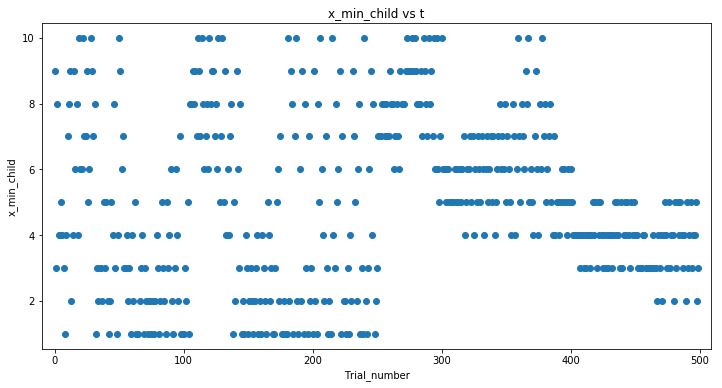

In [161]:
plot_vals("x_min_child", trials3_even_more)

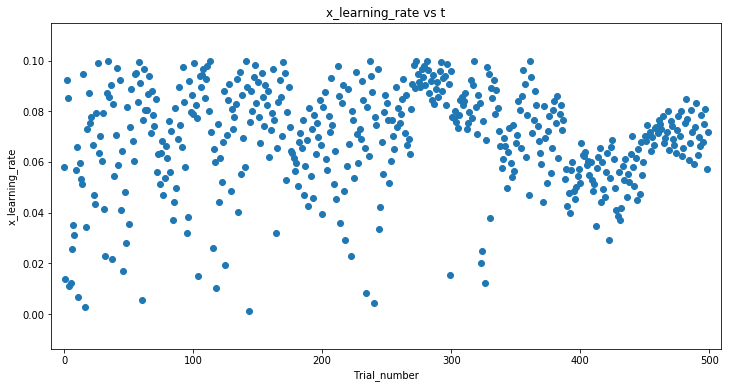

In [162]:
plot_vals("x_learning_rate", trials3_even_more)

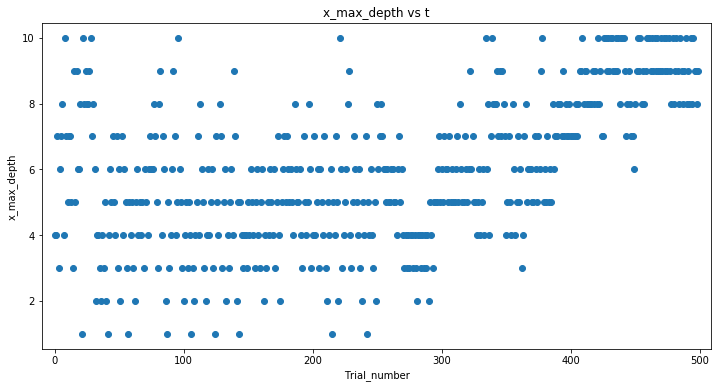

In [163]:
plot_vals("x_max_depth", trials3_even_more)

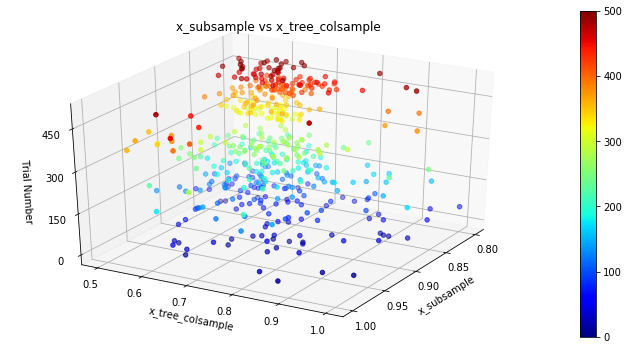

In [176]:
plot_vals_3d("x_subsample", "x_tree_colsample", trials3_even_more)

In [232]:
try:
    print (adfa)
except Exception as e:
    print e

name 'adfa' is not defined
